In [ ]:
import perceval as pcvl
from perceval.components import PS, BS, Circuit
from IPython.display import SVG
from perceval.rendering.pdisplay import pdisplay

from perceval import BasicState, BackendFactory

from boson_sampler import BosonSampler
import perceval.providers.scaleway as scw

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import tensorflow as tf
from tensorflow.keras import Sequential, Input, Layer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import numpy as np

from model import MnistModel
# from training import fit

from utils import MNIST_partial, plot_training_metrics

import matplotlib.pyplot as plt

from utils import accuracy
from training import fit, fit_combined_2

import tqdm

In [2]:
PQK_features = np.load("/Users/soardr/Perceval 2/Percevel-main/encoded_images_list_final_first3.npy")
PQK_features = torch.from_numpy(PQK_features)

In [3]:
labels = np.load("/Users/soardr/Perceval 2/Percevel-main/encoded_images_labels_list_final_first3.npy")
labels = torch.from_numpy(labels)

In [4]:
batch_idx = 0
inner_img_idx = 15

tensor(5)


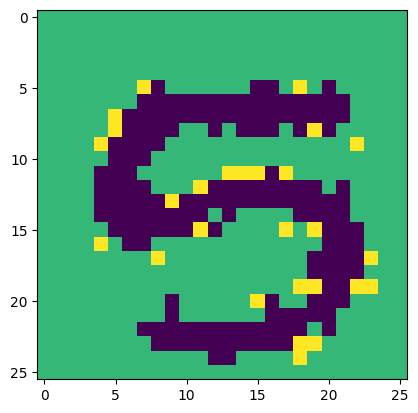

In [5]:
print(labels[batch_idx][inner_img_idx])
plt.imshow(PQK_features[batch_idx][inner_img_idx][0])

### Hyperparameters

In [6]:
# hyperparams

epochs = 20
lr = 0.005
path_folder_quantum = "checkpoints PQK quantum batch16 50epochs ClassicalCNN Struct"
path_folder_combined = "checkpoints PQK combined batch16 50 epochs"

### Model Definition

In [ ]:
class HybridCNN(nn.Module):
    def __init__(self, device):
        super().__init__()

        self.embedding_size = None
        
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()

        fc_input_size = 64 * 6 * 6

        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 10)

        self.device = device

    def forward(self, x):
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.flatten(x2)
        x4 = F.relu(self.fc1(x3))
        x5 = self.fc2(x4)

        return x5
    
    def training_step(self, batch):
        images, labels =  batch
        images = images.to(self.device)
        labels = labels.to(self.device)

        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return({'val_loss':loss, 'val_acc': acc})
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        return result['val_loss'], result['val_acc']

### Reshaping the tensors

In [8]:
PQK_features = PQK_features.reshape(6000, 3, 26, 26)[:, 1:3, :, :]

In [9]:
labels = labels.reshape(6000)

### Converting from float64 to float32

In [10]:
PQK_features_converted = []

for idx, item in enumerate(PQK_features):
    item_temp = item * 1e100
    item_temp = (item_temp - item_temp.min()) / (item_temp.max() - item_temp.min())
    item_temp = item_temp.to(dtype=torch.float32)

    PQK_features_converted.append(item_temp)

In [11]:
PQK_features_converted = torch.stack(PQK_features_converted)

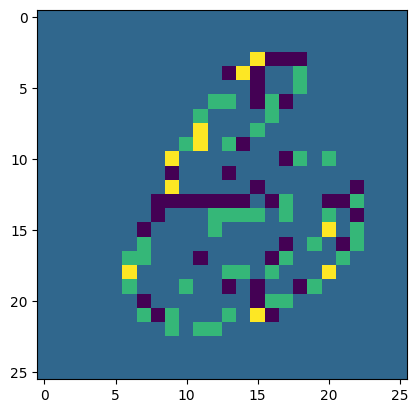

In [12]:
plt.imshow(PQK_features_converted[0][1])

### Making the new train and test loader

In [13]:
from torch.utils.data import random_split, TensorDataset

train_size = int(0.8 * len(PQK_features_converted))  # 80% for training
test_size = len(PQK_features_converted) - train_size
train_data, test_data = random_split(TensorDataset(PQK_features_converted, labels), [train_size, test_size])

# Create DataLoader objects
train_loader_2 = DataLoader(train_data, batch_size=16, shuffle=True)  # Batch size 16
test_loader_2 = DataLoader(test_data, batch_size=16, shuffle=False)

### Device

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device

device = torch.device(device)

In [8]:
device

device(type='mps')

### Model

In [42]:
model_quantum = HybridCNN(device=device)

In [43]:
model_quantum

HybridCNN(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Training

inside new version 2
device: mps
model shifted to device: mps
optimizer shifted to device: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


100%|██████████| 300/300 [00:01<00:00, 175.19it/s]


Epoch [0], val_loss: 2.3009, val_acc: 0.1125


100%|██████████| 300/300 [00:01<00:00, 182.57it/s]


Epoch [1], val_loss: 2.2982, val_acc: 0.1092


100%|██████████| 300/300 [00:01<00:00, 176.49it/s]


Epoch [2], val_loss: 2.2961, val_acc: 0.1092


100%|██████████| 300/300 [00:01<00:00, 194.71it/s]


Epoch [3], val_loss: 2.2929, val_acc: 0.1092


100%|██████████| 300/300 [00:01<00:00, 194.24it/s]


Epoch [4], val_loss: 2.2893, val_acc: 0.1092


100%|██████████| 300/300 [00:01<00:00, 197.13it/s]


Epoch [5], val_loss: 2.2830, val_acc: 0.1092


100%|██████████| 300/300 [00:01<00:00, 204.43it/s]


Epoch [6], val_loss: 2.2743, val_acc: 0.1208


100%|██████████| 300/300 [00:01<00:00, 202.59it/s]


Epoch [7], val_loss: 2.2603, val_acc: 0.1533


100%|██████████| 300/300 [00:01<00:00, 176.15it/s]


Epoch [8], val_loss: 2.2347, val_acc: 0.2250


100%|██████████| 300/300 [00:01<00:00, 194.09it/s]


Epoch [9], val_loss: 2.1887, val_acc: 0.2375


100%|██████████| 300/300 [00:01<00:00, 184.24it/s]


Epoch [10], val_loss: 2.0843, val_acc: 0.4508


100%|██████████| 300/300 [00:01<00:00, 199.99it/s]


Epoch [11], val_loss: 1.8914, val_acc: 0.4492


100%|██████████| 300/300 [00:01<00:00, 203.90it/s]


Epoch [12], val_loss: 1.6014, val_acc: 0.5875


100%|██████████| 300/300 [00:01<00:00, 187.32it/s]


Epoch [13], val_loss: 1.3125, val_acc: 0.6242


100%|██████████| 300/300 [00:01<00:00, 187.18it/s]


Epoch [14], val_loss: 1.0946, val_acc: 0.6742


100%|██████████| 300/300 [00:01<00:00, 192.64it/s]


Epoch [15], val_loss: 0.9628, val_acc: 0.7000


100%|██████████| 300/300 [00:01<00:00, 203.29it/s]


Epoch [16], val_loss: 0.8716, val_acc: 0.7175


100%|██████████| 300/300 [00:01<00:00, 202.58it/s]


Epoch [17], val_loss: 0.8050, val_acc: 0.7358


100%|██████████| 300/300 [00:01<00:00, 180.14it/s]


Epoch [18], val_loss: 0.7413, val_acc: 0.7525


100%|██████████| 300/300 [00:01<00:00, 177.71it/s]


Epoch [19], val_loss: 0.7136, val_acc: 0.7633


100%|██████████| 300/300 [00:01<00:00, 188.67it/s]
/Users/soardr/Perceval 2/Percevel-main/utils.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,2,figsize = (15,5))


Epoch [20], val_loss: 0.6695, val_acc: 0.7800


100%|██████████| 300/300 [00:01<00:00, 204.69it/s]


Epoch [21], val_loss: 0.6282, val_acc: 0.7958


100%|██████████| 300/300 [00:01<00:00, 200.27it/s]


Epoch [22], val_loss: 0.6054, val_acc: 0.8000


100%|██████████| 300/300 [00:01<00:00, 194.33it/s]


Epoch [23], val_loss: 0.5881, val_acc: 0.8025


100%|██████████| 300/300 [00:01<00:00, 179.93it/s]


Epoch [24], val_loss: 0.5728, val_acc: 0.8158


100%|██████████| 300/300 [00:01<00:00, 194.32it/s]


Epoch [25], val_loss: 0.5492, val_acc: 0.8167


100%|██████████| 300/300 [00:01<00:00, 184.25it/s]


Epoch [26], val_loss: 0.5425, val_acc: 0.8192


100%|██████████| 300/300 [00:01<00:00, 193.97it/s]


Epoch [27], val_loss: 0.5289, val_acc: 0.8300


100%|██████████| 300/300 [00:01<00:00, 198.20it/s]


Epoch [28], val_loss: 0.4978, val_acc: 0.8300


100%|██████████| 300/300 [00:01<00:00, 198.19it/s]


Epoch [29], val_loss: 0.4993, val_acc: 0.8367


100%|██████████| 300/300 [00:01<00:00, 180.41it/s]


Epoch [30], val_loss: 0.4783, val_acc: 0.8400


100%|██████████| 300/300 [00:01<00:00, 193.55it/s]


Epoch [31], val_loss: 0.4804, val_acc: 0.8483


100%|██████████| 300/300 [00:01<00:00, 184.14it/s]


Epoch [32], val_loss: 0.4768, val_acc: 0.8458


100%|██████████| 300/300 [00:01<00:00, 194.49it/s]


Epoch [33], val_loss: 0.4769, val_acc: 0.8442


100%|██████████| 300/300 [00:01<00:00, 184.17it/s]


Epoch [34], val_loss: 0.4548, val_acc: 0.8500


100%|██████████| 300/300 [00:01<00:00, 186.29it/s]


Epoch [35], val_loss: 0.4434, val_acc: 0.8542


100%|██████████| 300/300 [00:01<00:00, 196.25it/s]


Epoch [36], val_loss: 0.4478, val_acc: 0.8550


100%|██████████| 300/300 [00:01<00:00, 200.78it/s]


Epoch [37], val_loss: 0.4420, val_acc: 0.8542


100%|██████████| 300/300 [00:01<00:00, 199.02it/s]


Epoch [38], val_loss: 0.4295, val_acc: 0.8558


100%|██████████| 300/300 [00:01<00:00, 197.38it/s]


Epoch [39], val_loss: 0.4212, val_acc: 0.8642


100%|██████████| 300/300 [00:01<00:00, 189.34it/s]


Epoch [40], val_loss: 0.4208, val_acc: 0.8617


100%|██████████| 300/300 [00:01<00:00, 188.60it/s]


Epoch [41], val_loss: 0.4204, val_acc: 0.8658


100%|██████████| 300/300 [00:01<00:00, 174.38it/s]


Epoch [42], val_loss: 0.3996, val_acc: 0.8708


100%|██████████| 300/300 [00:01<00:00, 196.02it/s]


Epoch [43], val_loss: 0.3861, val_acc: 0.8717


100%|██████████| 300/300 [00:01<00:00, 197.74it/s]


Epoch [44], val_loss: 0.4028, val_acc: 0.8733


100%|██████████| 300/300 [00:01<00:00, 177.78it/s]


Epoch [45], val_loss: 0.3898, val_acc: 0.8675


100%|██████████| 300/300 [00:01<00:00, 184.82it/s]


Epoch [46], val_loss: 0.3821, val_acc: 0.8700


100%|██████████| 300/300 [00:01<00:00, 188.61it/s]


Epoch [47], val_loss: 0.3806, val_acc: 0.8792


100%|██████████| 300/300 [00:01<00:00, 184.41it/s]


Epoch [48], val_loss: 0.3645, val_acc: 0.8825


100%|██████████| 300/300 [00:01<00:00, 175.22it/s]


Epoch [49], val_loss: 0.3671, val_acc: 0.8825


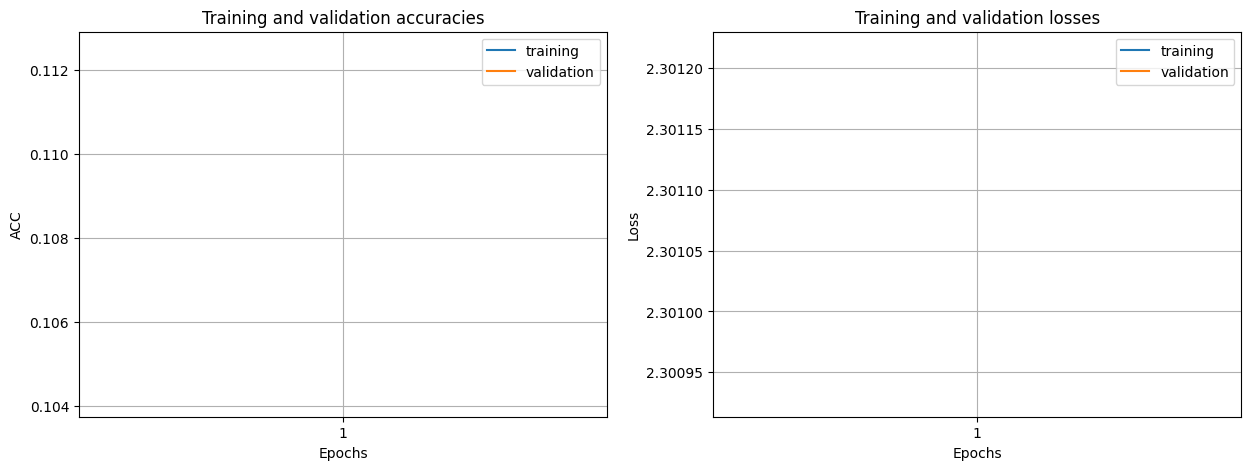

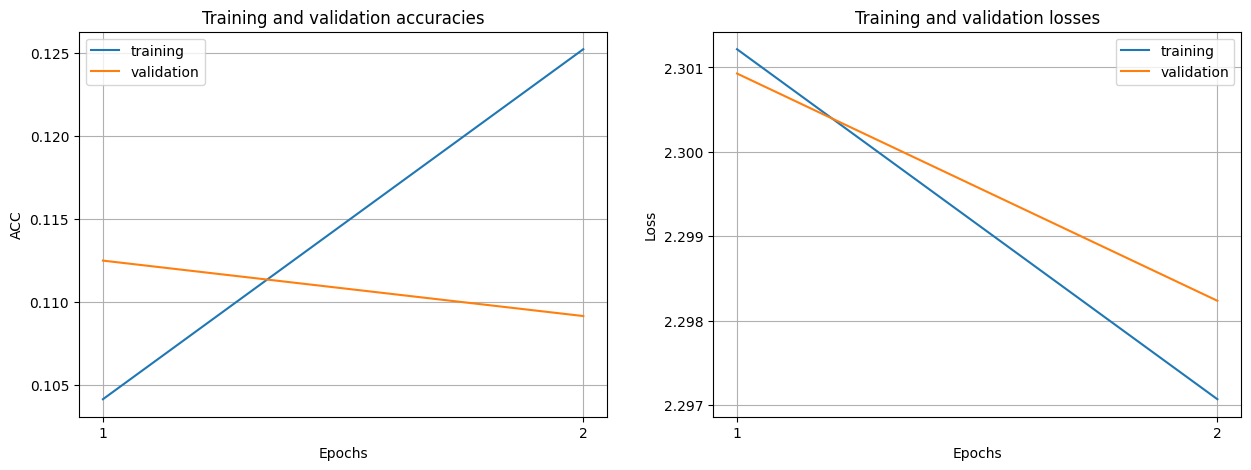

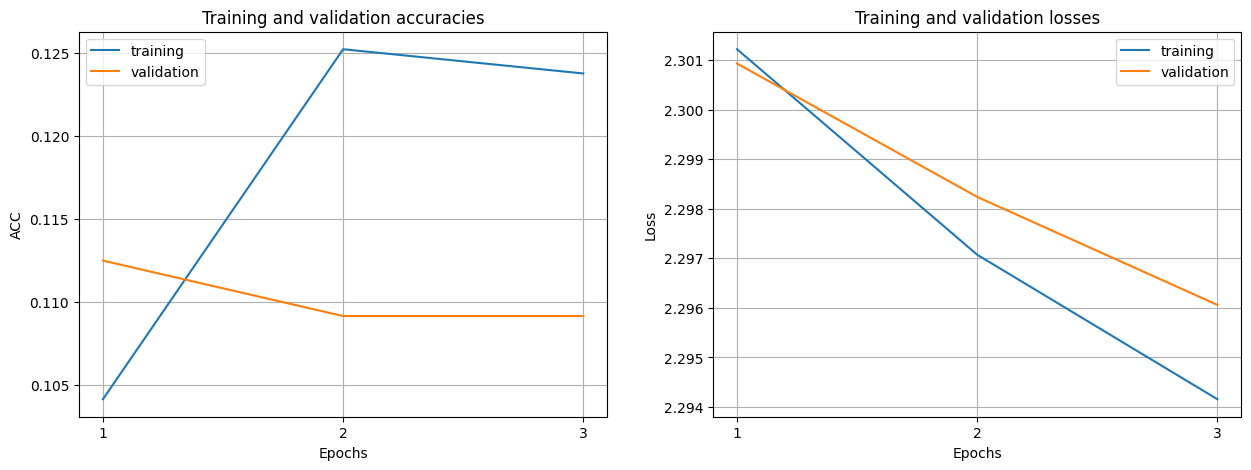

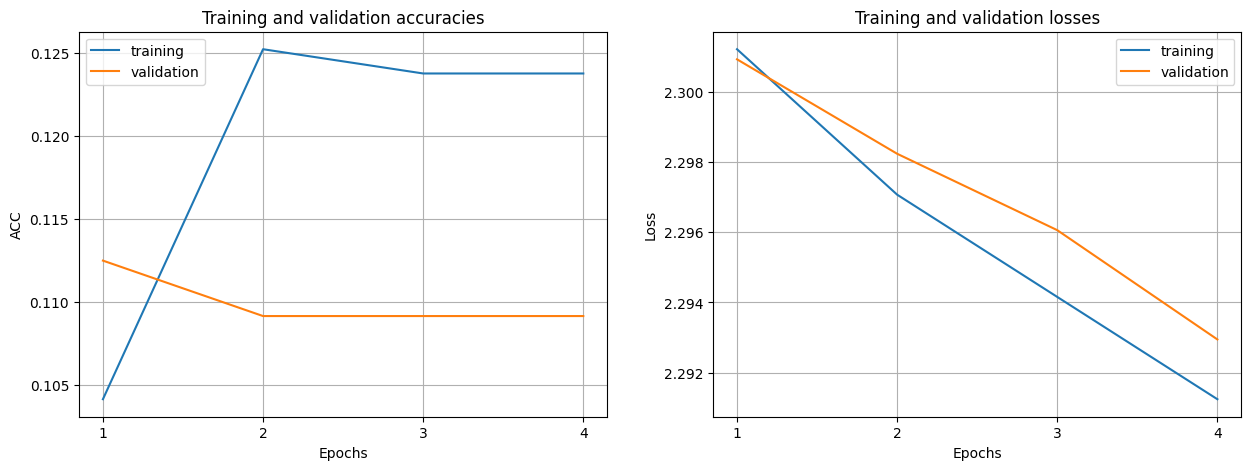

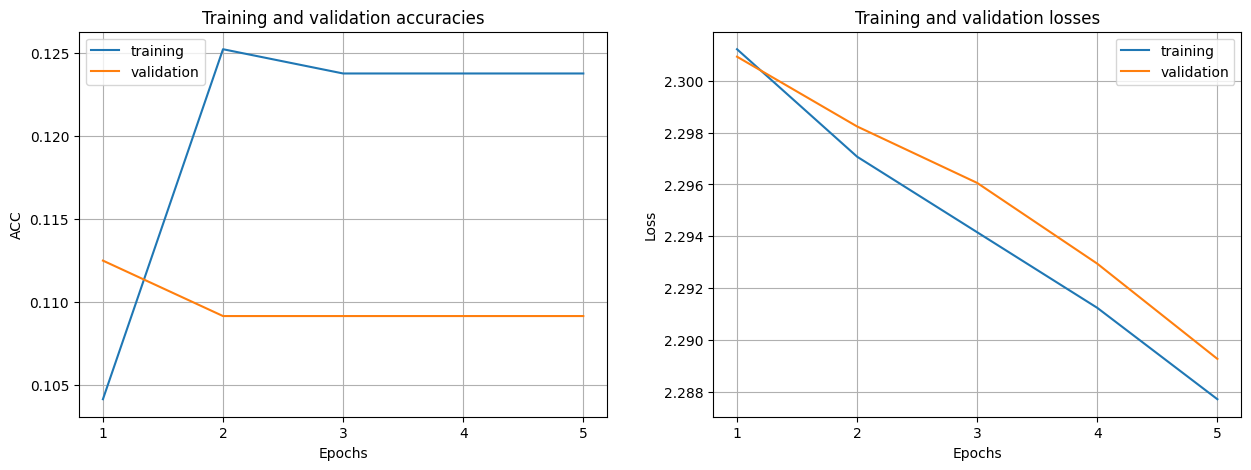

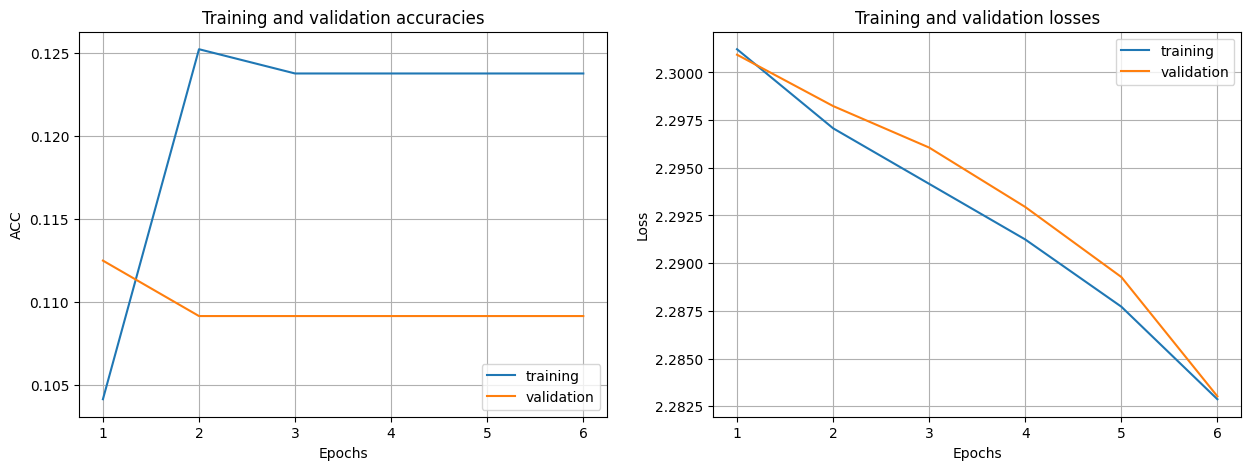

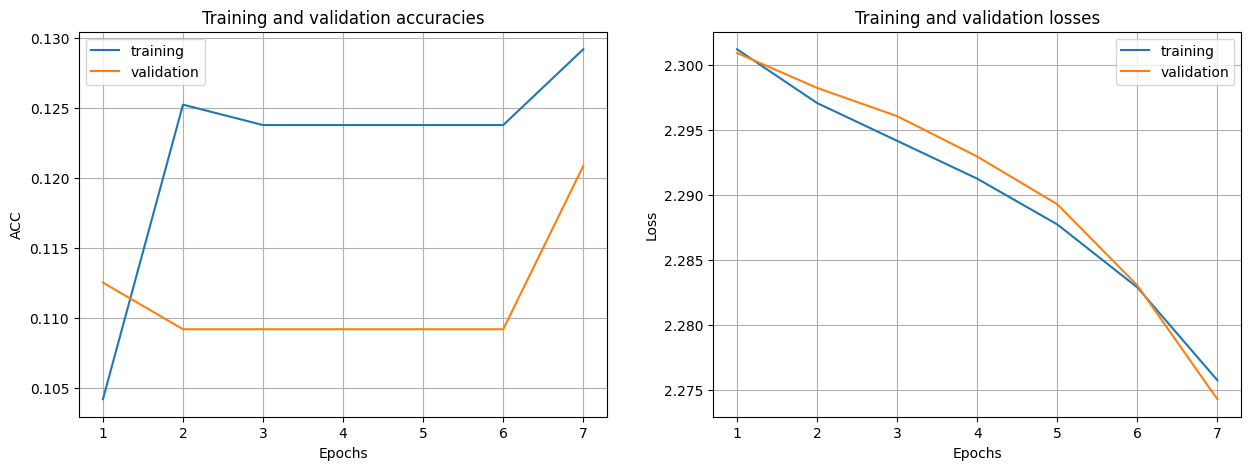

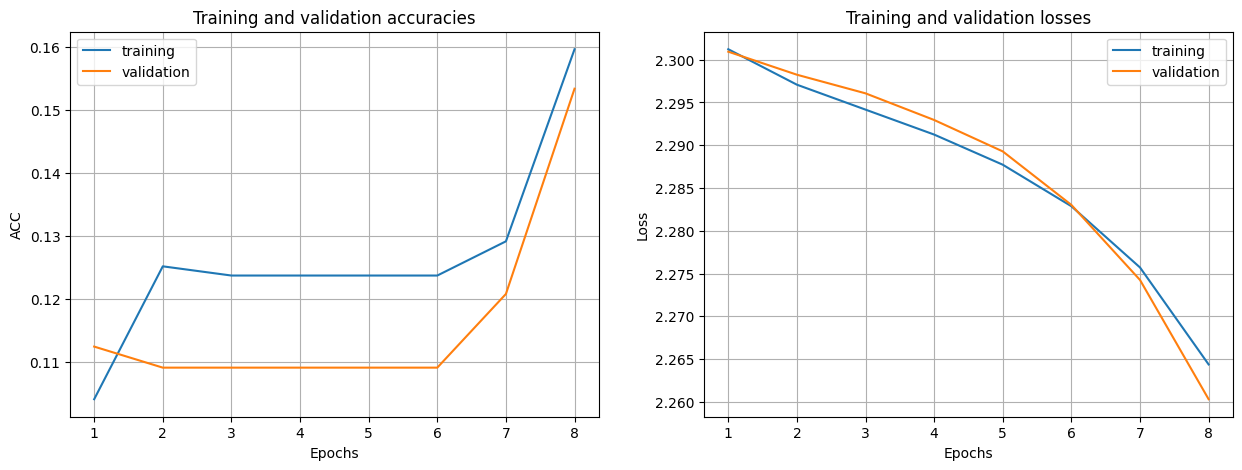

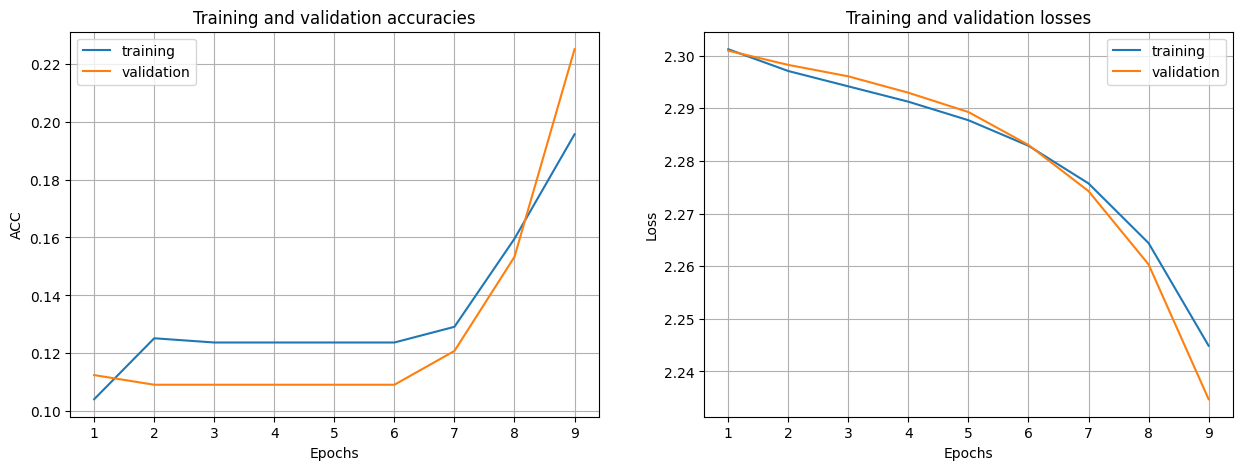

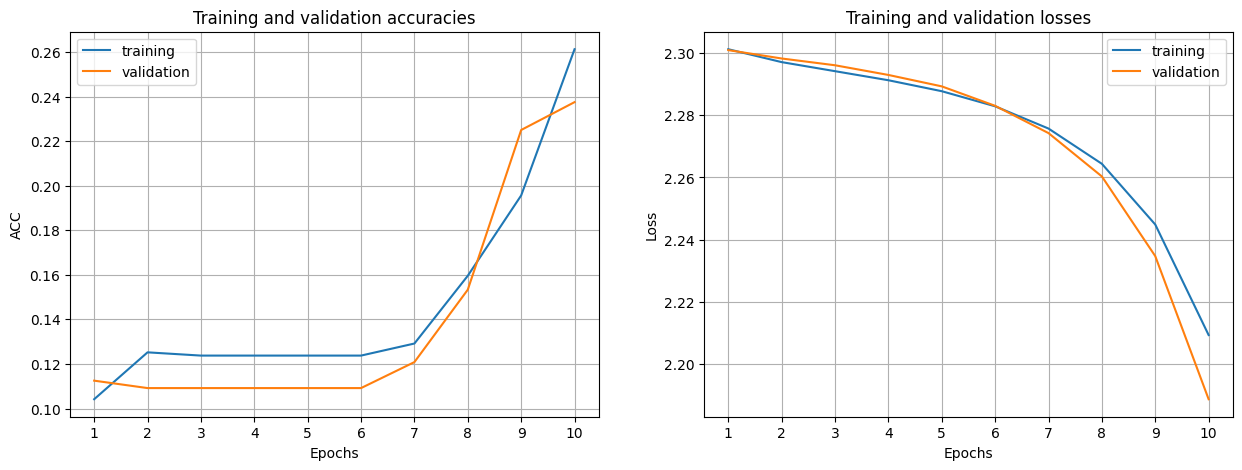

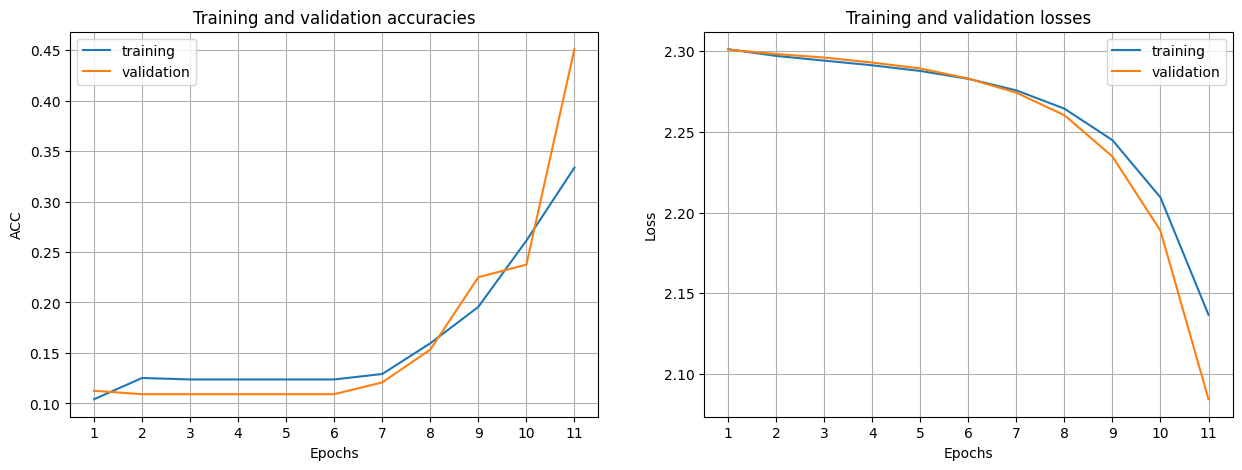

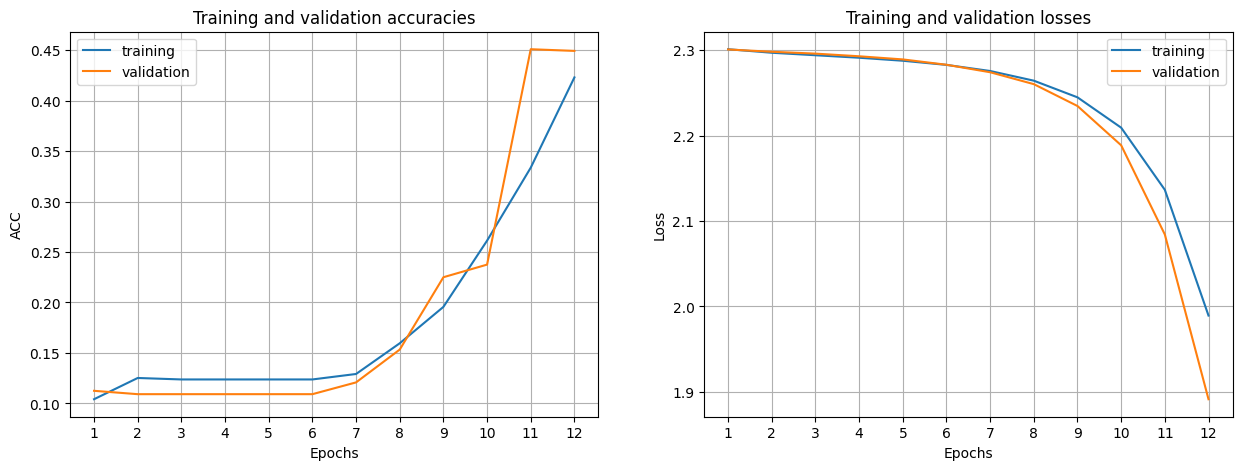

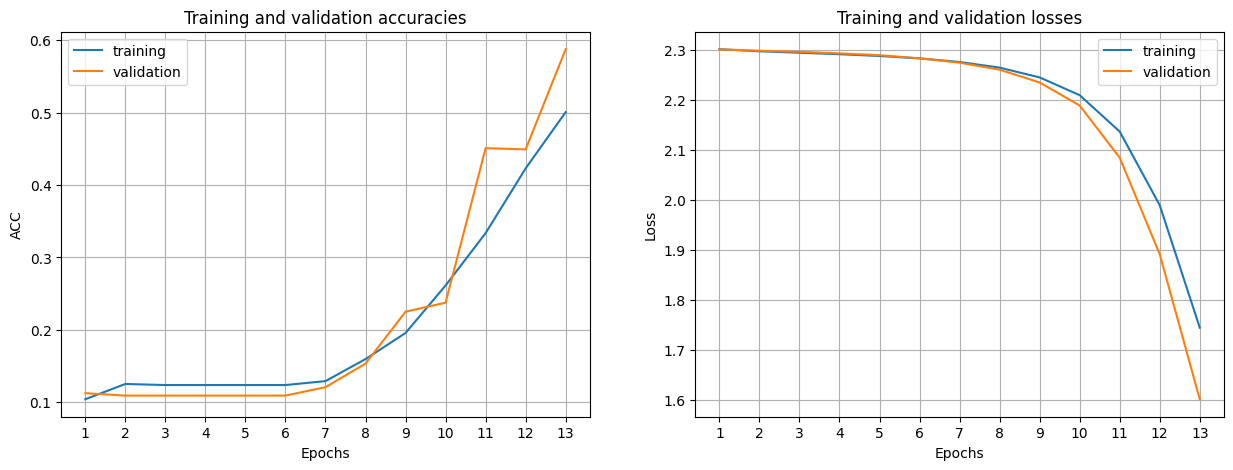

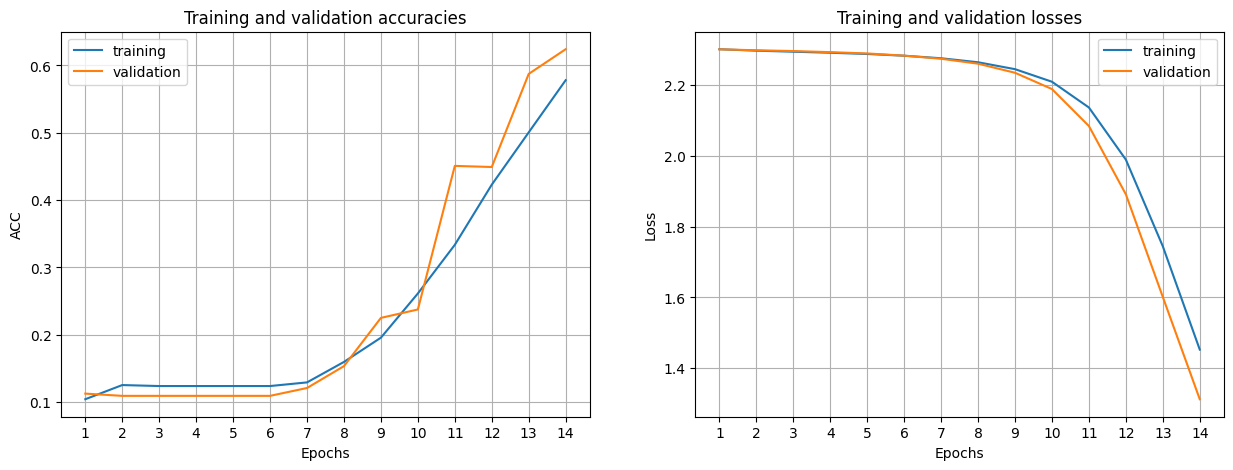

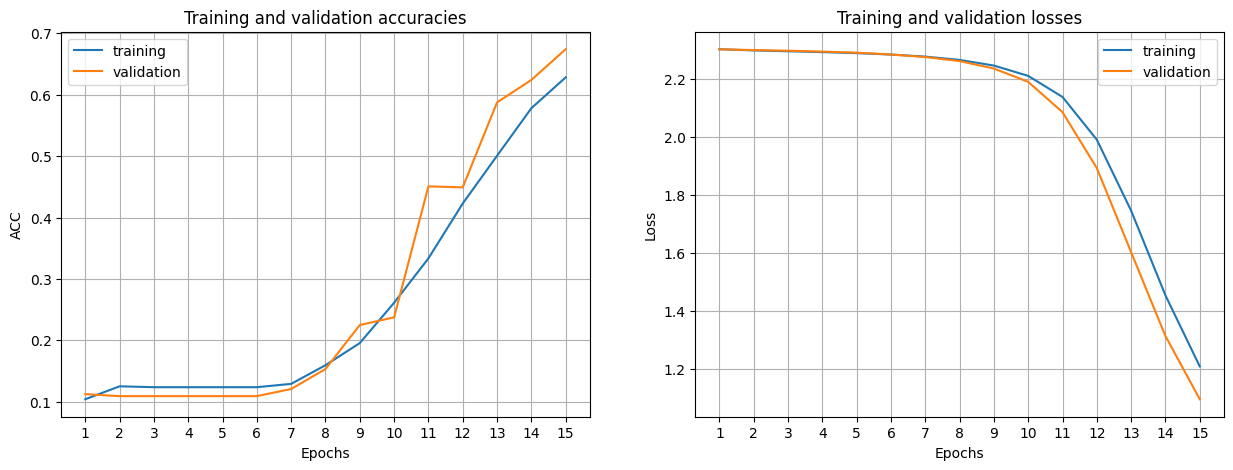

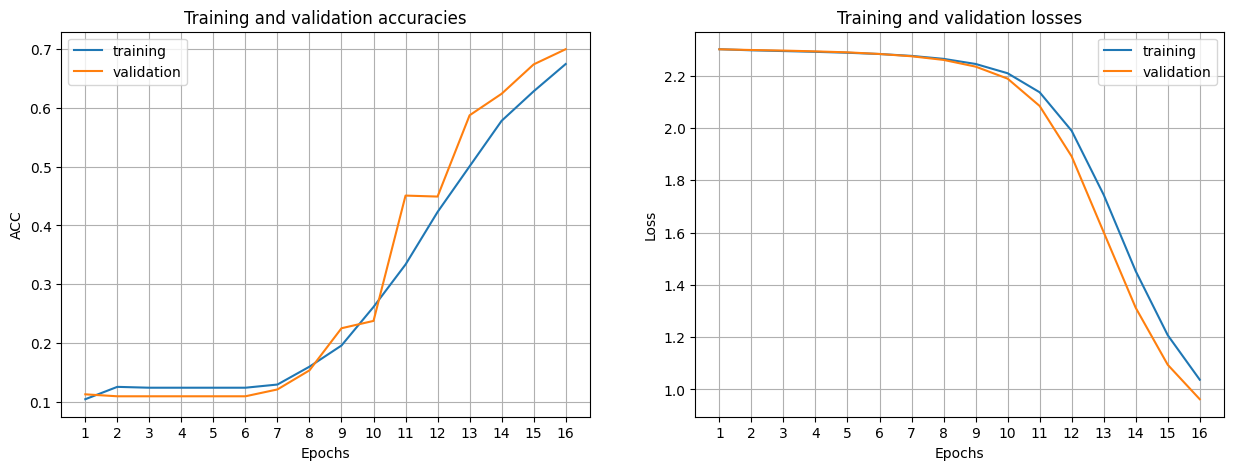

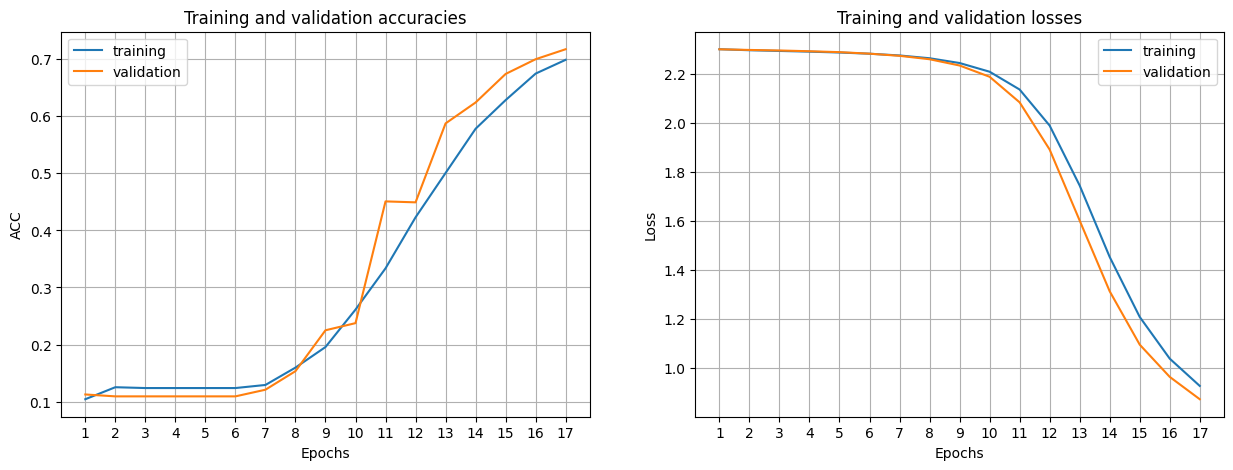

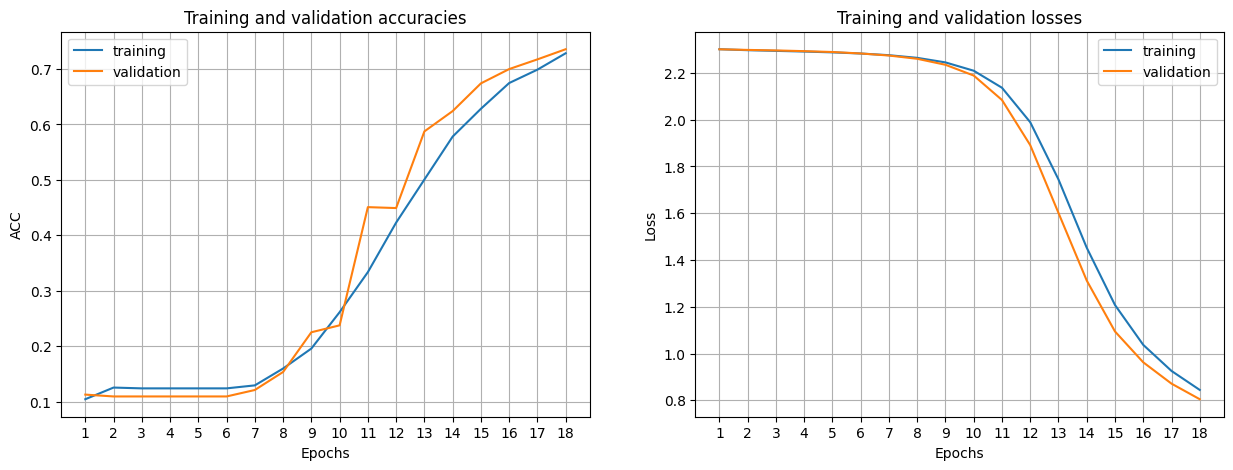

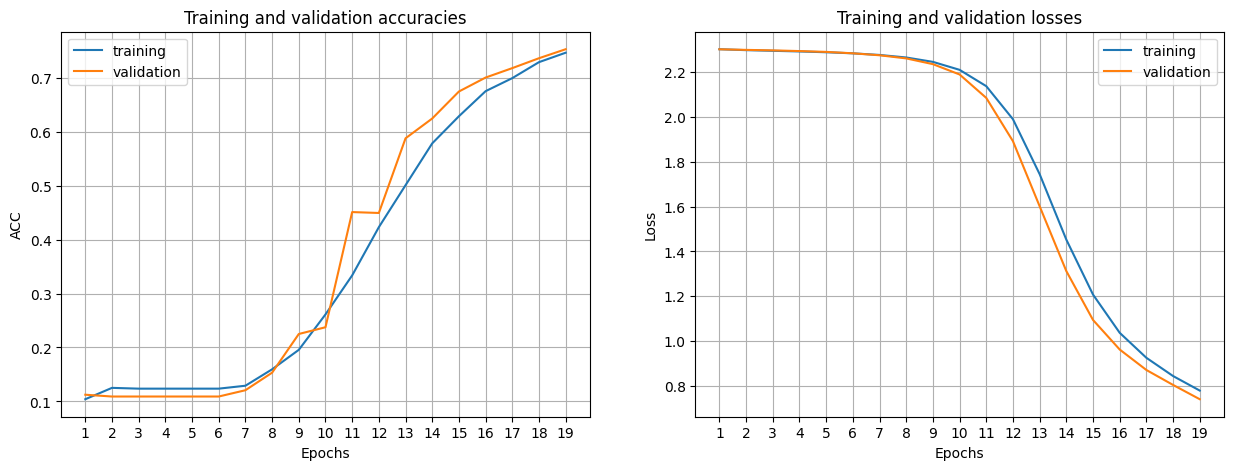

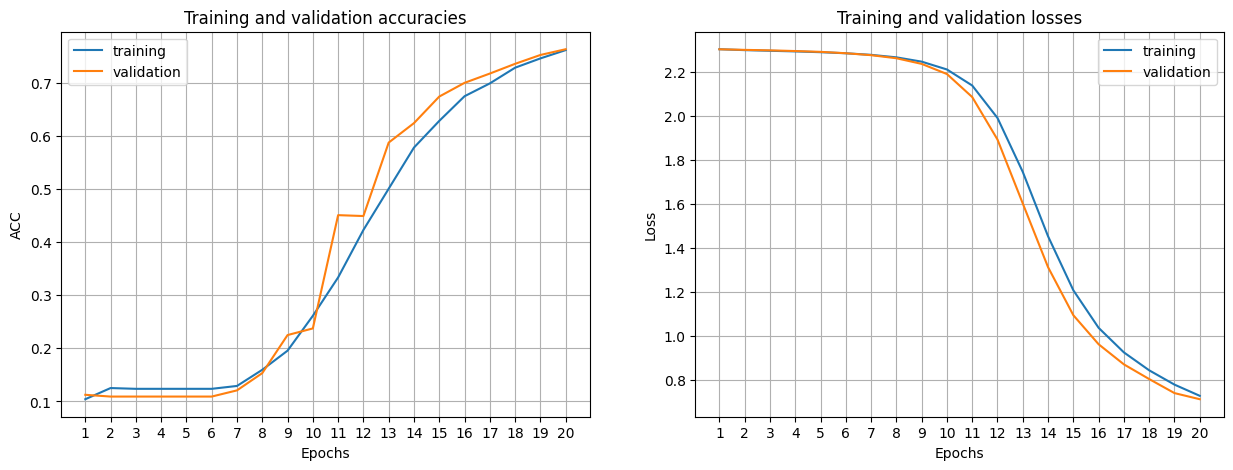

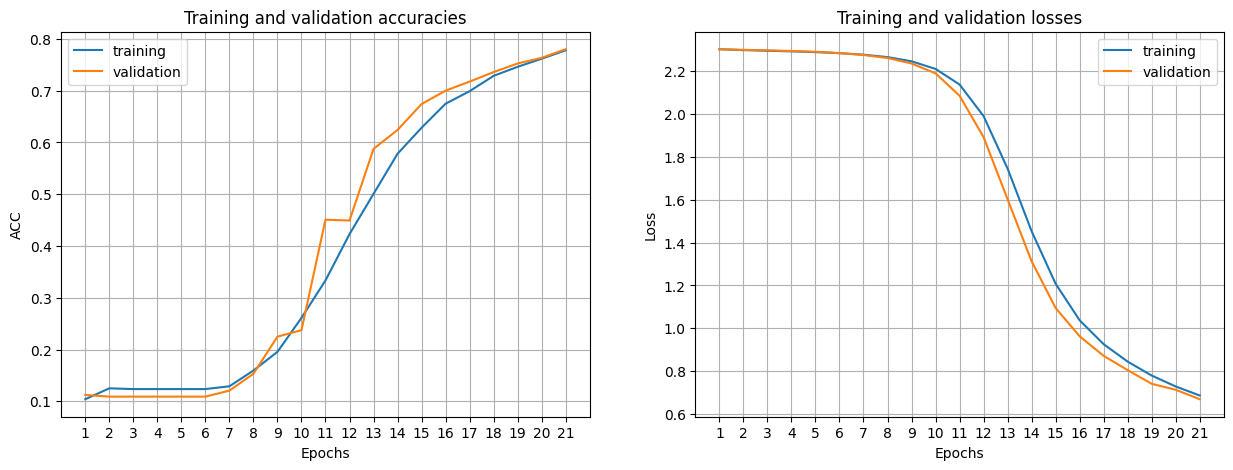

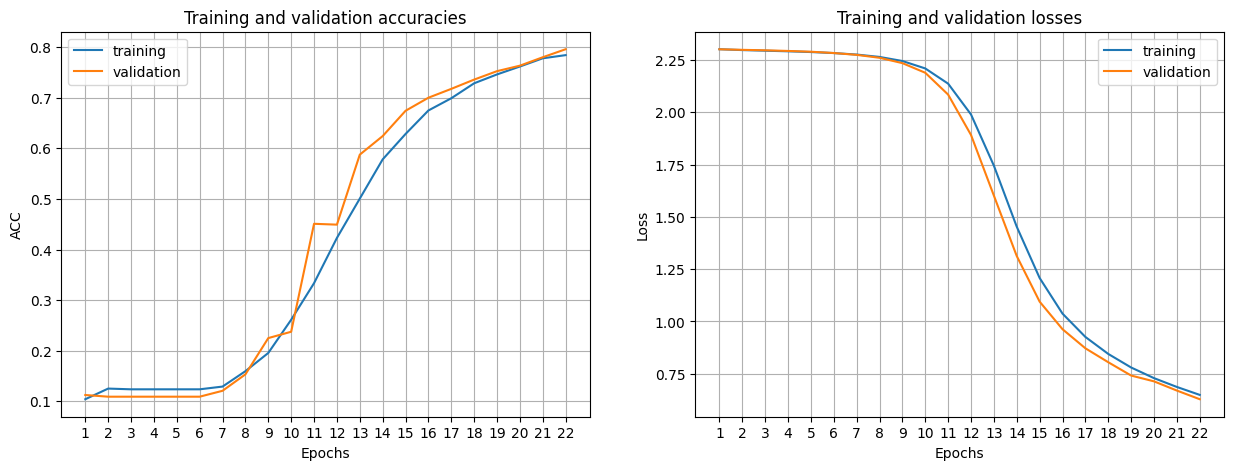

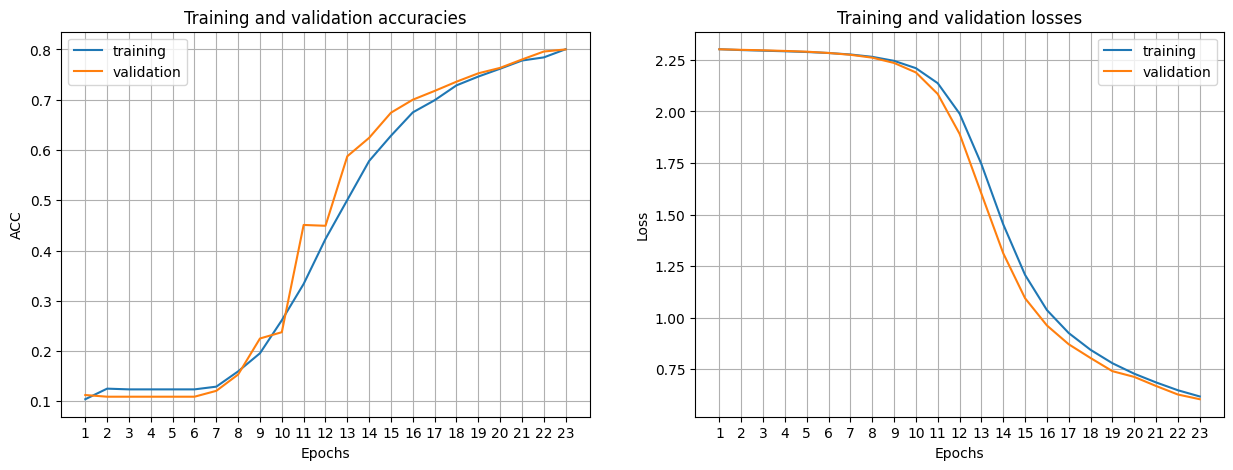

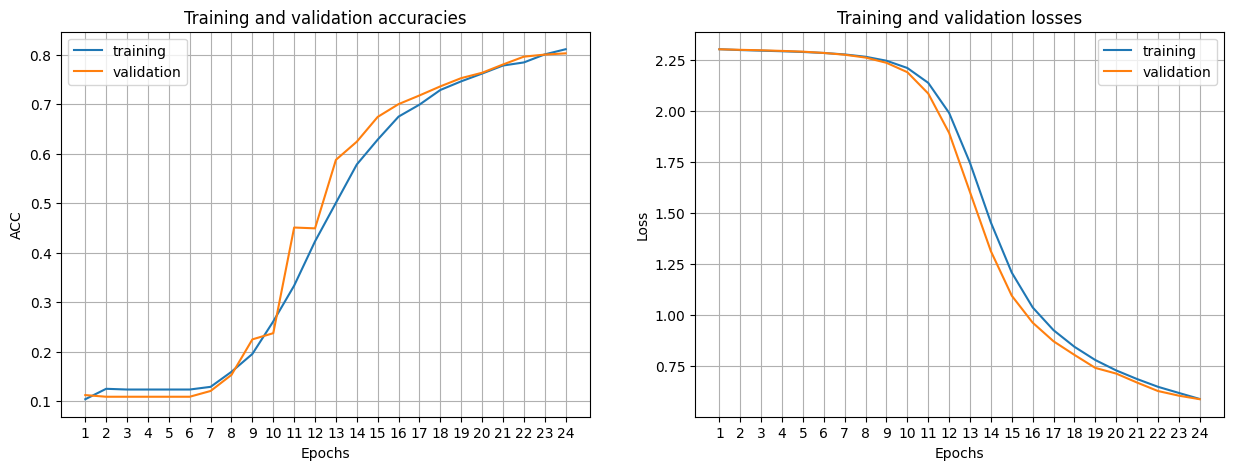

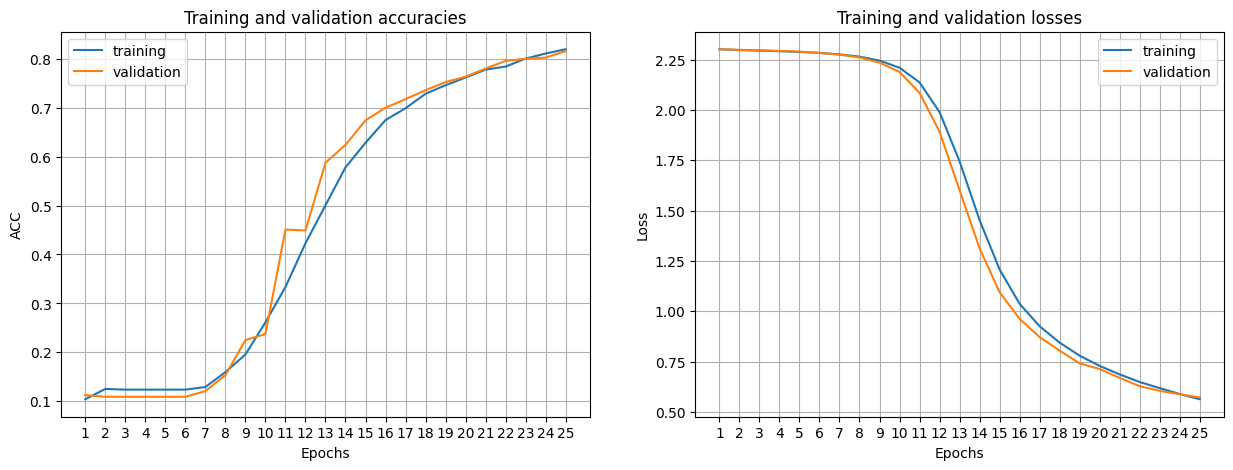

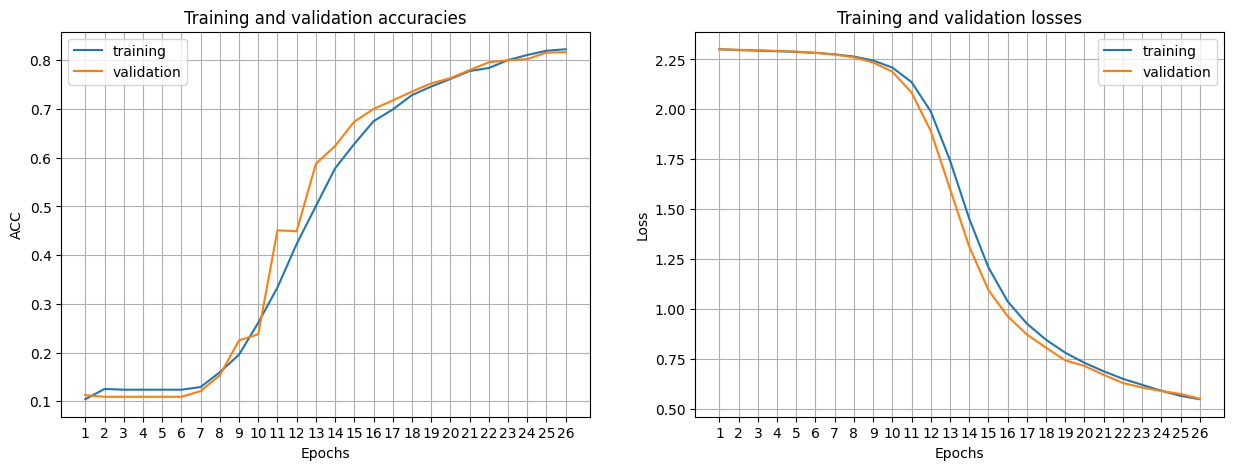

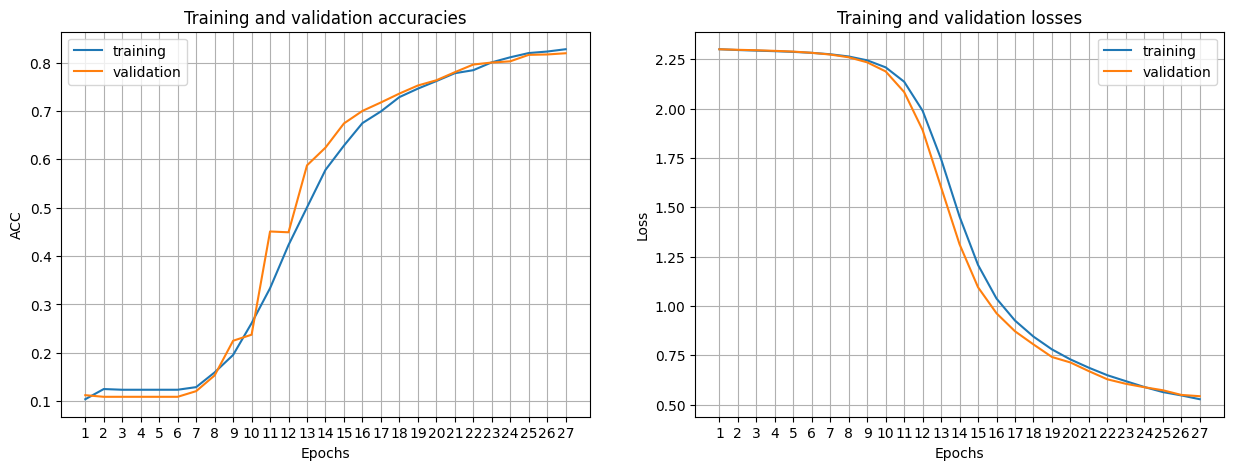

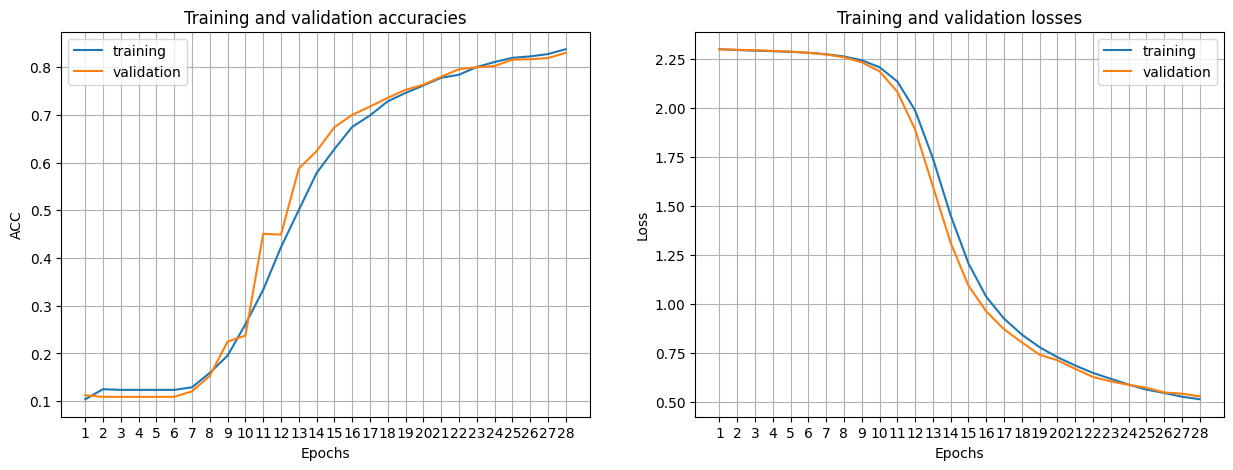

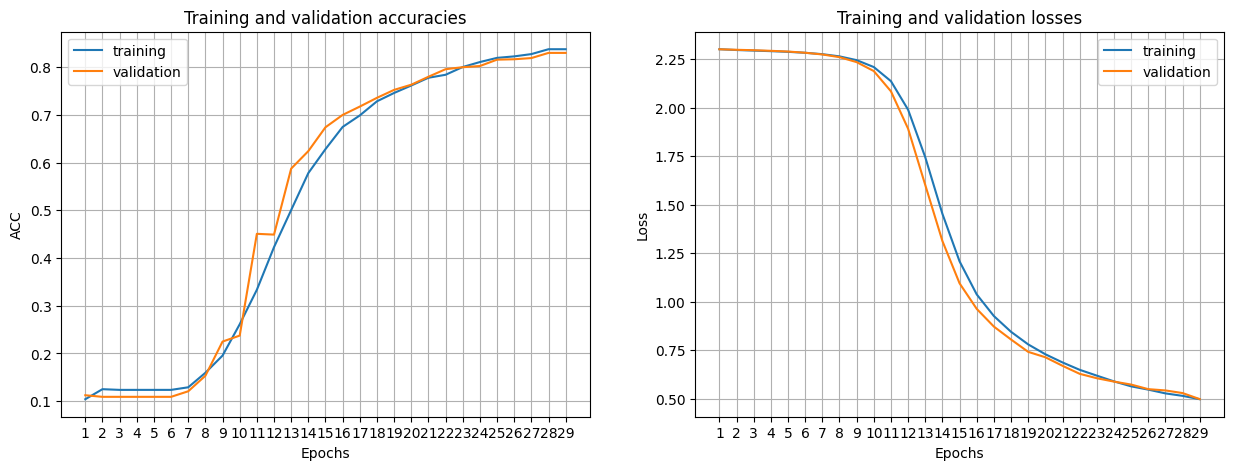

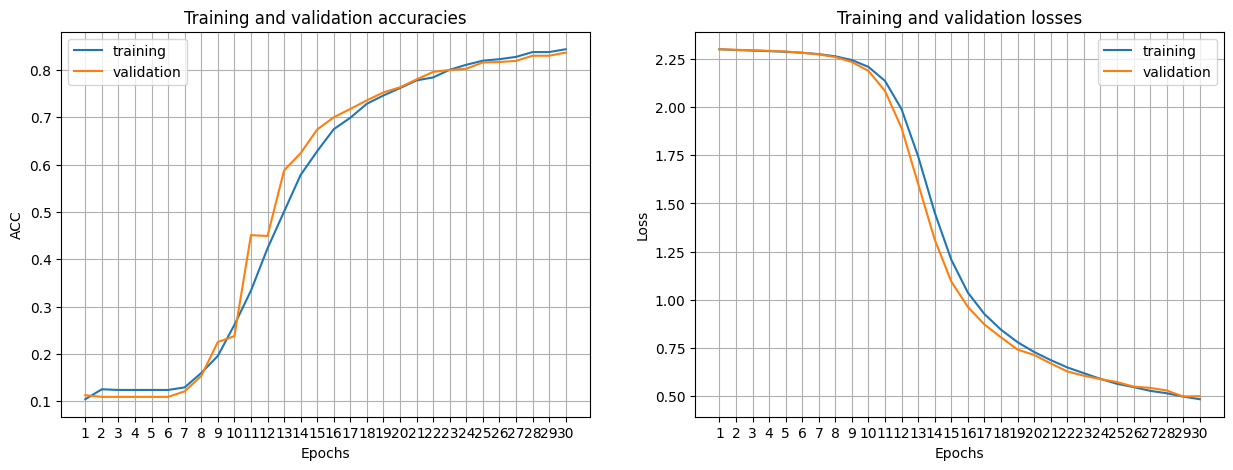

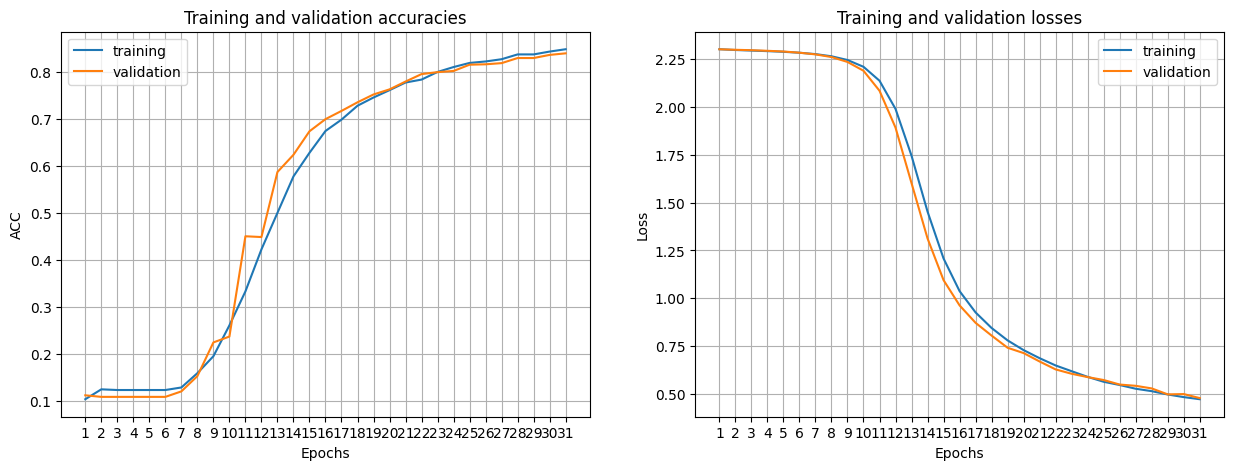

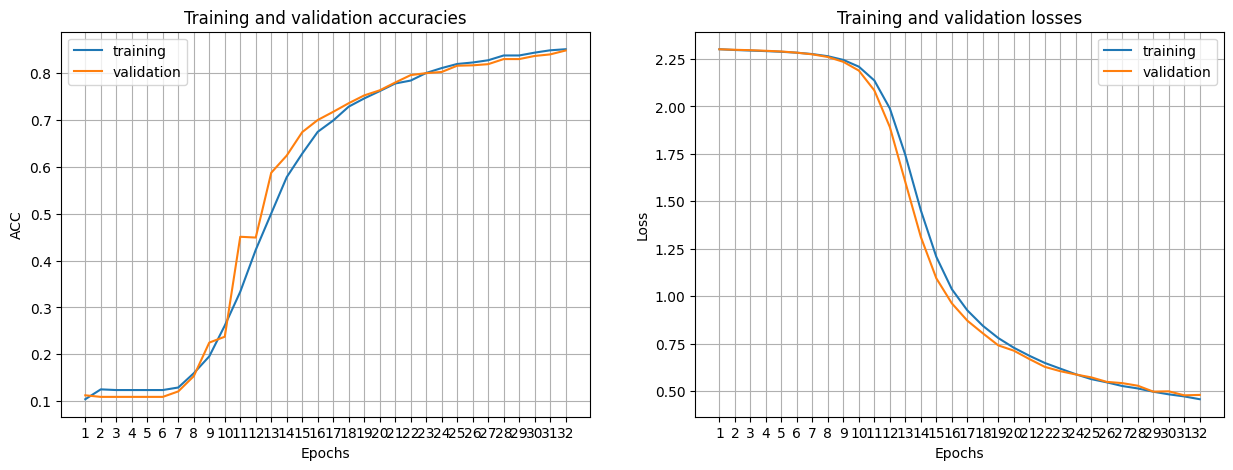

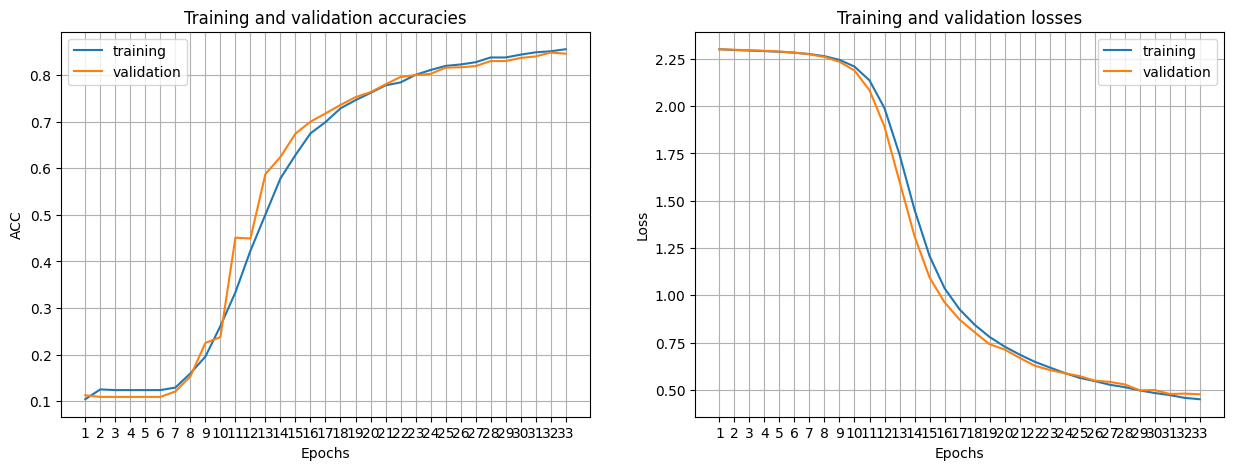

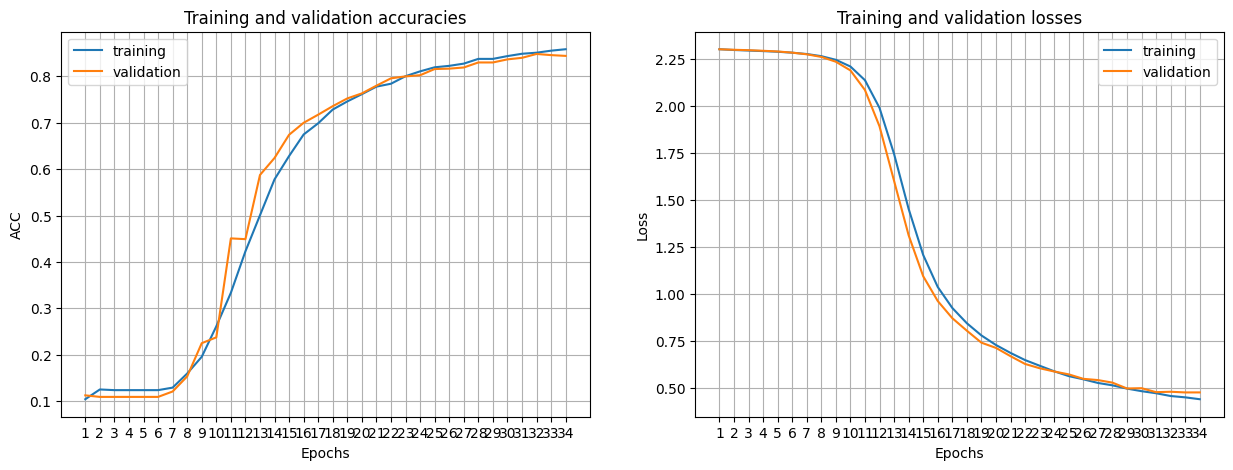

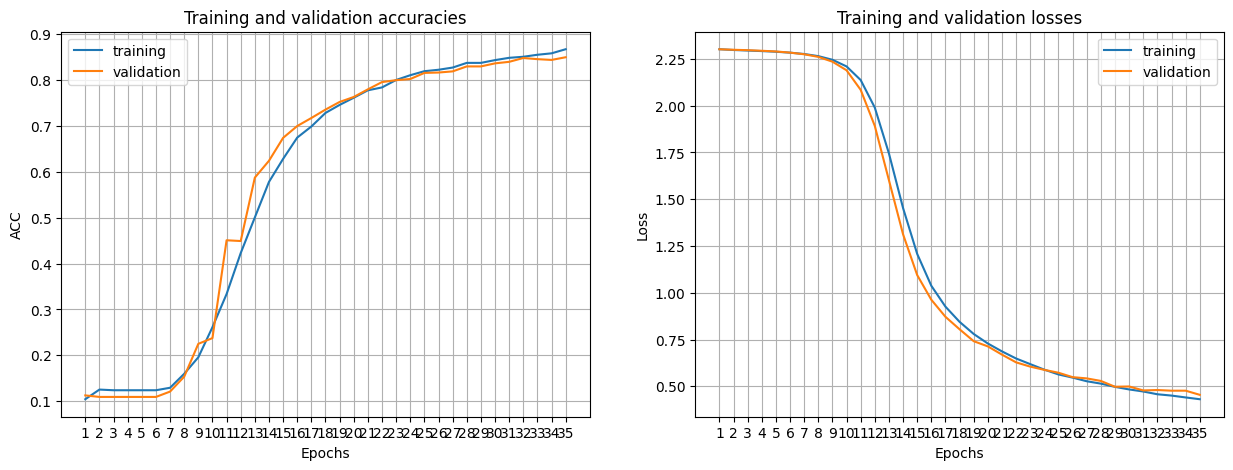

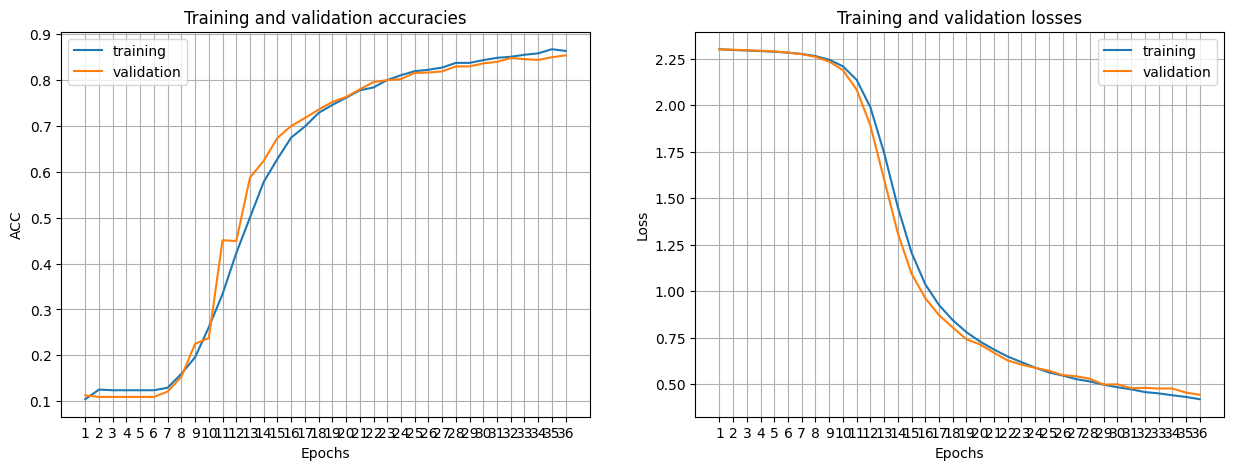

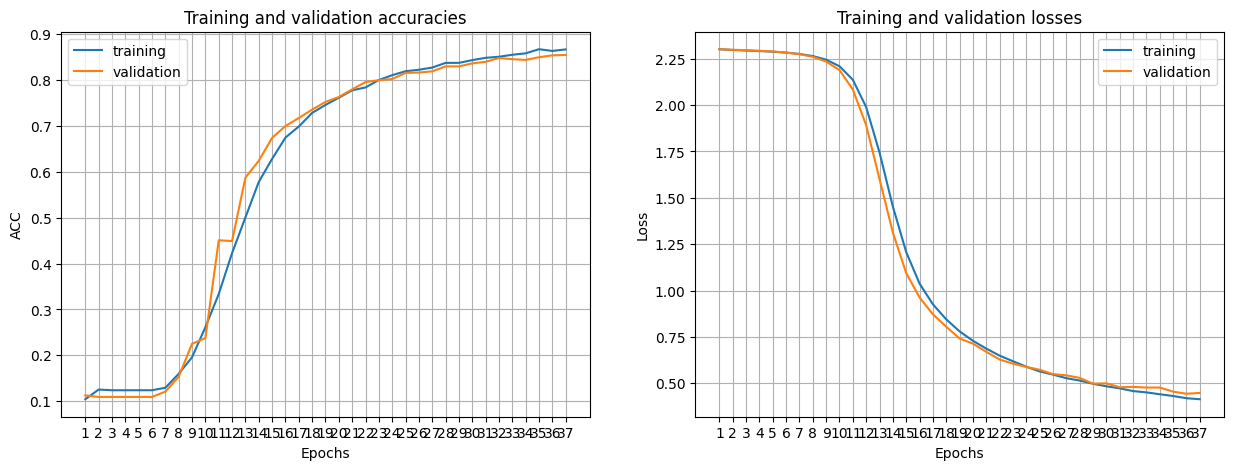

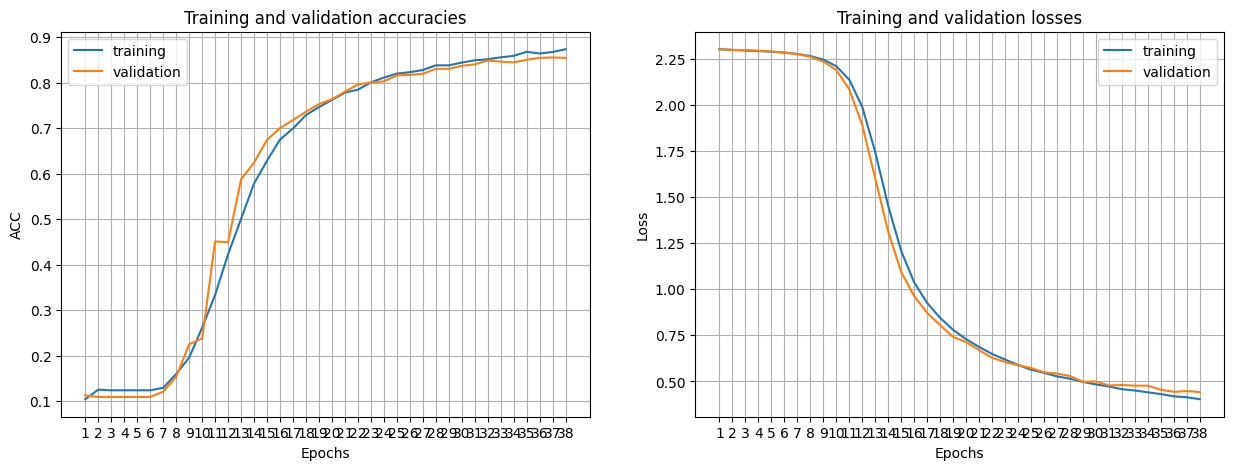

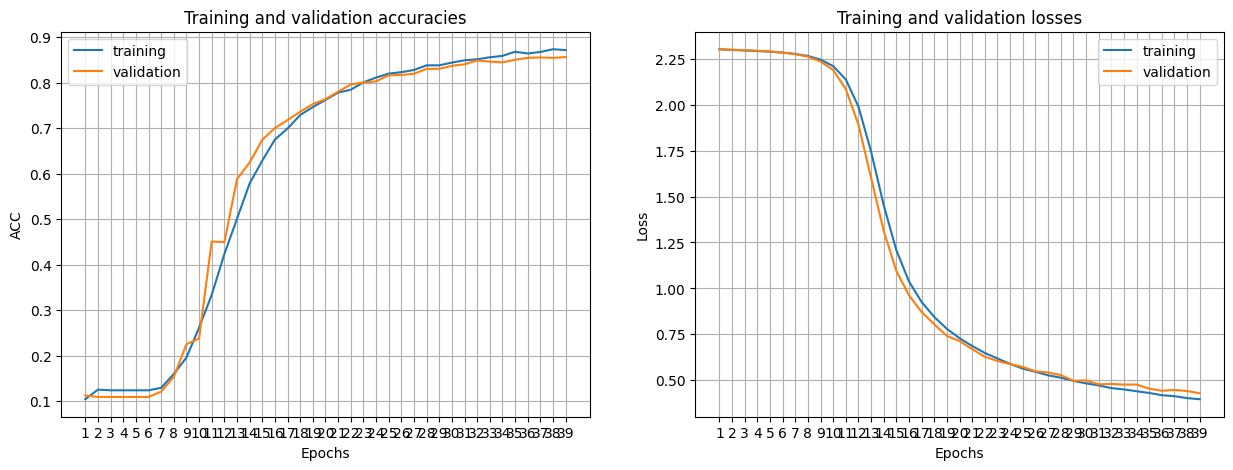

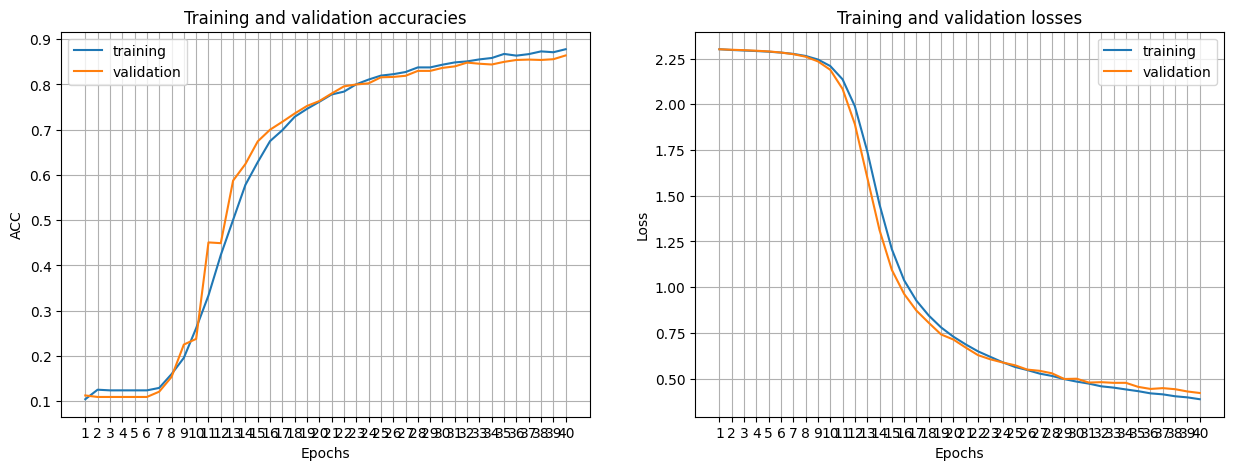

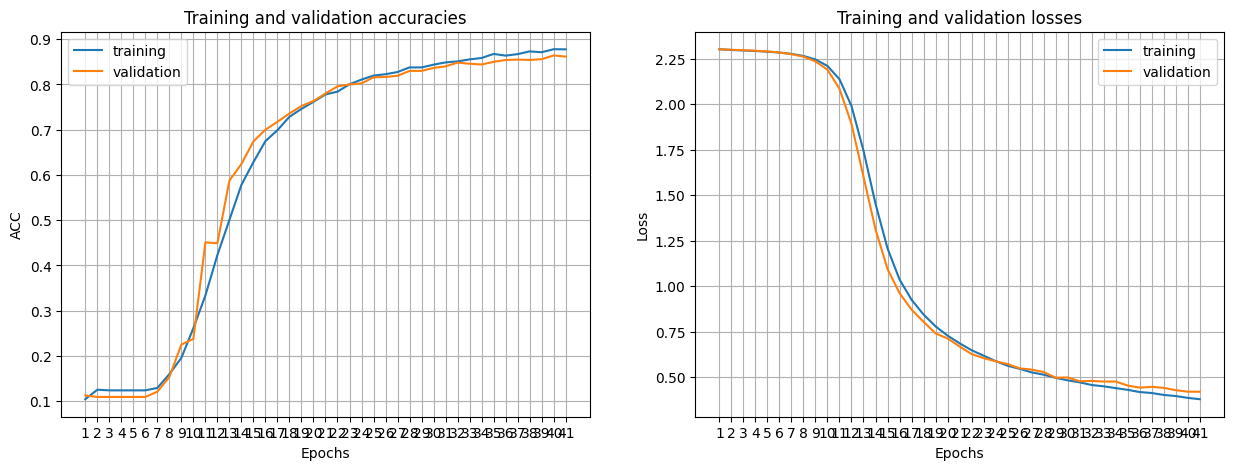

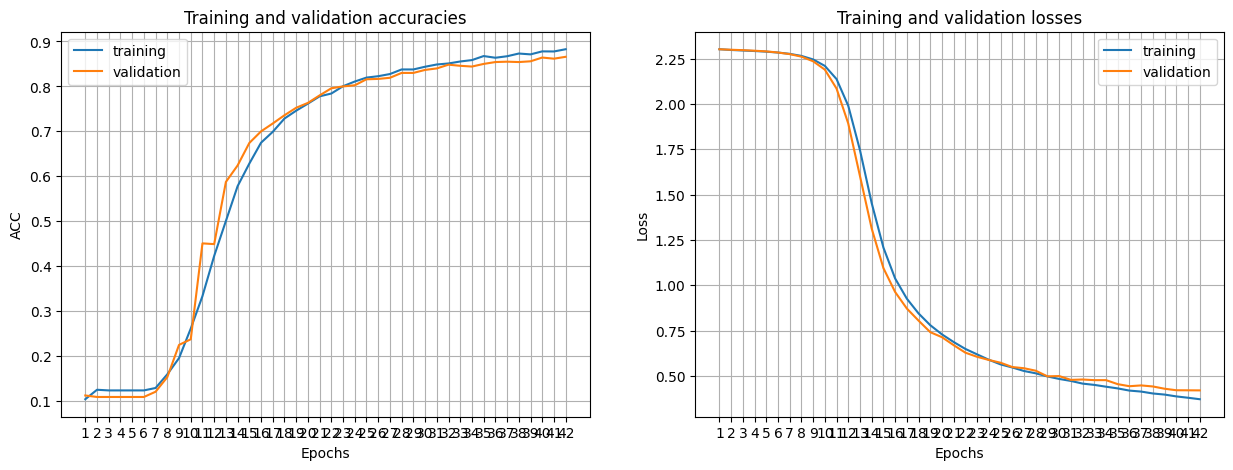

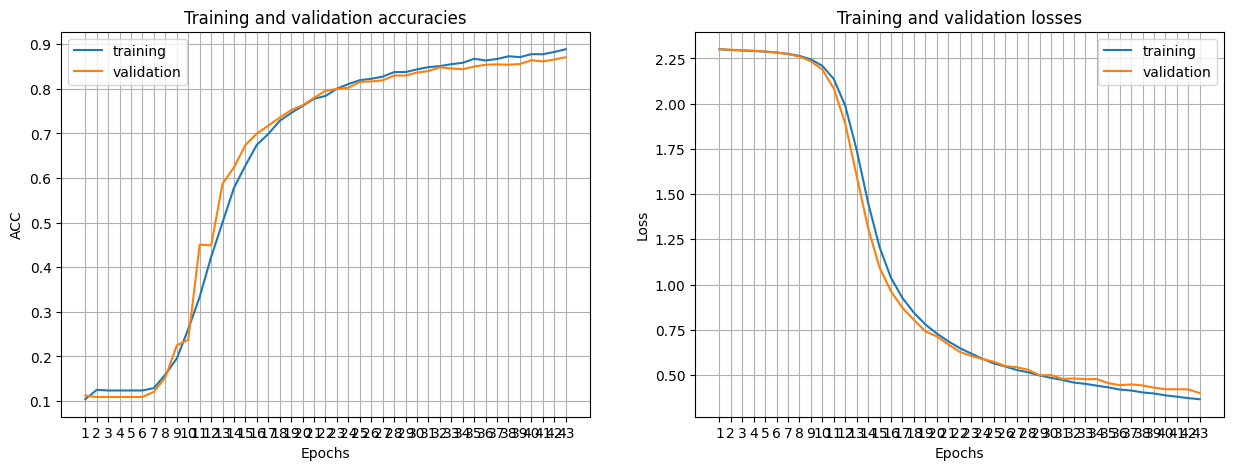

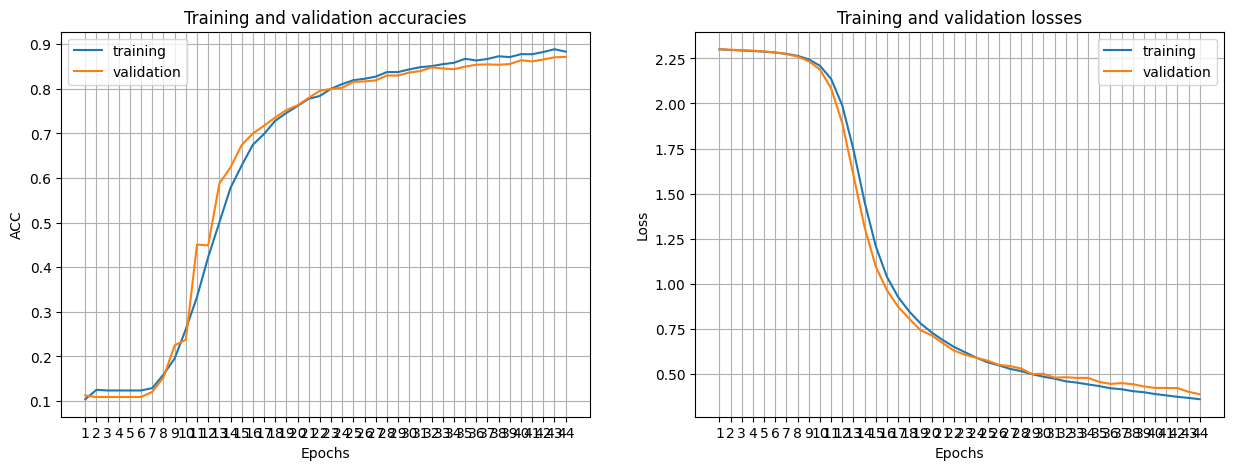

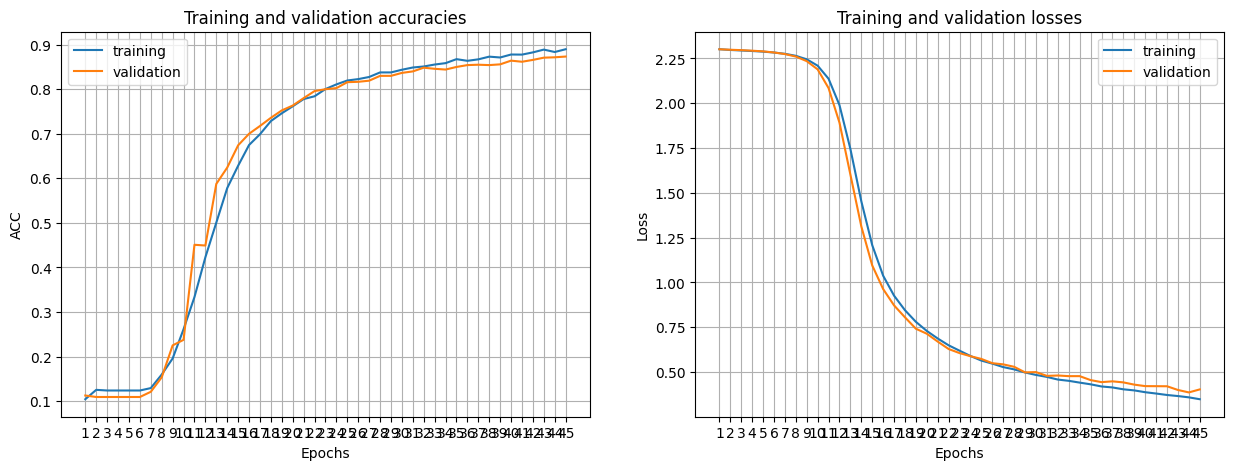

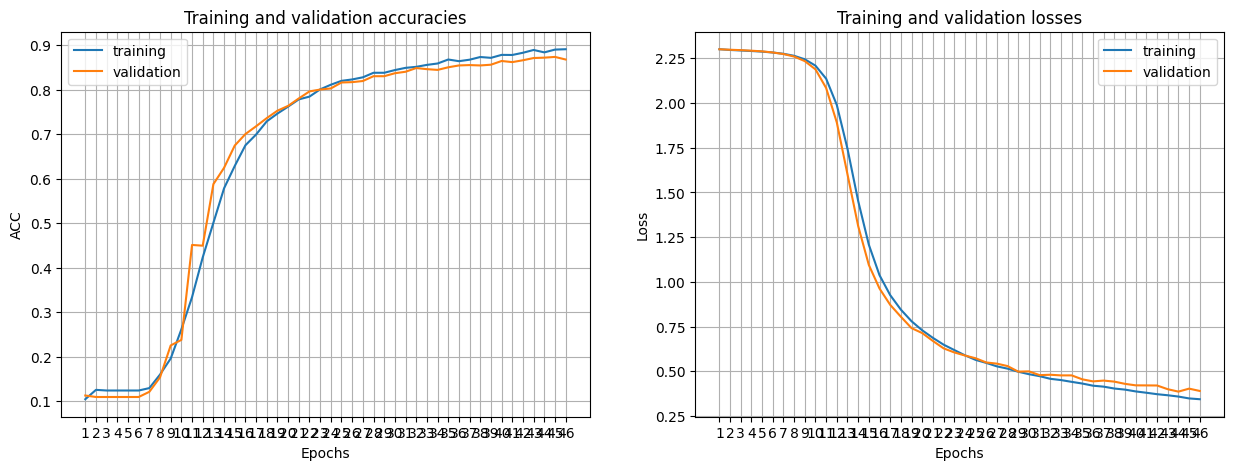

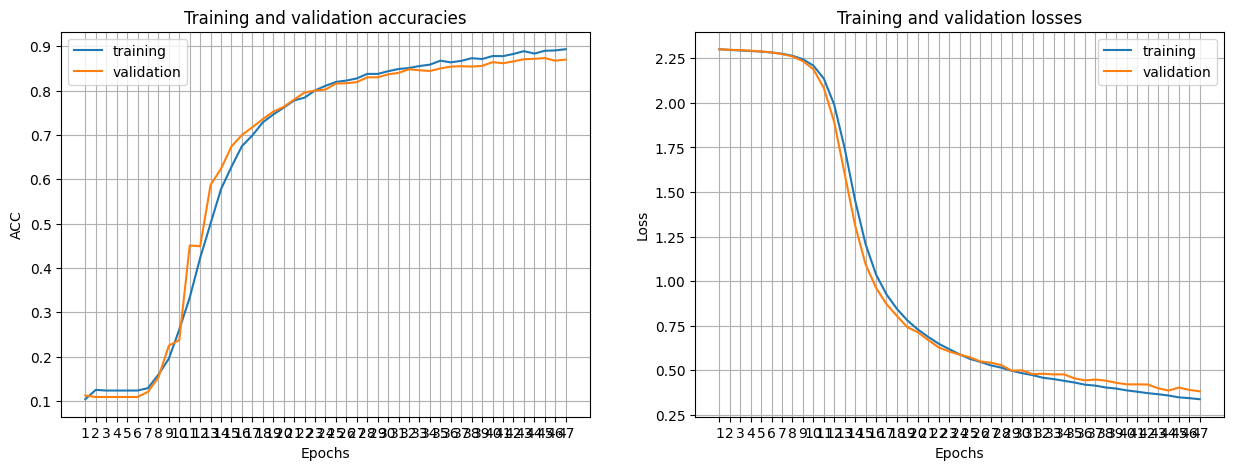

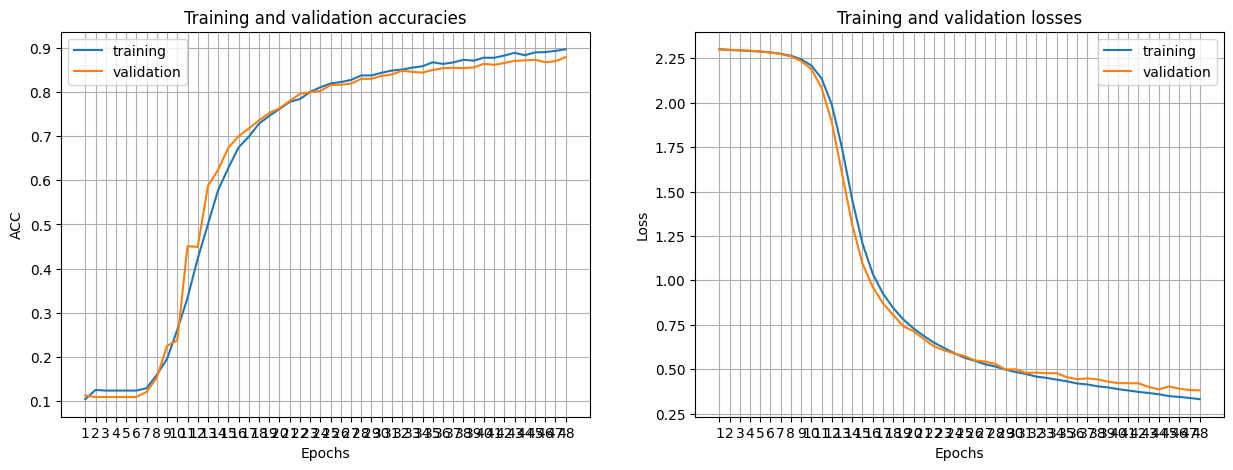

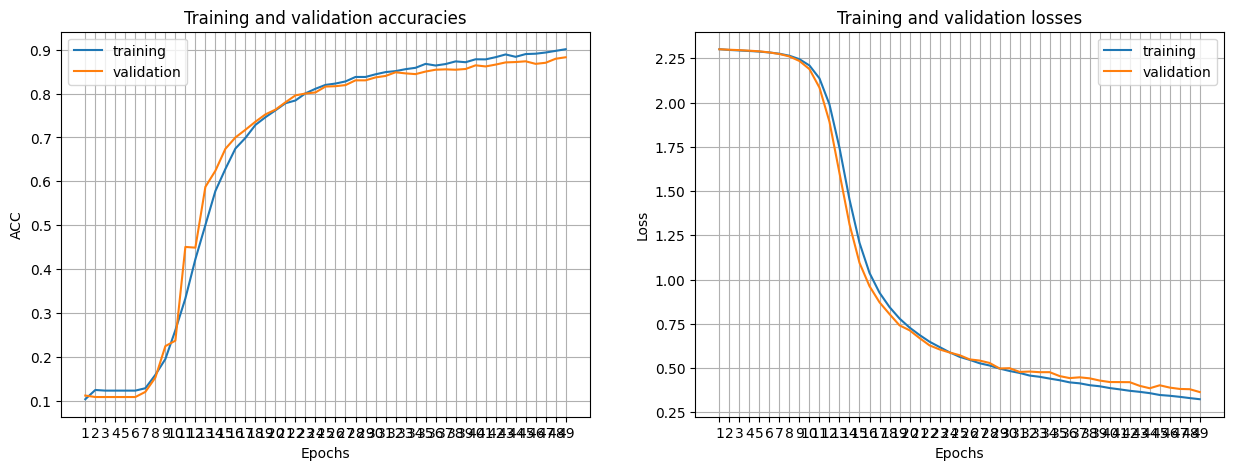

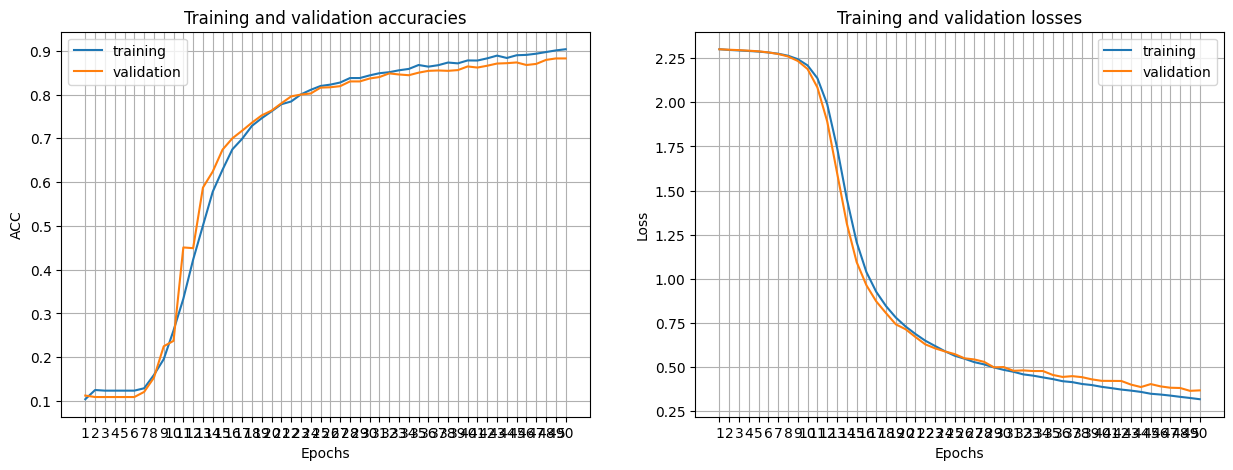

In [44]:
experiment_quantum = fit(epochs=50, lr=lr, model_temp=model_quantum, train_loader=train_loader_2, val_loader=test_loader_2, bs=None, device=device, file_path=path_folder_quantum)

### Normal MNIST dataset loading

In [19]:
train_dataset_classical = MNIST_partial(data="/Users/soardr/Perceval 2/Percevel-main/data", split = 'train')
val_dataset_classical = MNIST_partial(data="/Users/soardr/Perceval 2/Percevel-main/data", split='val')

In [ ]:
batch_size = 16
train_loader_classical = DataLoader(train_dataset_classical, batch_size, shuffle = True)
val_loader_classical = DataLoader(val_dataset_classical, batch_size, shuffle = False)

# Quantum-Classical Combined Convolutional Model

### Loading the combined dataset using the 'npy' files

In [9]:
labels_combined = np.load("/Users/soardr/Perceval 2/Percevel-main/PQK_CNN__labels.npy")
labels_combined = torch.from_numpy(labels_combined)

In [10]:
encoded_images_combined = np.load("/Users/soardr/Perceval 2/Percevel-main/PQK_CNN__encoded_images.npy")
encoded_images_combined = torch.from_numpy(encoded_images_combined)

In [11]:
original_images_combined = np.load("/Users/soardr/Perceval 2/Percevel-main/PQK_CNN__original_images.npy")
original_images_combined = torch.from_numpy(original_images_combined)

In [12]:
labels_combined.shape, encoded_images_combined.shape, original_images_combined.shape

(torch.Size([375, 16]),
 torch.Size([375, 16, 9, 26, 26]),
 torch.Size([375, 16, 1, 28, 28]))

In [13]:
encoded_images_combined = encoded_images_combined[:, :, :3, :, :]

In [14]:
labels_combined.shape, encoded_images_combined.shape, original_images_combined.shape

(torch.Size([375, 16]),
 torch.Size([375, 16, 3, 26, 26]),
 torch.Size([375, 16, 1, 28, 28]))

In [15]:
labels_combined_flat = labels_combined.reshape(6000)
encoded_images_combined_flat = encoded_images_combined.reshape(6000, 3, 26, 26)
original_images_combined_flat = original_images_combined.reshape(6000, 1, 28, 28)

In [16]:
labels_combined_flat.shape, encoded_images_combined_flat.shape, original_images_combined_flat.shape

(torch.Size([6000]),
 torch.Size([6000, 3, 26, 26]),
 torch.Size([6000, 1, 28, 28]))

### In encoded images, convert float64 to float32

In [17]:
encoded_images_combined_flat_float32 = []

for float64_idx, item in enumerate(encoded_images_combined_flat):
    item_temp = item
    item_temp = item_temp * 1e30

    item_temp[0] = (item_temp[0] - item_temp[0].min()) / (item_temp[0].max() - item_temp[0].min())
    item_temp[1] = (item_temp[1] - item_temp[1].min()) / (item_temp[1].max() - item_temp[1].min())
    item_temp[2] = (item_temp[2] - item_temp[2].min()) / (item_temp[2].max() - item_temp[2].min())

    encoded_images_combined_flat_float32.append(item_temp)

In [18]:
encoded_images_combined_flat_float32 = torch.stack(encoded_images_combined_flat_float32).to(dtype=torch.float32)

In [19]:
labels_combined_flat[0]

tensor(1)

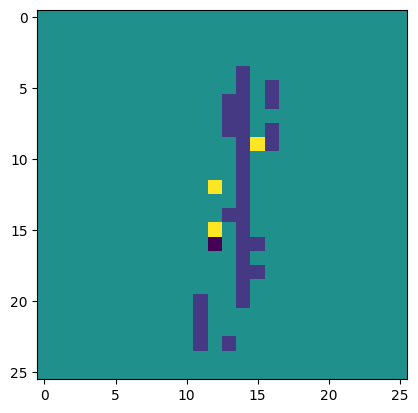

In [20]:
plt.imshow(encoded_images_combined_flat_float32[0][1])

In [21]:
labels_combined_flat.dtype, encoded_images_combined_flat_float32.dtype, original_images_combined_flat.dtype

(torch.int64, torch.float32, torch.float32)

In [22]:
labels_combined_flat.shape, encoded_images_combined_flat_float32.shape, original_images_combined_flat.shape

(torch.Size([6000]),
 torch.Size([6000, 3, 26, 26]),
 torch.Size([6000, 1, 28, 28]))

### Data-checks

In [23]:
labels_combined[0][1]

tensor(9)

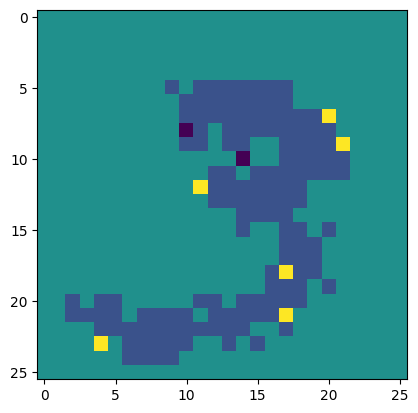

In [48]:
plt.imshow(encoded_images_combined[0][3][1])

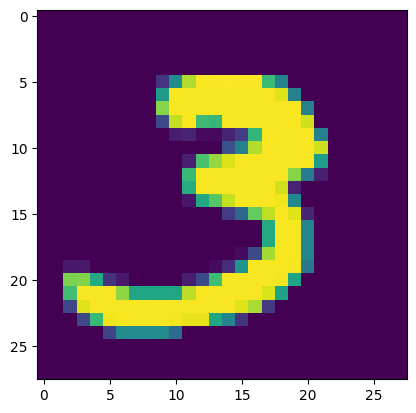

In [43]:
plt.imshow(original_images_combined[0][3][0])

## Custom DataLoader for datasets of inhomogeneous shapes

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class CombinedDataset(Dataset):
    def __init__(self, labels, image1, image2):
        """
        Args:
            labels (torch.Tensor): Tensor of shape [6000].
            image1 (torch.Tensor): Tensor of shape [6000, 3, 26, 26].
            image2 (torch.Tensor): Tensor of shape [6000, 1, 28, 28].
        """
        self.labels = labels
        self.image1 = image1
        self.image2 = image2
        
        # Ensure all datasets have the same first two dimensions
        assert self.labels.shape[0] == self.image1.shape[0] == self.image2.shape[0], \
            "Shapes of labels, image1, and image2 must match in the first two dimensions."

    def __len__(self):
        # Use the first dimension (e.g., batch size or sequence length)
        return self.labels.shape[0]

    def __getitem__(self, idx):
        # Get corresponding data for the given index
        label = self.labels[idx]
        img1 = self.image1[idx]
        img2 = self.image2[idx]

        # Return as a dictionary or tuple
        return (img1, img2, label)

# # Sample tensors to demonstrate usage
# labels = torch.randn(375, 16)        # Example tensor for labels
# image1 = torch.randn(375, 16, 9, 26, 26)  # Example tensor for image1
# image2 = torch.randn(375, 16, 1, 28, 28)  # Example tensor for image2

# # Create dataset
# dataset = CombinedDataset(labels, image1, image2)

# # Create DataLoader
# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Iterate through the DataLoader
# for batch in dataloader:
#     img1_batch, img2_batch, label_batch = batch
#     print(f"Image1 batch shape: {img1_batch.shape}")
#     print(f"Image2 batch shape: {img2_batch.shape}")
#     print(f"Labels batch shape: {label_batch.shape}")
#     break

In [27]:
# Create dataset
dataset_combined = CombinedDataset(labels_combined_flat, encoded_images_combined_flat_float32, original_images_combined_flat)

# Create DataLoader
batch_size = 16
dataloader_combined = DataLoader(dataset_combined, batch_size=batch_size, shuffle=True)

# Iterate through the DataLoader
for batch in dataloader_combined:
    img1_batch, img2_batch, label_batch = batch
    print(f"Image1 batch shape: {img1_batch.shape}")
    print(f"Image2 batch shape: {img2_batch.shape}")
    print(f"Labels batch shape: {label_batch.shape}")
    break

Image1 batch shape: torch.Size([16, 3, 26, 26])
Image2 batch shape: torch.Size([16, 1, 28, 28])
Labels batch shape: torch.Size([16])


In [28]:
from torch.utils.data import DataLoader, random_split

# Assume you have an existing dataset and dataloader
dataset = dataloader_combined.dataset  # Extract the dataset from the existing dataloader
total_size = len(dataset)     # Get the total number of samples
train_ratio = 0.8             # Define the ratio of train to test data

# Calculate sizes for train and test splits
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Randomly split the dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders for train and test datasets
train_loader_combined = DataLoader(train_dataset, batch_size=dataloader_combined.batch_size, shuffle=True)
test_loader_combined = DataLoader(test_dataset, batch_size=dataloader_combined.batch_size, shuffle=False)

# Print the sizes to confirm
print(f"Train dataset size: {len(train_loader_combined)}")
print(f"Test dataset size: {len(test_loader_combined)}")

Train dataset size: 300
Test dataset size: 75


## Model Definition

In [ ]:
class PQK_CNN(nn.Module):
    def __init__(self, device):
        super().__init__()

        self.embedding_size = None
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()

        self.conv1_classical = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool_classical = nn.MaxPool2d(2, 2)
        self.conv2_classical = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten_classical = nn.Flatten()

        fc_input_size = 64 * (6 * 6 + 7 * 7)

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

        self.drop = nn.Dropout(0.4)

        self.device = device

    def forward(self, x_PQK, x_CNN):
        x1 = self.pool(F.relu(self.conv1(x_PQK)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.flatten(x2)

        x1_classical = self.pool_classical(F.relu(self.conv1_classical(x_CNN)))
        x2_classical = self.pool_classical(F.relu(self.conv2_classical(x1_classical)))
        x3_classical = self.flatten_classical(x2_classical)

        x3 = torch.cat((x3, x3_classical), dim=1)

        x4 = F.relu(self.fc1(x3))
        x5 = self.drop(F.relu(self.fc2(x4)))
        x6 = self.drop(F.relu(self.fc3(x5)))
        x7 = self.fc4(x6)

        return x7
    
    def training_step(self, batch_PQK, batch_classical, labels):
        images =  batch_PQK
        images = images.to(self.device)
        labels = labels.to(self.device)
        batch_classical = batch_classical.to(self.device)

        out = self(images, batch_classical)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return loss, acc
    
    def validation_step(self, batch_PQK, batch_classical, labels):
        images = batch_PQK
        images, labels, batch_classical = images.to(self.device), labels.to(self.device), batch_classical.to(self.device)
        out = self(images, batch_classical) ## Generate predictions
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return({'val_loss':loss, 'val_acc': acc})
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        return result['val_loss'], result['val_acc']

In [30]:
model_PQK_CNN = PQK_CNN(device=device)

device: mps
model shifted to device: mps
optimizer shifted to device: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


100%|██████████| 300/300 [00:04<00:00, 64.99it/s] 


Epoch [0], val_loss: 2.2998, val_acc: 0.1058


100%|██████████| 300/300 [00:02<00:00, 107.61it/s]


Epoch [1], val_loss: 2.2950, val_acc: 0.1850


100%|██████████| 300/300 [00:03<00:00, 95.12it/s] 


Epoch [2], val_loss: 2.2898, val_acc: 0.2383


100%|██████████| 300/300 [00:02<00:00, 116.80it/s]


Epoch [3], val_loss: 2.2829, val_acc: 0.2400


100%|██████████| 300/300 [00:03<00:00, 91.13it/s] 


Epoch [4], val_loss: 2.2729, val_acc: 0.2650


100%|██████████| 300/300 [00:03<00:00, 99.66it/s] 


Epoch [5], val_loss: 2.2480, val_acc: 0.3167


100%|██████████| 300/300 [00:02<00:00, 113.24it/s]


Epoch [6], val_loss: 2.1901, val_acc: 0.3700


100%|██████████| 300/300 [00:02<00:00, 127.46it/s]


Epoch [7], val_loss: 1.9216, val_acc: 0.4100


100%|██████████| 300/300 [00:02<00:00, 131.41it/s]


Epoch [8], val_loss: 1.3776, val_acc: 0.5033


100%|██████████| 300/300 [00:02<00:00, 117.67it/s]


Epoch [9], val_loss: 1.0278, val_acc: 0.6625


100%|██████████| 300/300 [00:02<00:00, 127.73it/s]


Epoch [10], val_loss: 0.8342, val_acc: 0.7275


100%|██████████| 300/300 [00:02<00:00, 110.95it/s]


Epoch [11], val_loss: 0.7008, val_acc: 0.7883


100%|██████████| 300/300 [00:02<00:00, 105.17it/s]


Epoch [12], val_loss: 0.6616, val_acc: 0.7808


100%|██████████| 300/300 [00:02<00:00, 129.37it/s]


Epoch [13], val_loss: 0.5482, val_acc: 0.8242


100%|██████████| 300/300 [00:02<00:00, 130.22it/s]


Epoch [14], val_loss: 0.5318, val_acc: 0.8425


100%|██████████| 300/300 [00:02<00:00, 102.24it/s]


Epoch [15], val_loss: 0.4618, val_acc: 0.8592


100%|██████████| 300/300 [00:02<00:00, 123.08it/s]


Epoch [16], val_loss: 0.5037, val_acc: 0.8300


100%|██████████| 300/300 [00:02<00:00, 124.92it/s]


Epoch [17], val_loss: 0.4710, val_acc: 0.8575


100%|██████████| 300/300 [00:02<00:00, 132.85it/s]


Epoch [18], val_loss: 0.4303, val_acc: 0.8675


100%|██████████| 300/300 [00:02<00:00, 115.68it/s]


Epoch [19], val_loss: 0.3533, val_acc: 0.8817


100%|██████████| 300/300 [00:02<00:00, 134.95it/s]
/Users/soardr/Perceval 2/Percevel-main/utils.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,2,figsize = (15,5))


Epoch [20], val_loss: 0.3709, val_acc: 0.8917


100%|██████████| 300/300 [00:03<00:00, 96.40it/s] 


Epoch [21], val_loss: 0.3445, val_acc: 0.8908


100%|██████████| 300/300 [00:03<00:00, 80.15it/s] 


Epoch [22], val_loss: 0.3407, val_acc: 0.9000


100%|██████████| 300/300 [00:02<00:00, 114.48it/s]


Epoch [23], val_loss: 0.3537, val_acc: 0.8850


100%|██████████| 300/300 [00:02<00:00, 125.80it/s]


Epoch [24], val_loss: 0.2850, val_acc: 0.9067


100%|██████████| 300/300 [00:02<00:00, 112.92it/s]


Epoch [25], val_loss: 0.2880, val_acc: 0.9167


100%|██████████| 300/300 [00:02<00:00, 121.51it/s]


Epoch [26], val_loss: 0.2589, val_acc: 0.9200


100%|██████████| 300/300 [00:02<00:00, 112.00it/s]


Epoch [27], val_loss: 0.2616, val_acc: 0.9300


100%|██████████| 300/300 [00:02<00:00, 110.75it/s]


Epoch [28], val_loss: 0.2445, val_acc: 0.9308


100%|██████████| 300/300 [00:02<00:00, 123.84it/s]


Epoch [29], val_loss: 0.2863, val_acc: 0.9167


100%|██████████| 300/300 [00:02<00:00, 104.30it/s]


Epoch [30], val_loss: 0.2571, val_acc: 0.9225


100%|██████████| 300/300 [00:02<00:00, 110.51it/s]


Epoch [31], val_loss: 0.2371, val_acc: 0.9325


100%|██████████| 300/300 [00:02<00:00, 109.93it/s]


Epoch [32], val_loss: 0.2484, val_acc: 0.9258


100%|██████████| 300/300 [00:02<00:00, 102.63it/s]


Epoch [33], val_loss: 0.2561, val_acc: 0.9208


100%|██████████| 300/300 [00:02<00:00, 127.27it/s]


Epoch [34], val_loss: 0.2094, val_acc: 0.9325


100%|██████████| 300/300 [00:02<00:00, 134.64it/s]


Epoch [35], val_loss: 0.1925, val_acc: 0.9392


100%|██████████| 300/300 [00:02<00:00, 137.83it/s]


Epoch [36], val_loss: 0.2523, val_acc: 0.9317


100%|██████████| 300/300 [00:02<00:00, 128.57it/s]


Epoch [37], val_loss: 0.2007, val_acc: 0.9383


100%|██████████| 300/300 [00:02<00:00, 124.50it/s]


Epoch [38], val_loss: 0.2395, val_acc: 0.9342


100%|██████████| 300/300 [00:02<00:00, 113.33it/s]


Epoch [39], val_loss: 0.2027, val_acc: 0.9400


100%|██████████| 300/300 [00:02<00:00, 129.57it/s]


Epoch [40], val_loss: 0.2121, val_acc: 0.9267


100%|██████████| 300/300 [00:02<00:00, 110.38it/s]


Epoch [41], val_loss: 0.1991, val_acc: 0.9383


100%|██████████| 300/300 [00:02<00:00, 122.83it/s]


Epoch [42], val_loss: 0.2097, val_acc: 0.9317


100%|██████████| 300/300 [00:02<00:00, 127.92it/s]


Epoch [43], val_loss: 0.1924, val_acc: 0.9358


100%|██████████| 300/300 [00:02<00:00, 126.32it/s]


Epoch [44], val_loss: 0.1889, val_acc: 0.9508


100%|██████████| 300/300 [00:02<00:00, 123.46it/s]


Epoch [45], val_loss: 0.2023, val_acc: 0.9325


100%|██████████| 300/300 [00:02<00:00, 120.75it/s]


Epoch [46], val_loss: 0.1973, val_acc: 0.9392


100%|██████████| 300/300 [00:02<00:00, 133.73it/s]


Epoch [47], val_loss: 0.1865, val_acc: 0.9425


100%|██████████| 300/300 [00:02<00:00, 123.01it/s]


Epoch [48], val_loss: 0.1870, val_acc: 0.9483


100%|██████████| 300/300 [00:02<00:00, 122.12it/s]


Epoch [49], val_loss: 0.1898, val_acc: 0.9542


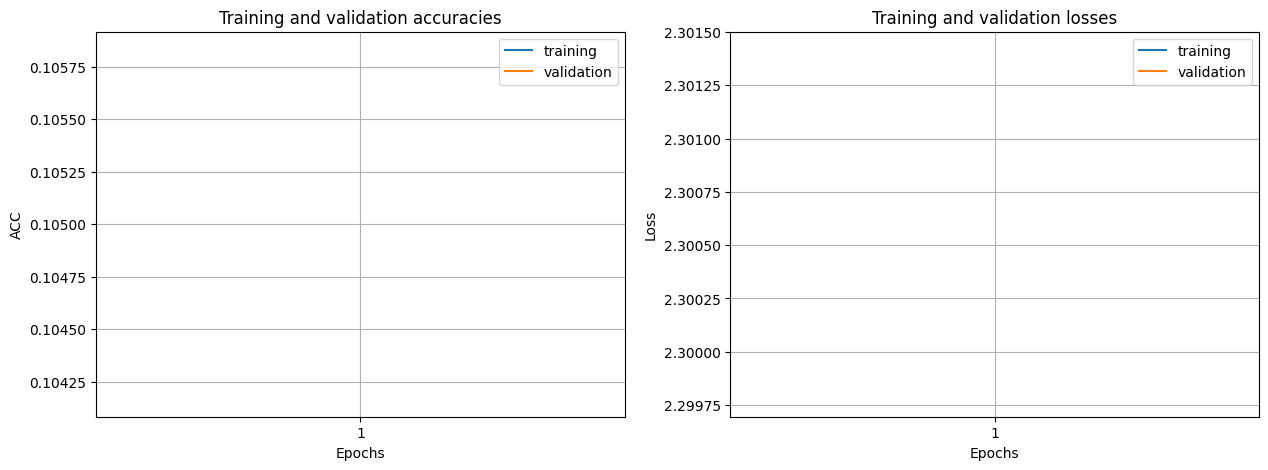

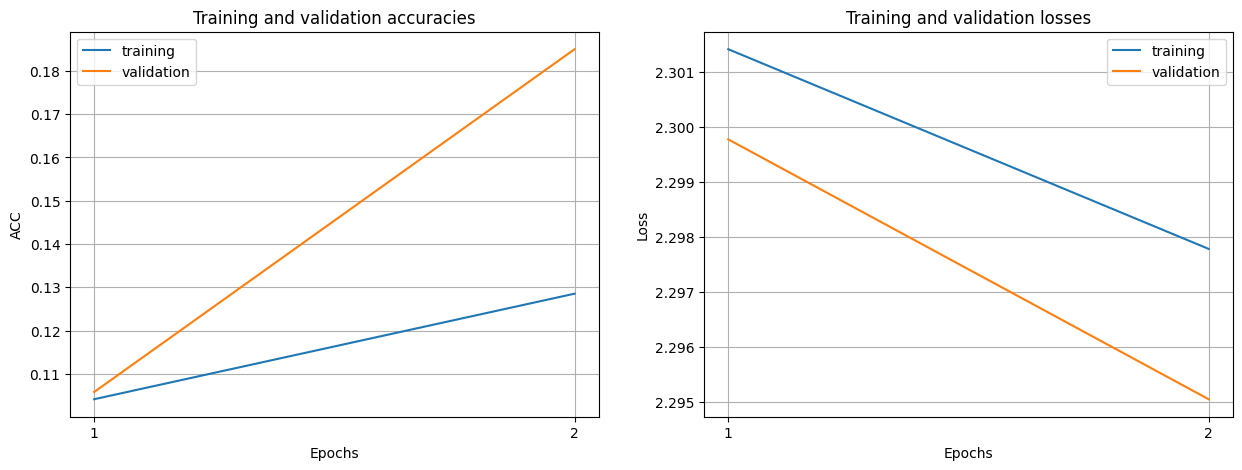

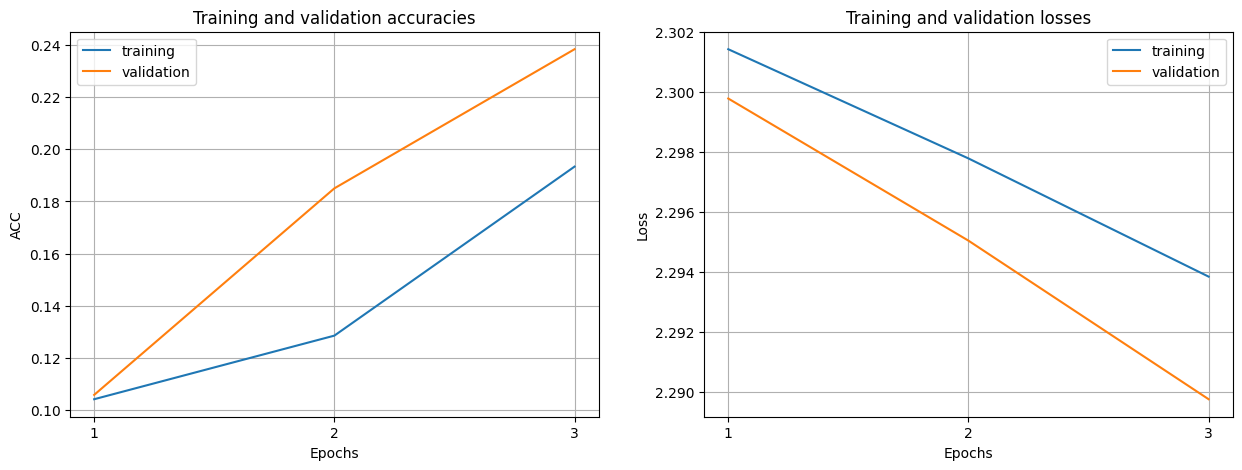

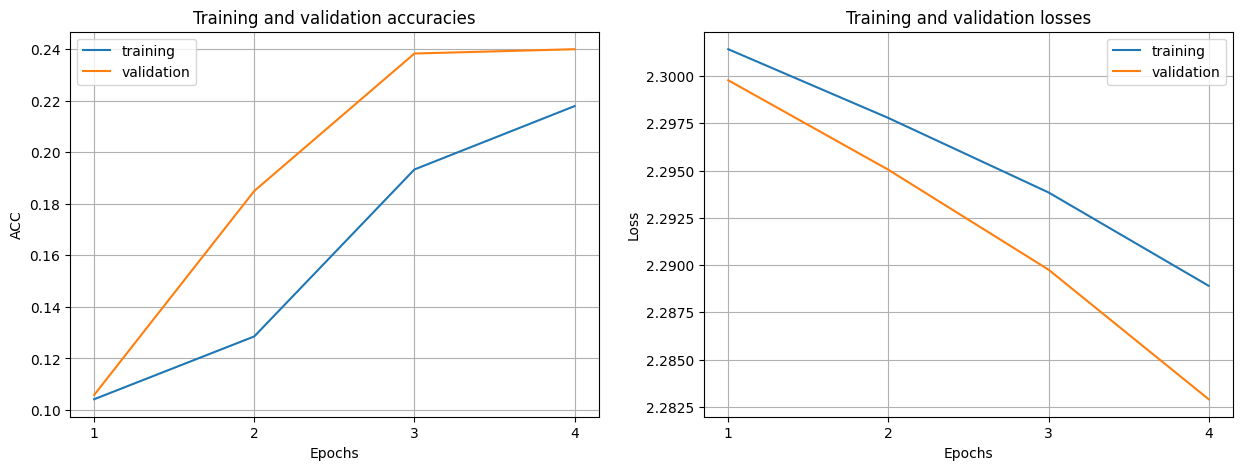

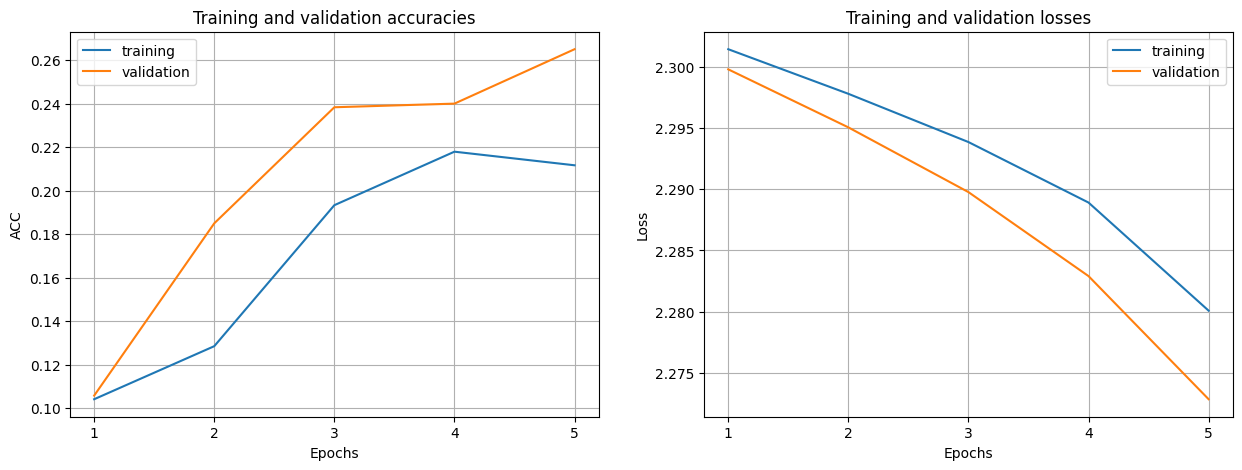

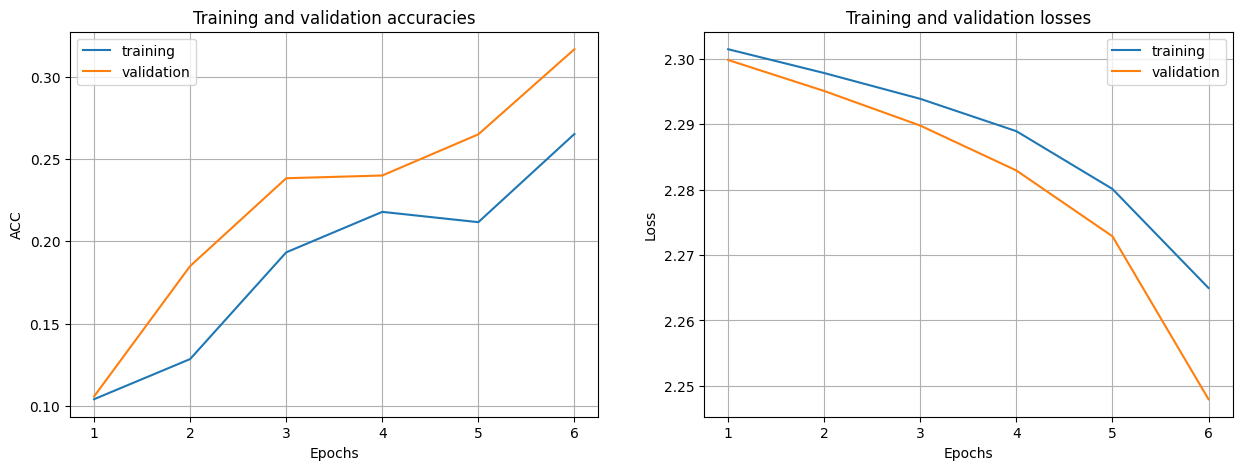

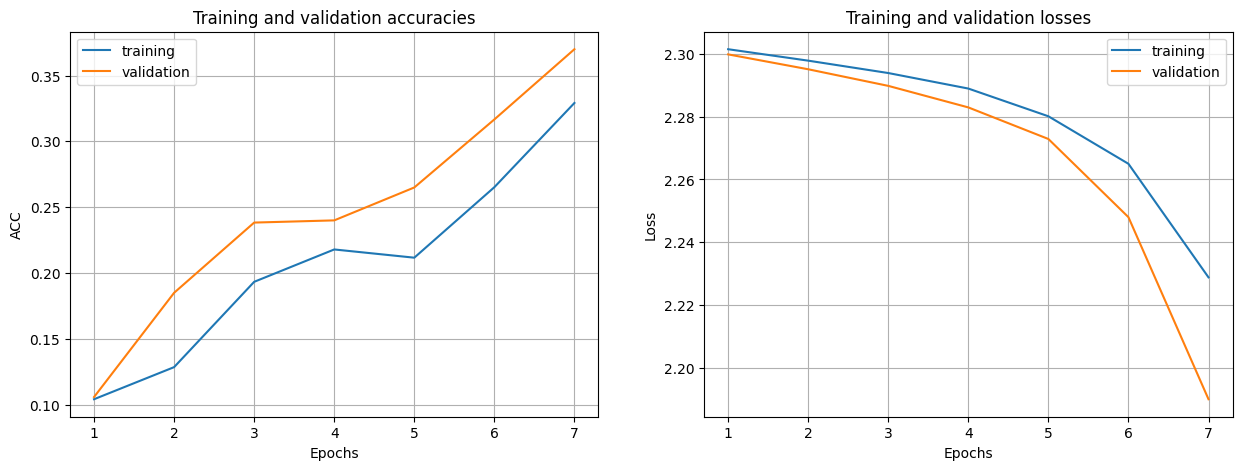

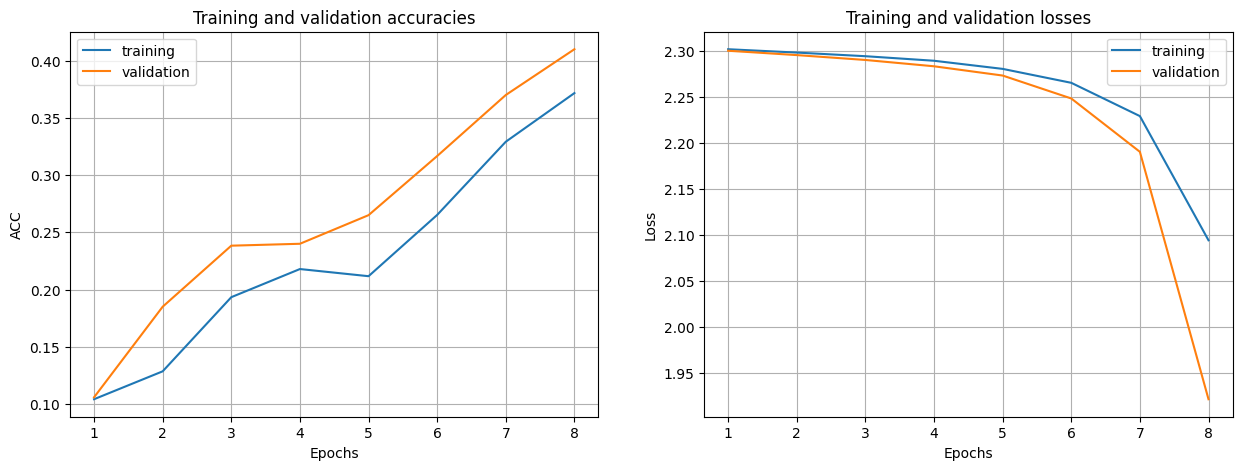

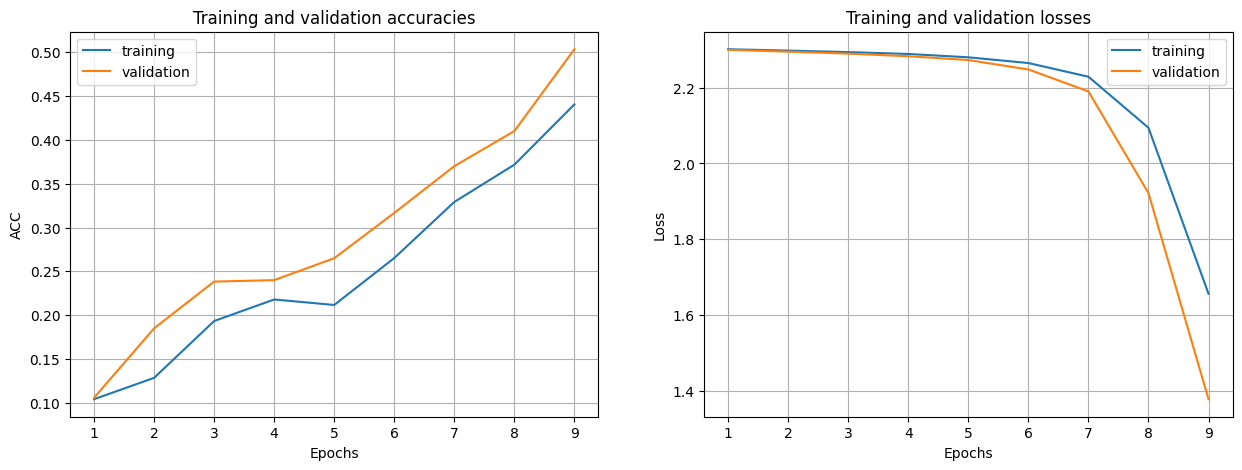

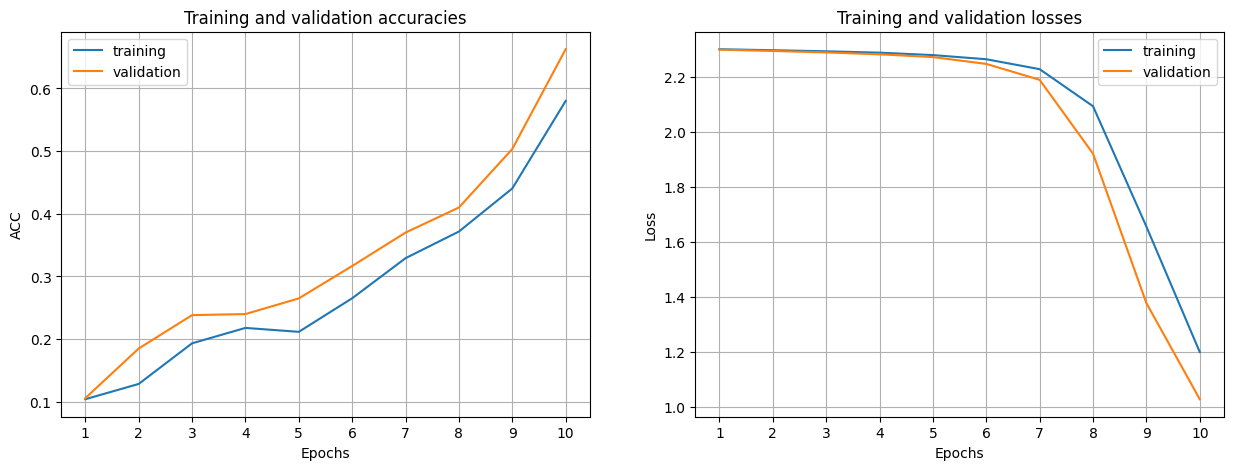

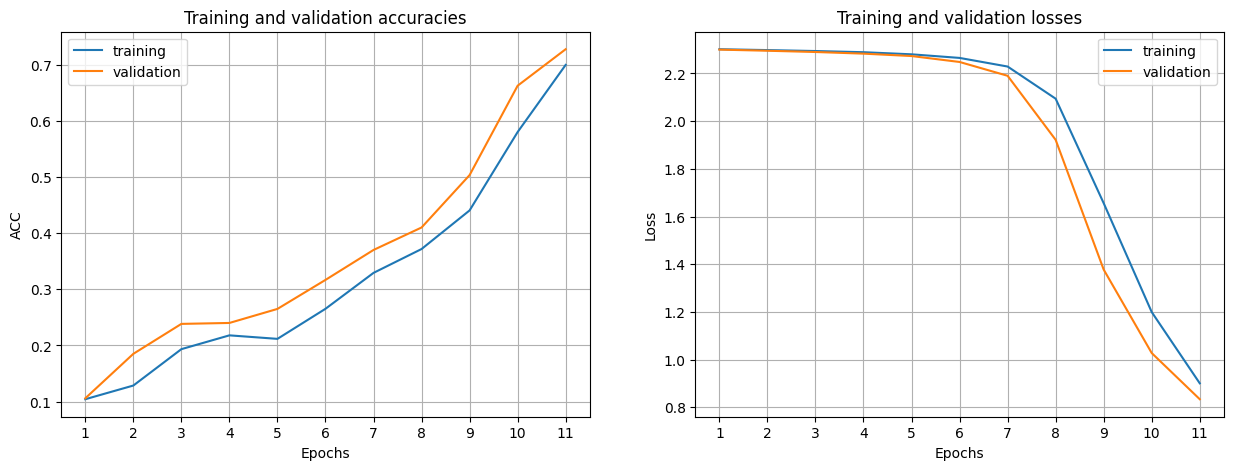

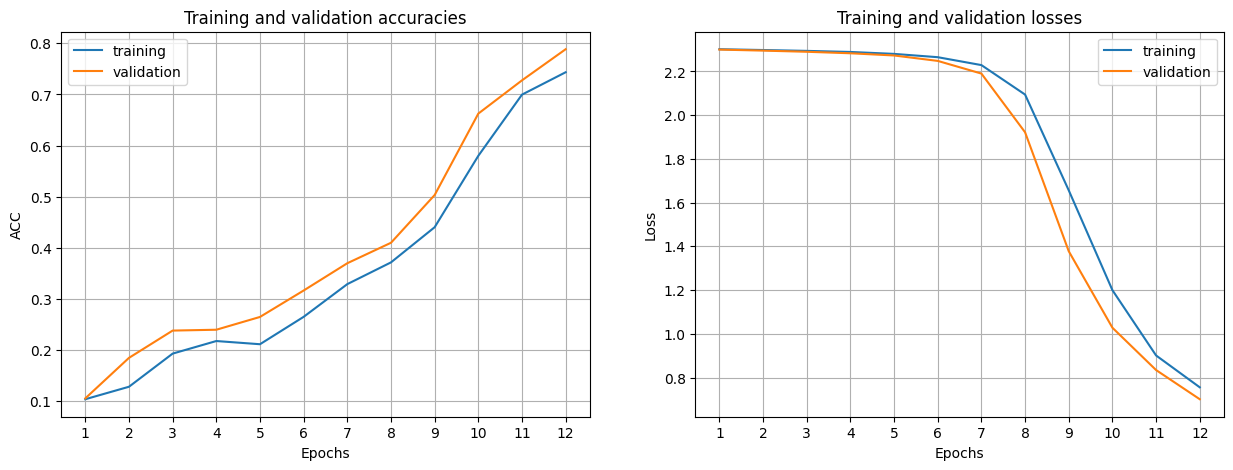

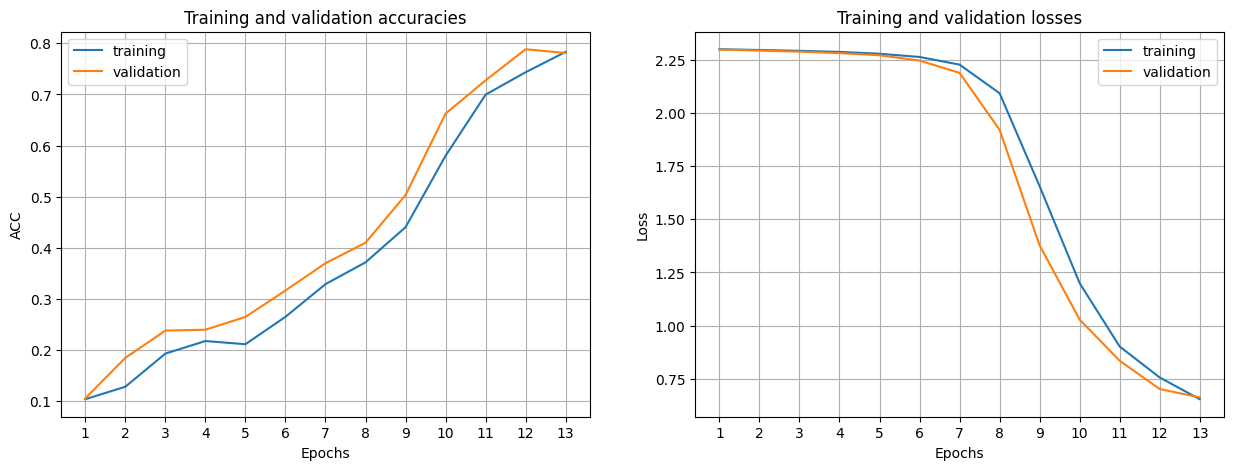

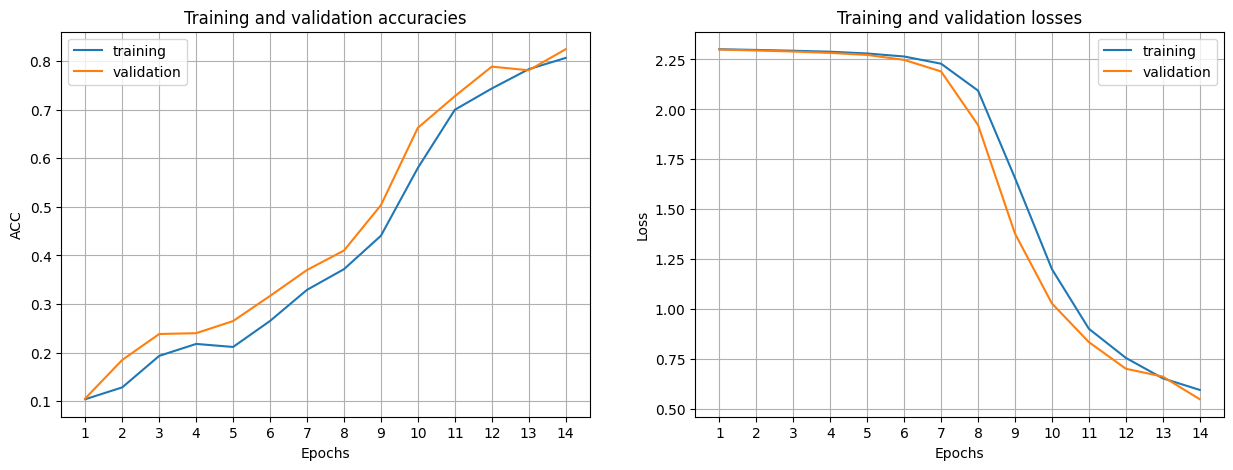

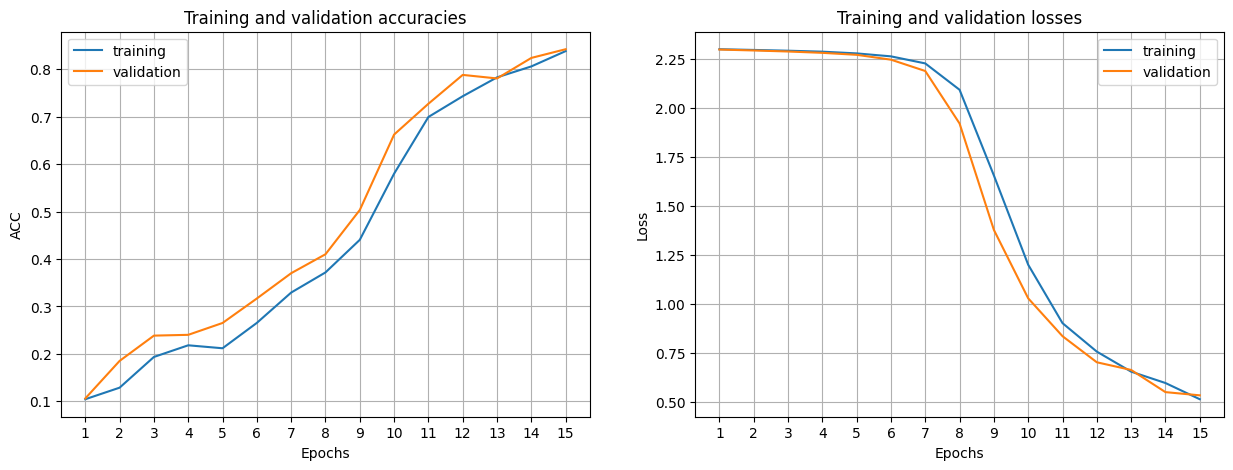

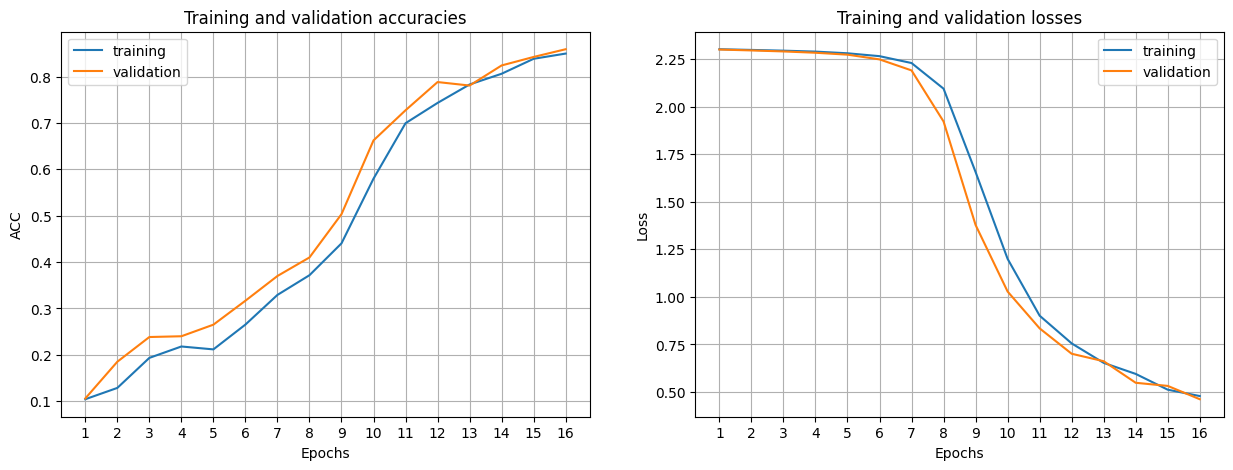

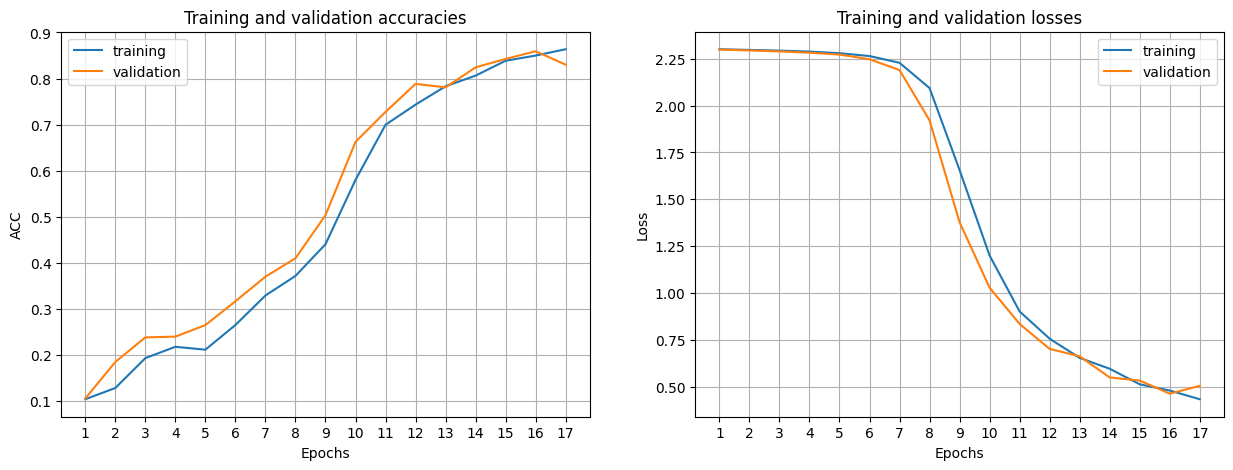

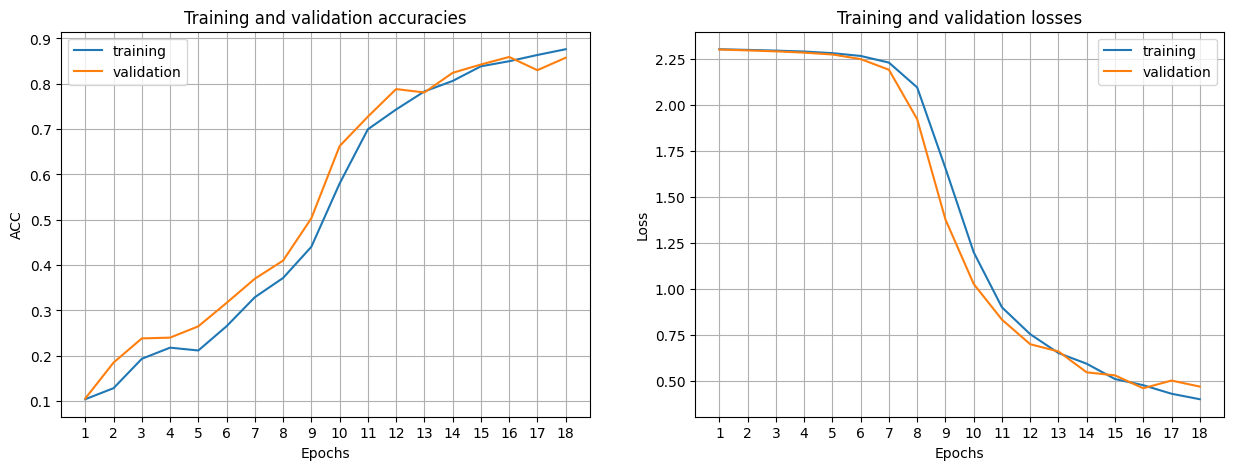

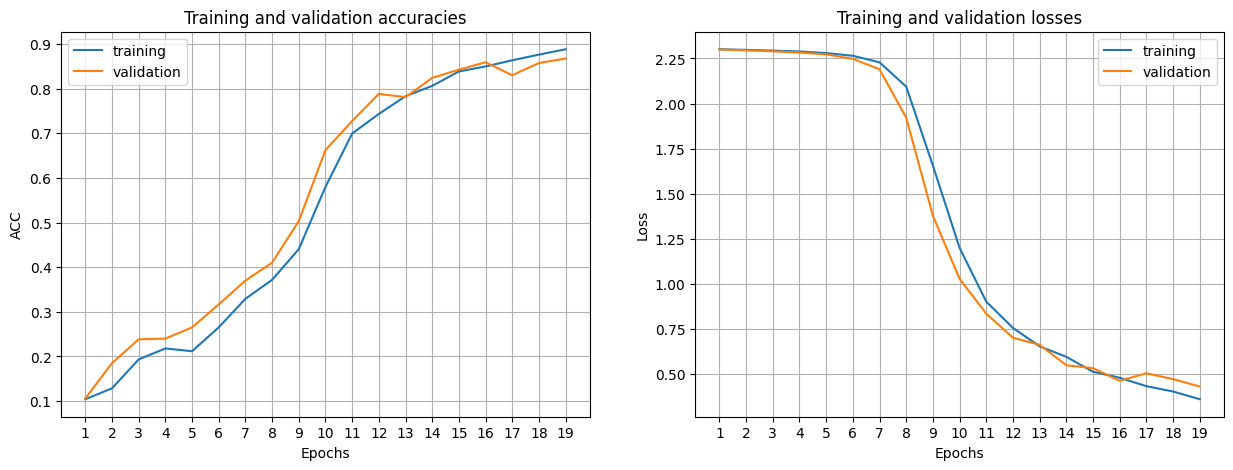

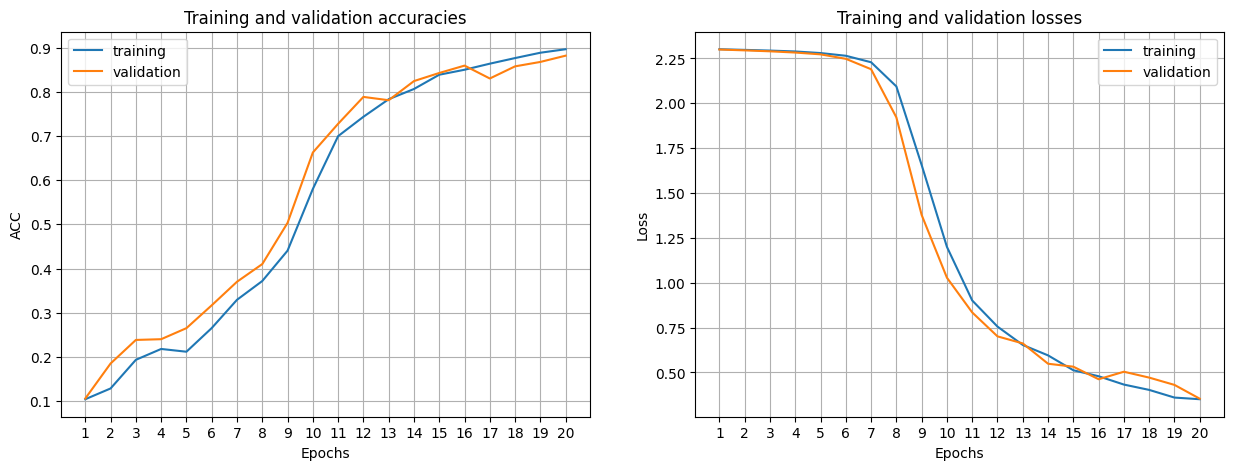

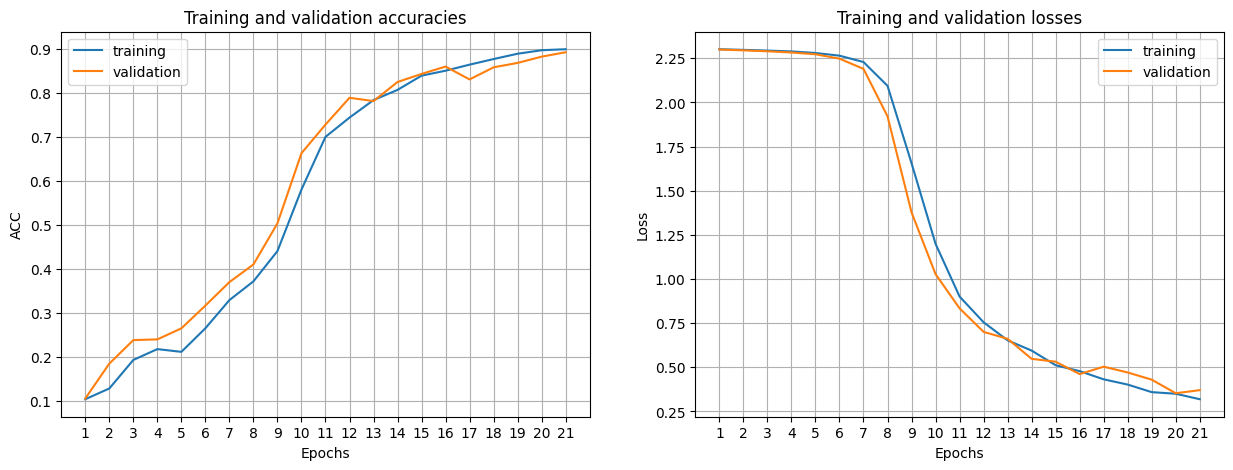

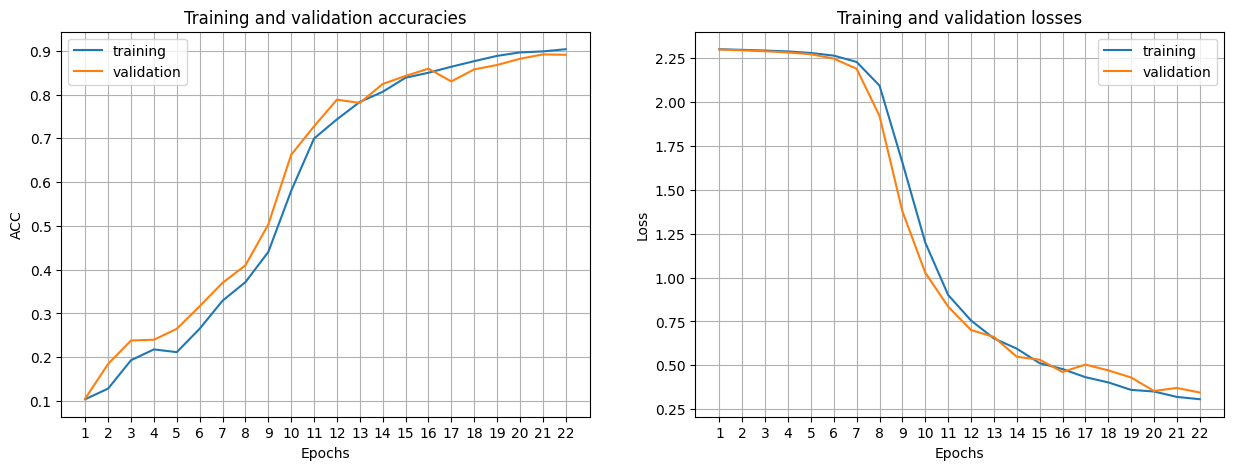

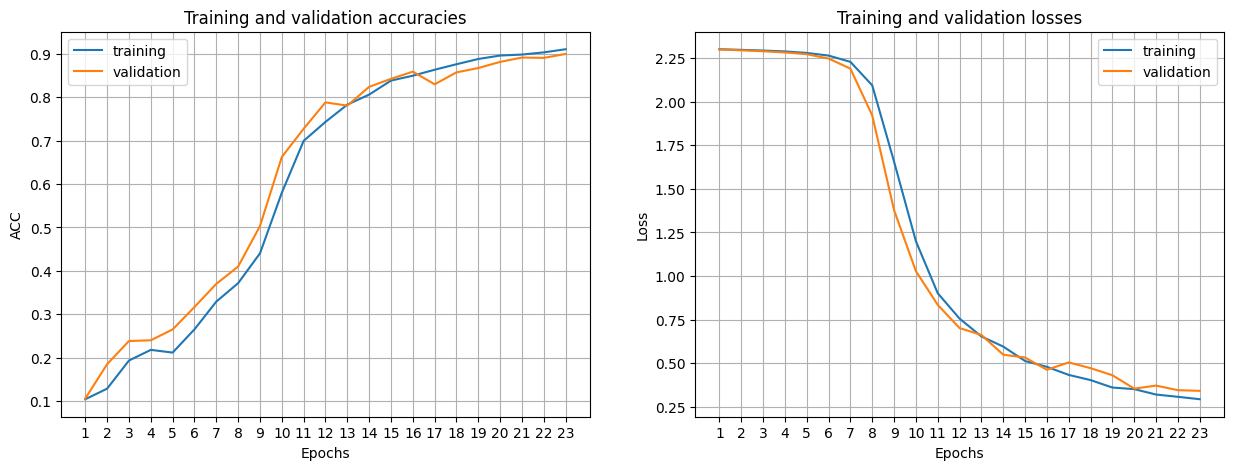

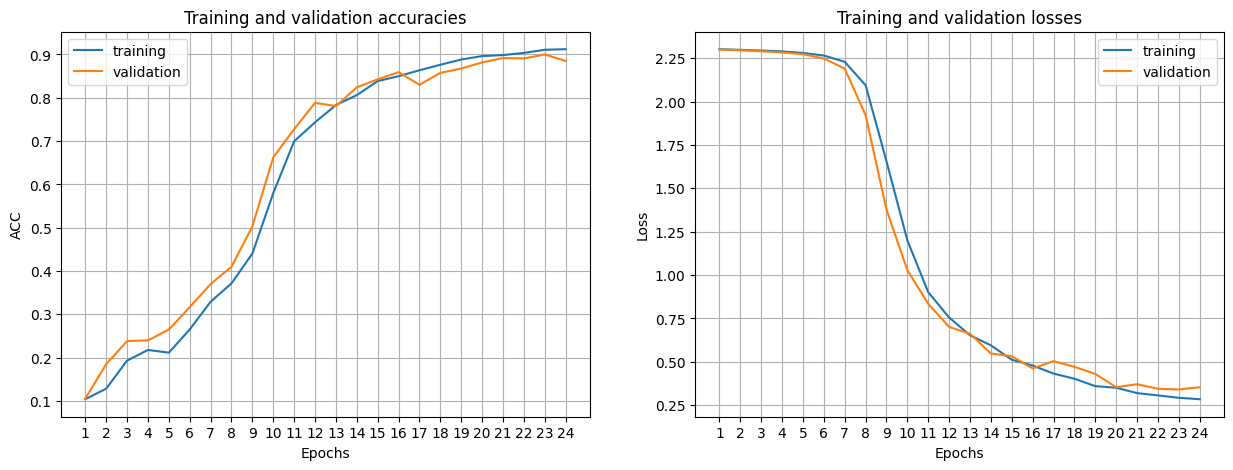

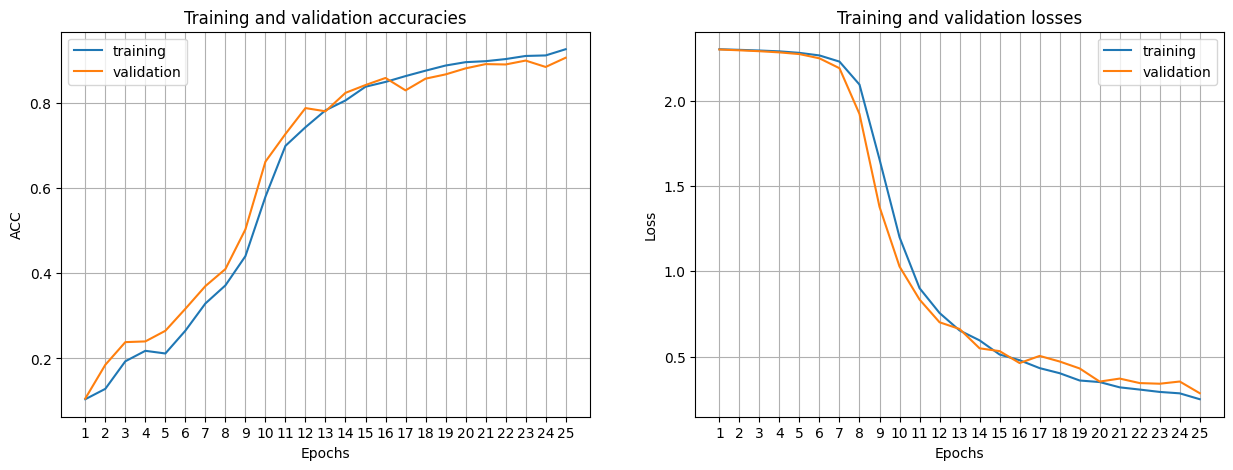

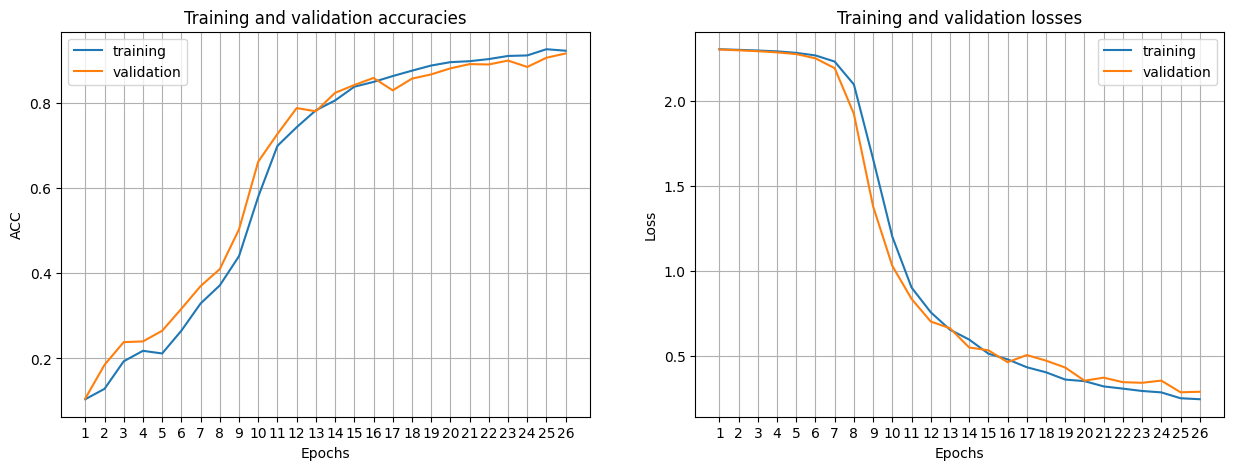

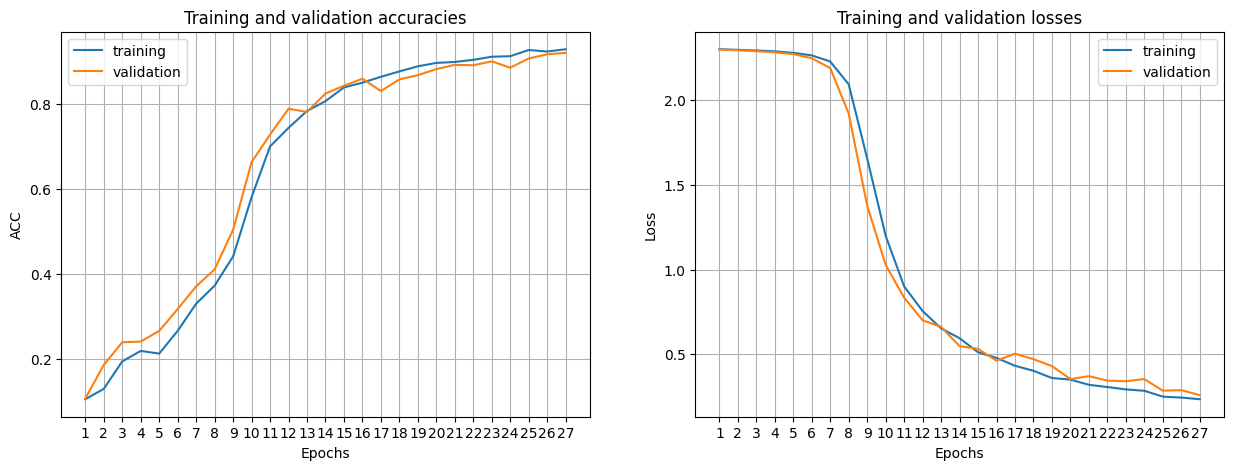

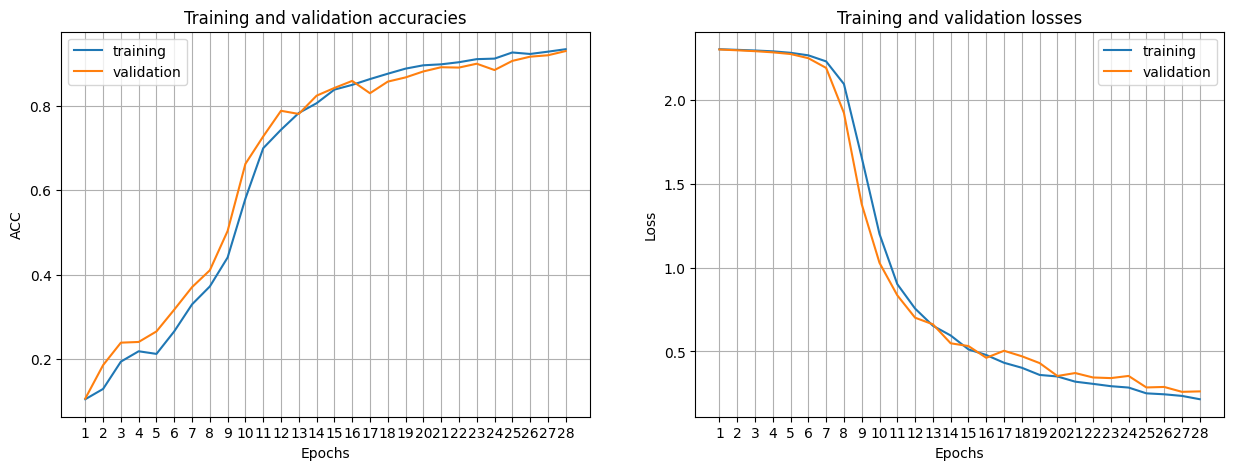

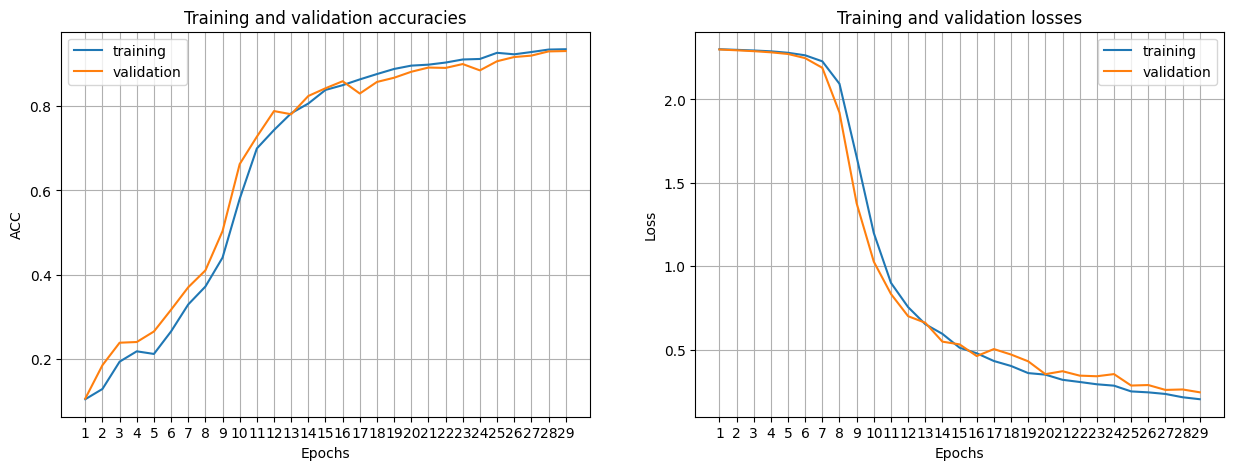

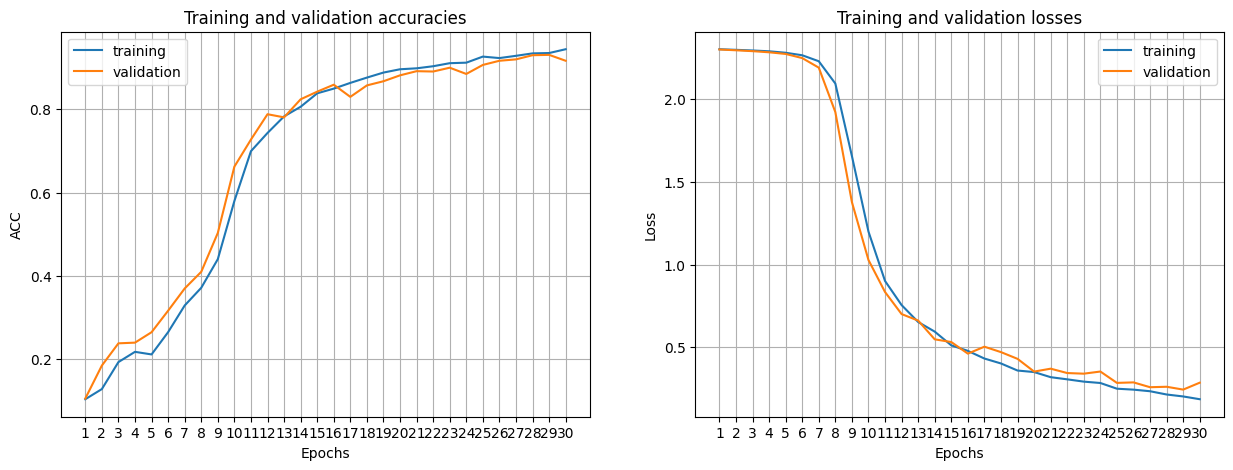

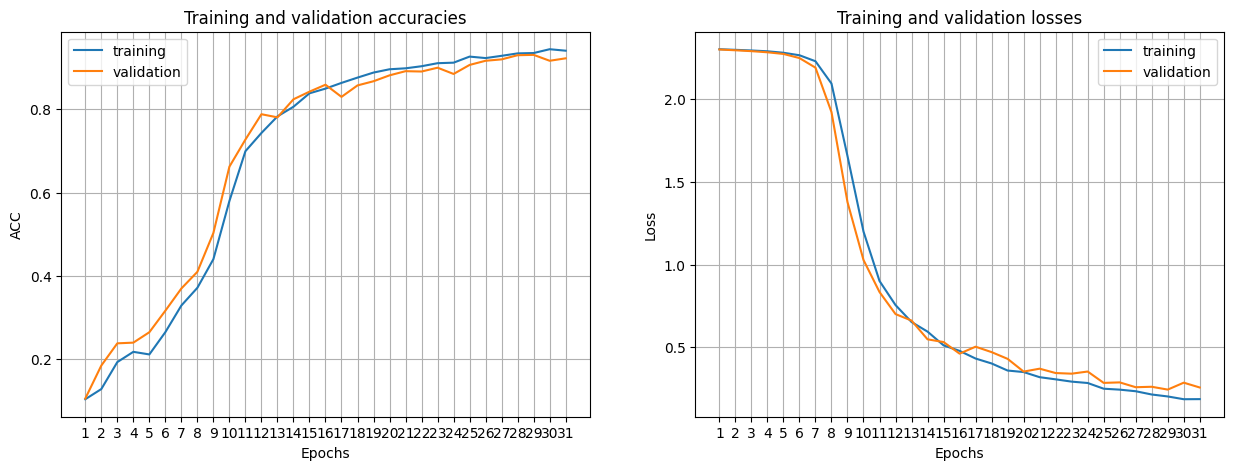

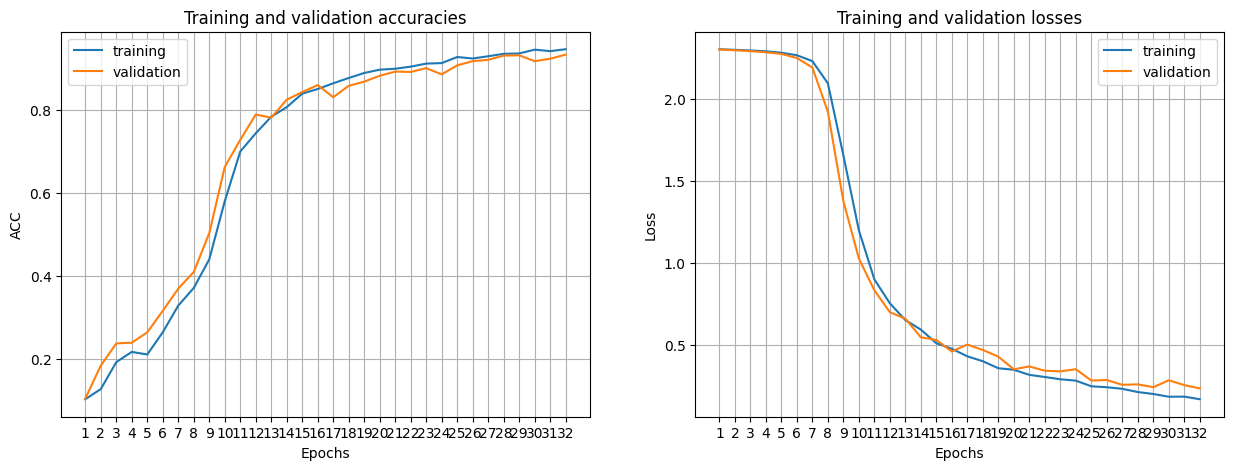

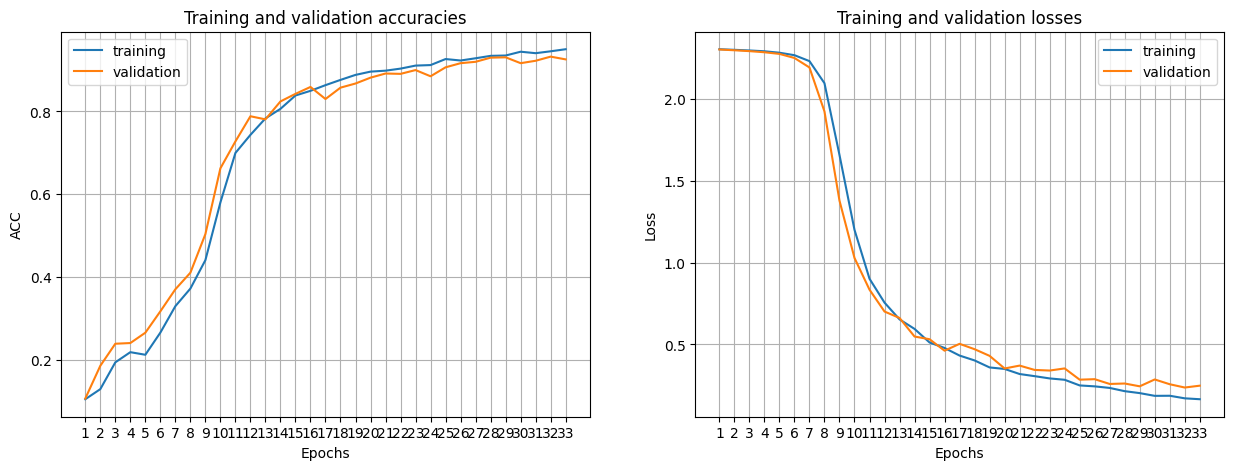

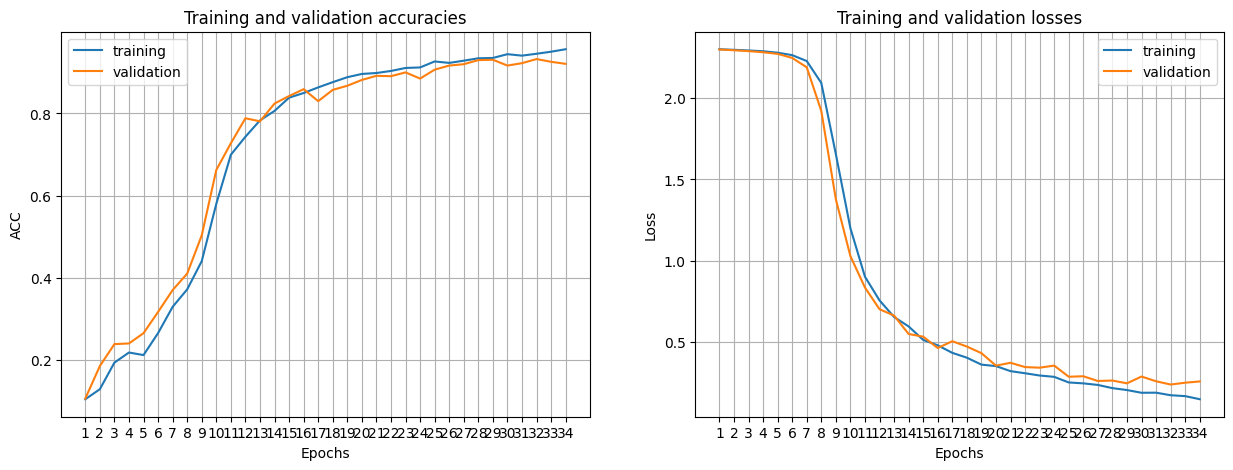

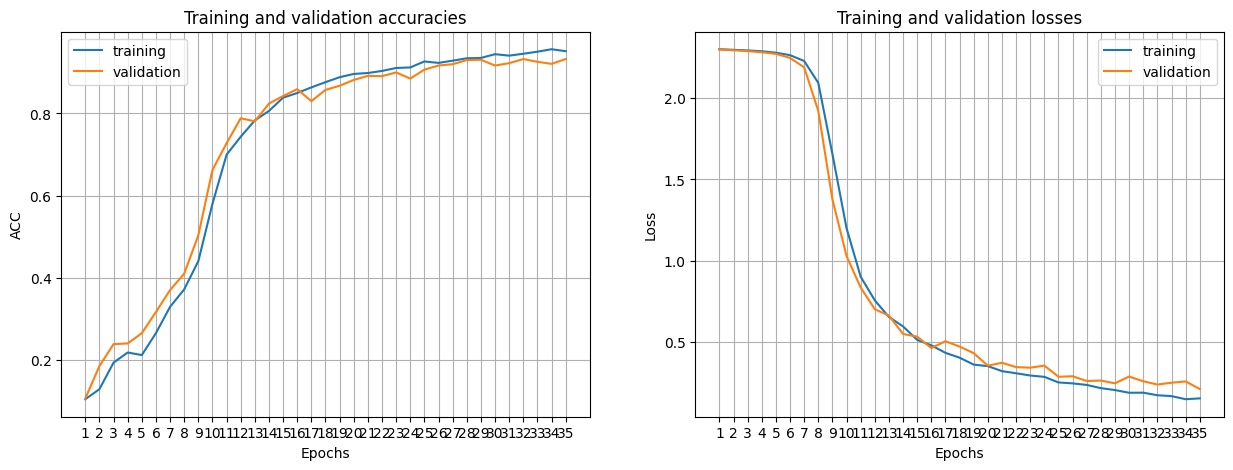

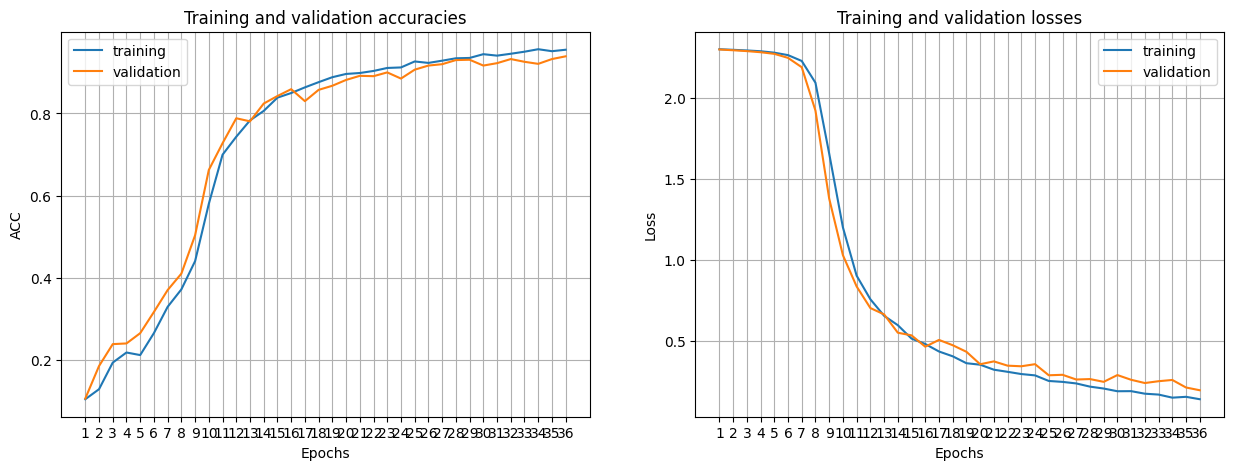

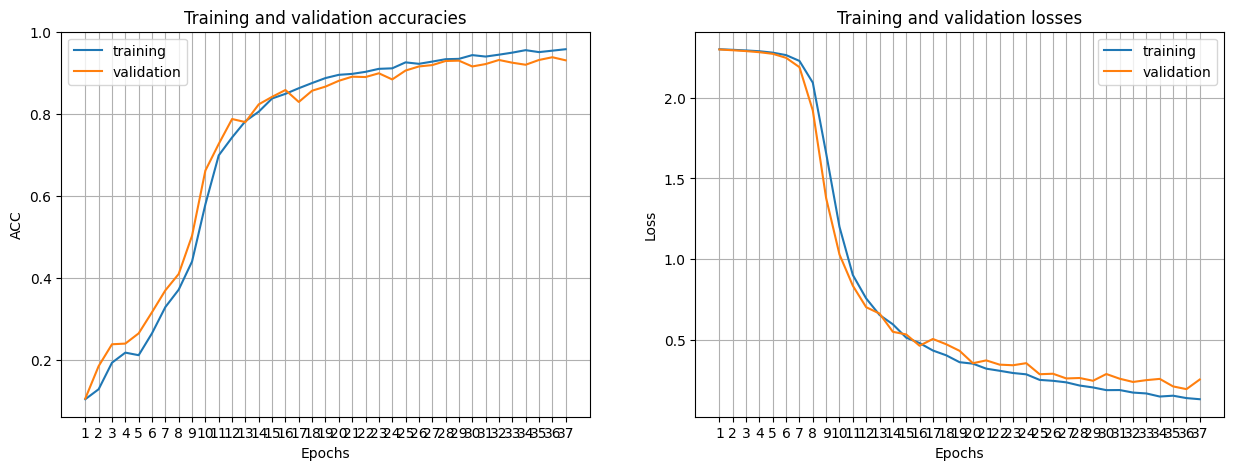

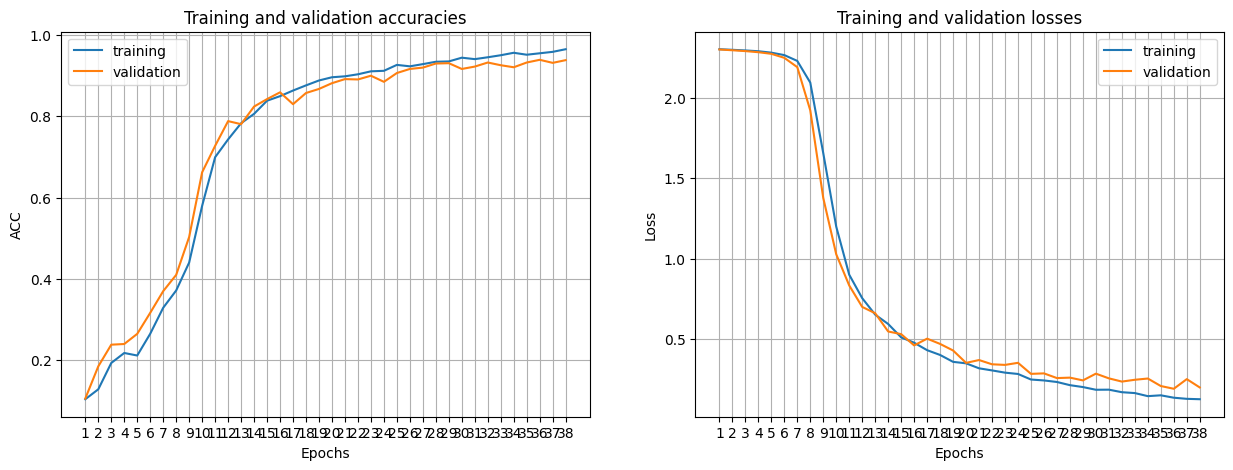

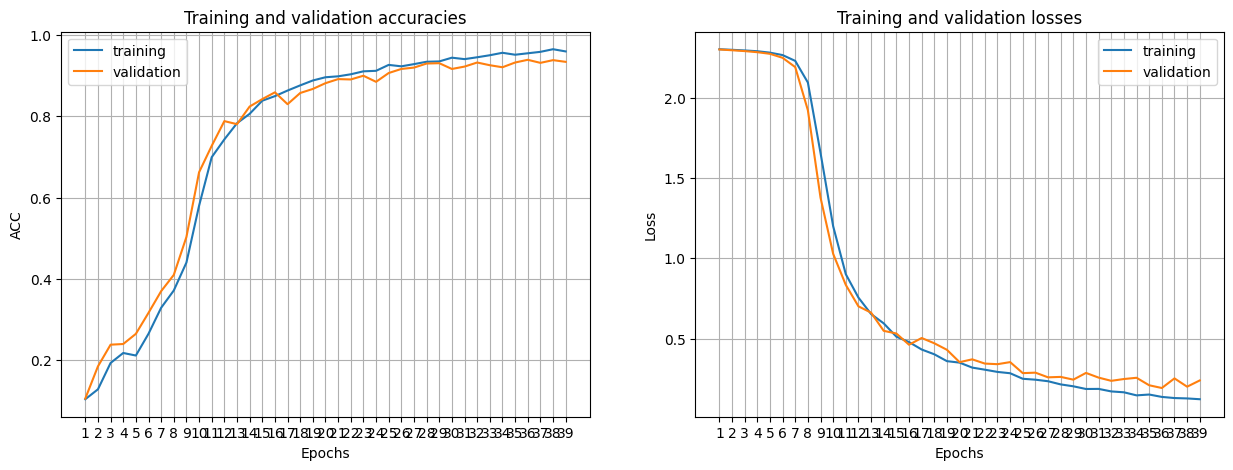

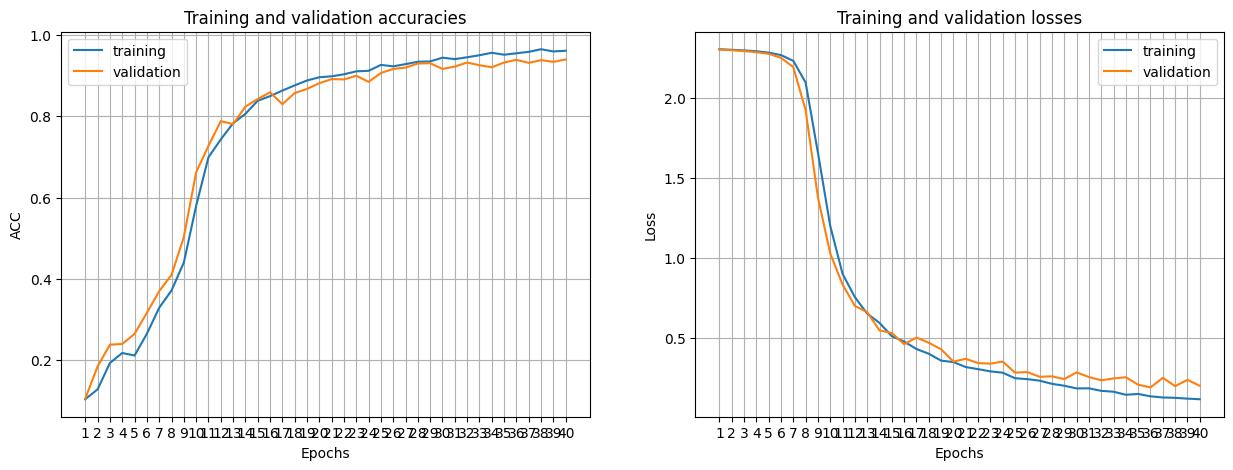

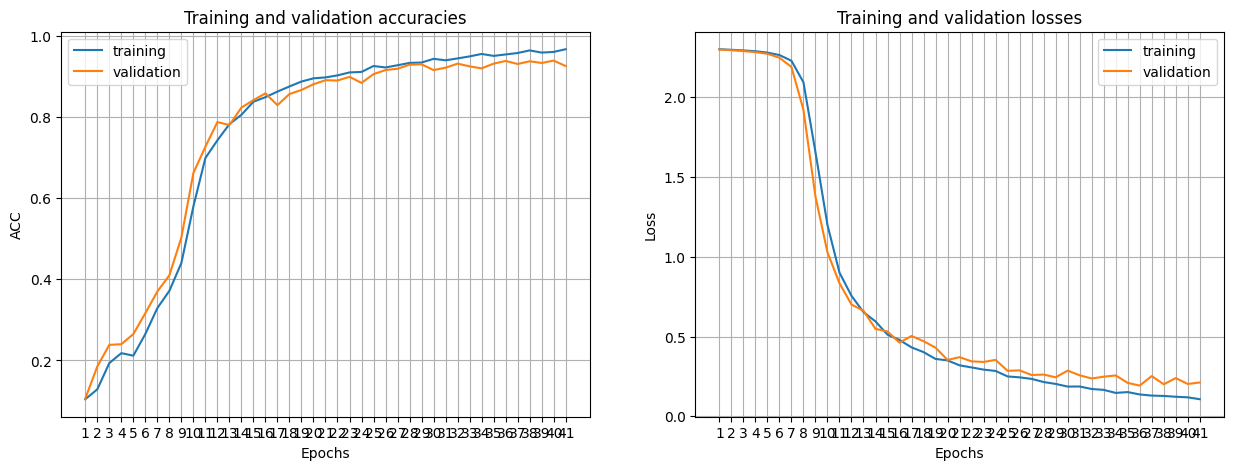

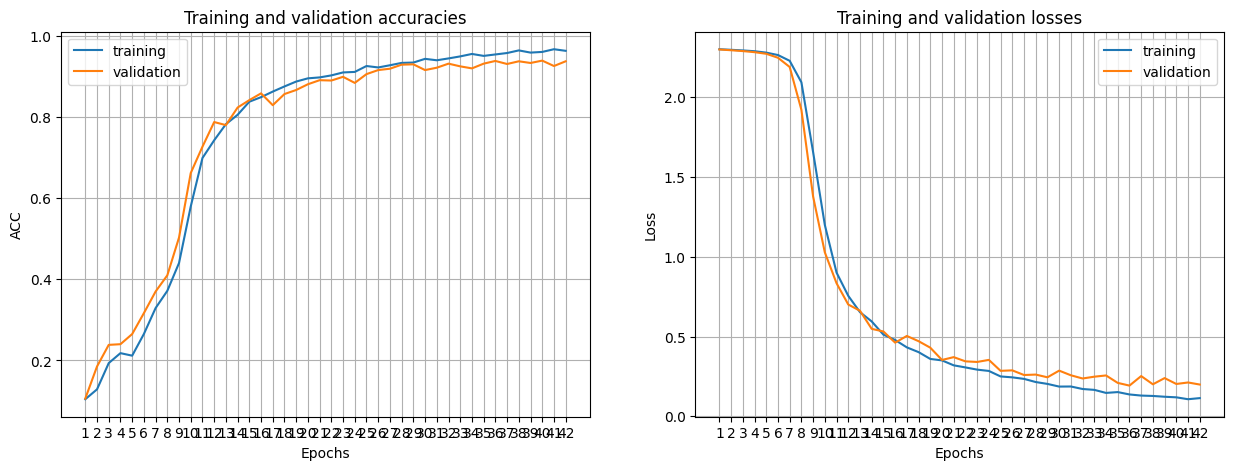

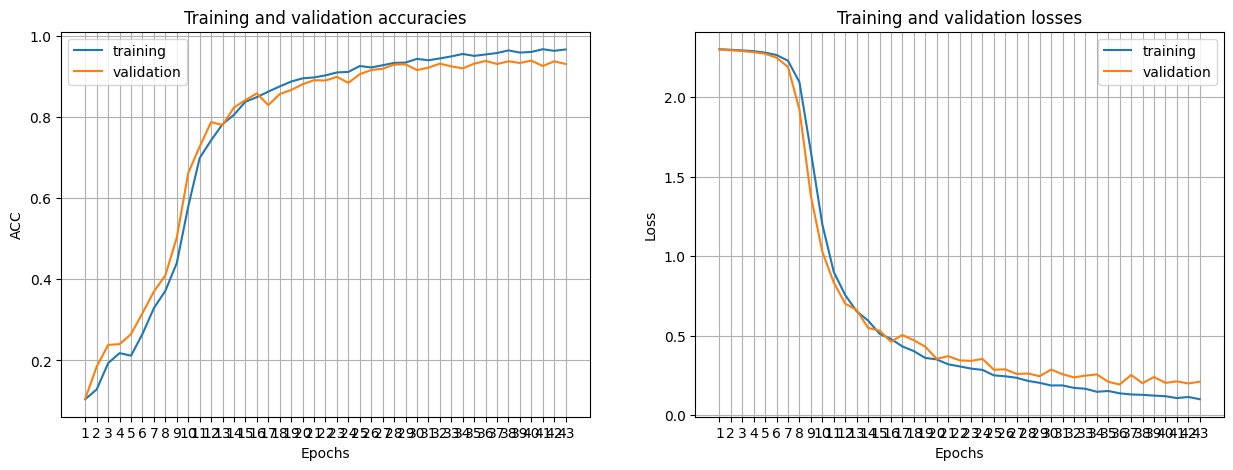

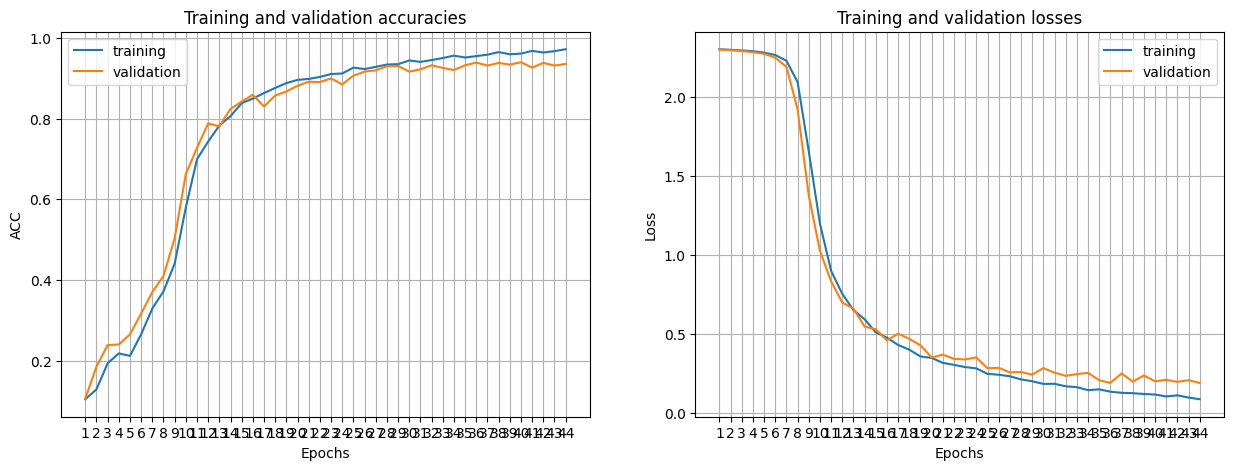

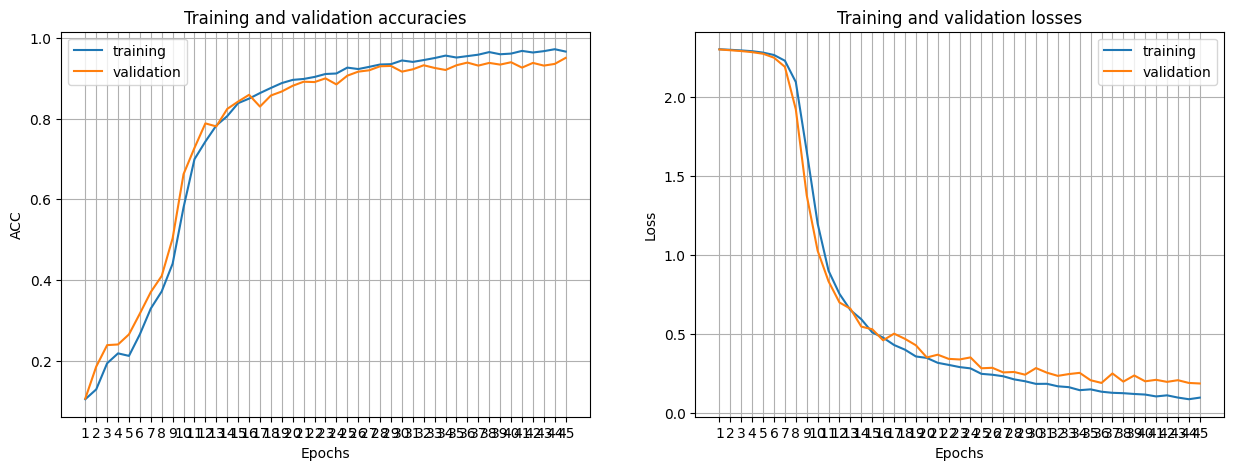

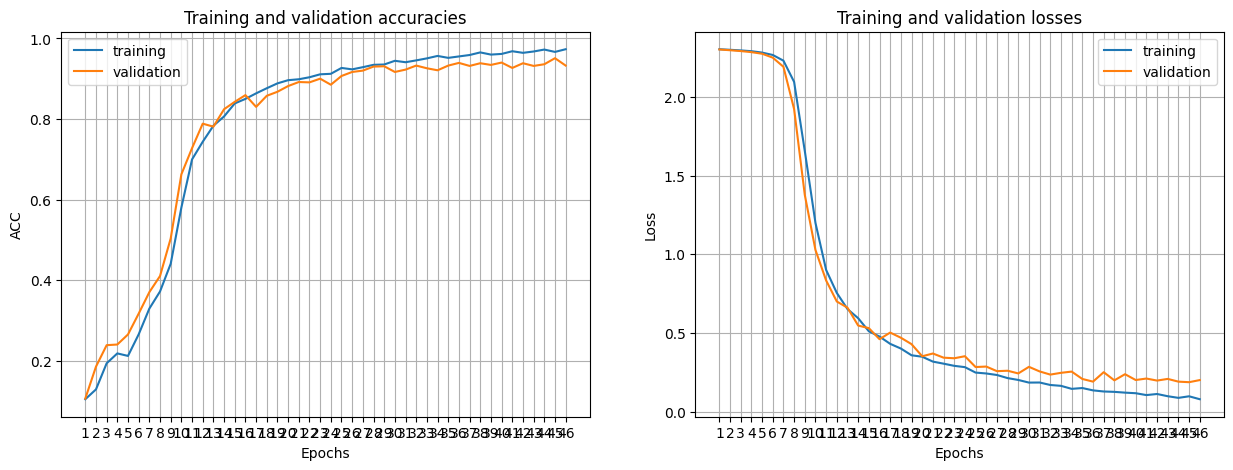

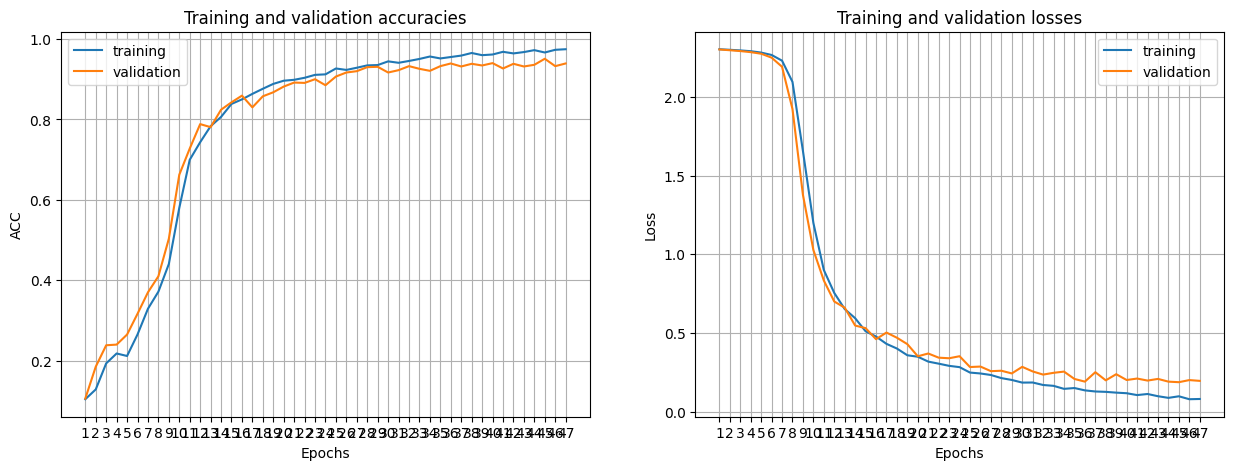

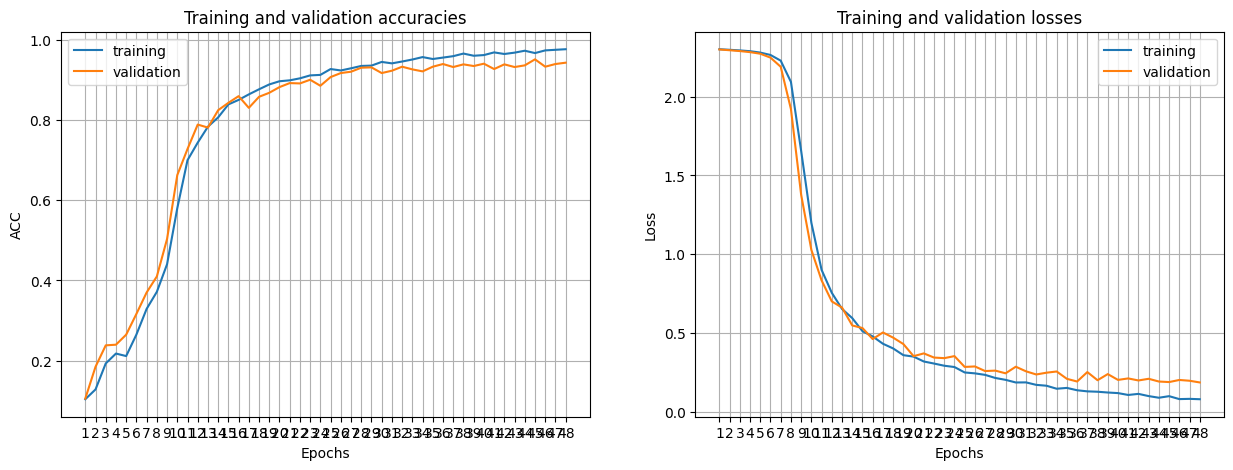

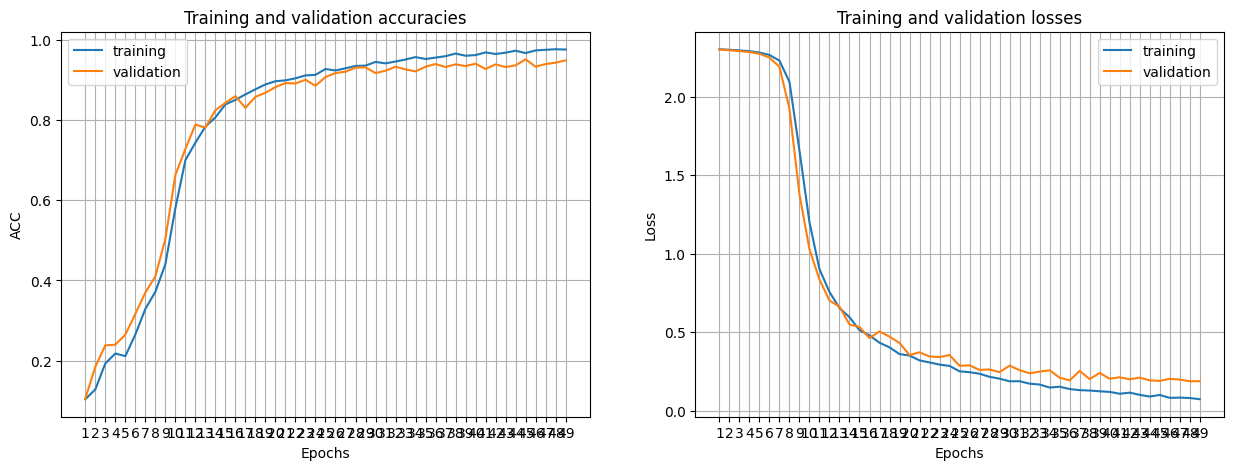

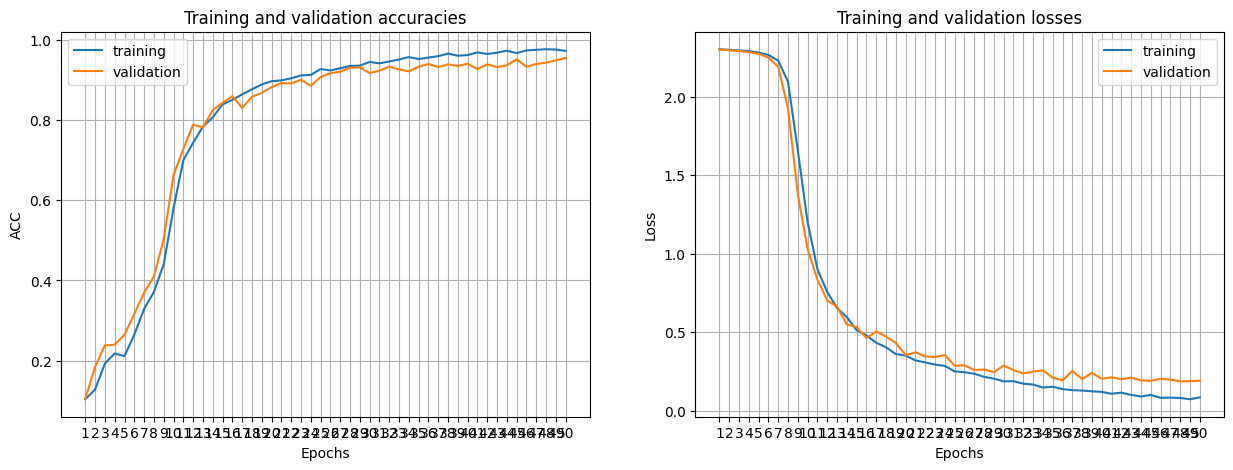

In [31]:
experiment_comined_PQK_CNN = fit_combined_2(epochs=50, lr=lr, model_temp=model_PQK_CNN, train_loader=train_loader_combined, val_loader=test_loader_combined, bs=None, device=device, file_path=path_folder_combined)

In [ ]:
total_params = sum(p.numel() for p in model_quantum.parameters())
print(f"Total number of parameters: {total_params}")

trainable_params = sum(p.numel() for p in model_quantum.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Total number of parameters: 663660
Trainable parameters: 663660


In [32]:
total_params = sum(p.numel() for p in model_PQK_CNN.parameters())
print(f"Total number of parameters: {total_params}")

trainable_params = sum(p.numel() for p in model_PQK_CNN.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Total number of parameters: 2989514
Trainable parameters: 2989514


In [35]:
experiment_comined_PQK_CNN = [{'val_loss': 2.299777030944824, 'val_acc': 0.10583333671092987},
 {'val_loss': 2.2950422763824463, 'val_acc': 0.1850000023841858},
 {'val_loss': 2.289759874343872, 'val_acc': 0.2383333295583725},
 {'val_loss': 2.282904863357544, 'val_acc': 0.23999999463558197},
 {'val_loss': 2.2728583812713623, 'val_acc': 0.26499998569488525},
 {'val_loss': 2.2479782104492188, 'val_acc': 0.3166666626930237},
 {'val_loss': 2.190061569213867, 'val_acc': 0.3700000047683716},
 {'val_loss': 1.9215633869171143, 'val_acc': 0.4099999964237213},
 {'val_loss': 1.3776146173477173, 'val_acc': 0.503333330154419},
 {'val_loss': 1.0277568101882935, 'val_acc': 0.6625000238418579},
 {'val_loss': 0.8342038989067078, 'val_acc': 0.7275000214576721},
 {'val_loss': 0.7008237838745117, 'val_acc': 0.7883333563804626},
 {'val_loss': 0.6615715622901917, 'val_acc': 0.7808333039283752},
 {'val_loss': 0.5482459664344788, 'val_acc': 0.8241666555404663},
 {'val_loss': 0.5318278670310974, 'val_acc': 0.8424999713897705},
 {'val_loss': 0.46183574199676514, 'val_acc': 0.85916668176651},
 {'val_loss': 0.5037208199501038, 'val_acc': 0.8299999833106995},
 {'val_loss': 0.47096216678619385, 'val_acc': 0.8575000166893005},
 {'val_loss': 0.43026992678642273, 'val_acc': 0.8675000071525574},
 {'val_loss': 0.35333842039108276, 'val_acc': 0.8816666603088379},
 {'val_loss': 0.3709031641483307, 'val_acc': 0.8916666507720947},
 {'val_loss': 0.3444938659667969, 'val_acc': 0.89083331823349},
 {'val_loss': 0.3407372236251831, 'val_acc': 0.8999999761581421},
 {'val_loss': 0.3536645472049713, 'val_acc': 0.8849999904632568},
 {'val_loss': 0.2850472033023834, 'val_acc': 0.9066666960716248},
 {'val_loss': 0.28803750872612, 'val_acc': 0.9166666865348816},
 {'val_loss': 0.2588791847229004, 'val_acc': 0.9200000166893005},
 {'val_loss': 0.2615874409675598, 'val_acc': 0.9300000071525574},
 {'val_loss': 0.24448350071907043, 'val_acc': 0.9308333396911621},
 {'val_loss': 0.28632161021232605, 'val_acc': 0.9166666865348816},
 {'val_loss': 0.25714853405952454, 'val_acc': 0.9225000143051147},
 {'val_loss': 0.2370905876159668, 'val_acc': 0.9325000047683716},
 {'val_loss': 0.24835708737373352, 'val_acc': 0.9258333444595337},
 {'val_loss': 0.2561019957065582, 'val_acc': 0.9208333492279053},
 {'val_loss': 0.20944707095623016, 'val_acc': 0.9325000047683716},
 {'val_loss': 0.19247451424598694, 'val_acc': 0.9391666650772095},
 {'val_loss': 0.25228404998779297, 'val_acc': 0.9316666722297668},
 {'val_loss': 0.2006663978099823, 'val_acc': 0.9383333325386047},
 {'val_loss': 0.23954465985298157, 'val_acc': 0.934166669845581},
 {'val_loss': 0.20267482101917267, 'val_acc': 0.9399999976158142},
 {'val_loss': 0.21206334233283997, 'val_acc': 0.9266666769981384},
 {'val_loss': 0.19911253452301025, 'val_acc': 0.9383333325386047},
 {'val_loss': 0.2097371220588684, 'val_acc': 0.9316666722297668},
 {'val_loss': 0.19235801696777344, 'val_acc': 0.9358333349227905},
 {'val_loss': 0.18893344700336456, 'val_acc': 0.9508333206176758},
 {'val_loss': 0.20229263603687286, 'val_acc': 0.9325000047683716},
 {'val_loss': 0.197287455201149, 'val_acc': 0.9391666650772095},
 {'val_loss': 0.1865178793668747, 'val_acc': 0.9424999952316284},
 {'val_loss': 0.18702179193496704, 'val_acc': 0.9483333230018616},
 {'val_loss': 0.18983179330825806, 'val_acc': 0.9541666507720947}]

In [34]:
experiment_classical = [{'val_loss': 2.0501530170440674, 'val_acc': 0.5328947305679321},
 {'val_loss': 0.7443241477012634, 'val_acc': 0.7697368264198303},
 {'val_loss': 0.4823053181171417, 'val_acc': 0.8486841917037964},
 {'val_loss': 0.42468827962875366, 'val_acc': 0.84375},
 {'val_loss': 0.373964786529541, 'val_acc': 0.8766447305679321},
 {'val_loss': 0.36612555384635925, 'val_acc': 0.875},
 {'val_loss': 0.3118486702442169, 'val_acc': 0.8996710777282715},
 {'val_loss': 0.3246943950653076, 'val_acc': 0.9013158082962036},
 {'val_loss': 0.3043003976345062, 'val_acc': 0.8930920958518982},
 {'val_loss': 0.25951147079467773, 'val_acc': 0.9144737124443054},
 {'val_loss': 0.2653597295284271, 'val_acc': 0.9095394611358643},
 {'val_loss': 0.22247354686260223, 'val_acc': 0.9391447305679321},
 {'val_loss': 0.206412672996521, 'val_acc': 0.9292762875556946},
 {'val_loss': 0.19991950690746307, 'val_acc': 0.9358552694320679},
 {'val_loss': 0.23912543058395386, 'val_acc': 0.9292762875556946},
 {'val_loss': 0.18604211509227753, 'val_acc': 0.9490131735801697},
 {'val_loss': 0.18450787663459778, 'val_acc': 0.9440789222717285},
 {'val_loss': 0.18402844667434692, 'val_acc': 0.9325658082962036},
 {'val_loss': 0.1692751795053482, 'val_acc': 0.9555920958518982},
 {'val_loss': 0.14839012920856476, 'val_acc': 0.9605262875556946},
 {'val_loss': 0.16188174486160278, 'val_acc': 0.9588815569877625},
 {'val_loss': 0.13926264643669128, 'val_acc': 0.9572368264198303},
 {'val_loss': 0.1424626260995865, 'val_acc': 0.9605262875556946},
 {'val_loss': 0.15151375532150269, 'val_acc': 0.9572368264198303},
 {'val_loss': 0.1525311917066574, 'val_acc': 0.9572368264198303},
 {'val_loss': 0.11983869969844818, 'val_acc': 0.9671052694320679},
 {'val_loss': 0.12623558938503265, 'val_acc': 0.9621710777282715},
 {'val_loss': 0.11307711154222488, 'val_acc': 0.9638158082962036},
 {'val_loss': 0.11787214130163193, 'val_acc': 0.9638158082962036},
 {'val_loss': 0.11383907496929169, 'val_acc': 0.9654605388641357},
 {'val_loss': 0.11972153931856155, 'val_acc': 0.9654605388641357},
 {'val_loss': 0.10249502211809158, 'val_acc': 0.9753289222717285},
 {'val_loss': 0.11500198394060135, 'val_acc': 0.9671052694320679},
 {'val_loss': 0.11245012283325195, 'val_acc': 0.9703947305679321},
 {'val_loss': 0.10233048349618912, 'val_acc': 0.9720394611358643},
 {'val_loss': 0.11938288062810898, 'val_acc': 0.9638158082962036},
 {'val_loss': 0.1042407974600792, 'val_acc': 0.9638158082962036},
 {'val_loss': 0.10346110165119171, 'val_acc': 0.9720394611358643},
 {'val_loss': 0.10326728224754333, 'val_acc': 0.9671052694320679},
 {'val_loss': 0.10372242331504822, 'val_acc': 0.9703947305679321},
 {'val_loss': 0.10392358154058456, 'val_acc': 0.9671052694320679},
 {'val_loss': 0.09266001731157303, 'val_acc': 0.9703947305679321},
 {'val_loss': 0.09747582674026489, 'val_acc': 0.9753289222717285},
 {'val_loss': 0.10403312742710114, 'val_acc': 0.9703947305679321},
 {'val_loss': 0.09259340912103653, 'val_acc': 0.9736841917037964},
 {'val_loss': 0.10290344804525375, 'val_acc': 0.9703947305679321},
 {'val_loss': 0.11211894452571869, 'val_acc': 0.96875},
 {'val_loss': 0.1085023507475853, 'val_acc': 0.9671052694320679},
 {'val_loss': 0.09355884790420532, 'val_acc': 0.9736841917037964},
 {'val_loss': 0.10248983651399612, 'val_acc': 0.9671052694320679}]

In [36]:
experiment_comined_PQK_CNN_val_loss_values = [d["val_loss"] for d in experiment_comined_PQK_CNN]
experiment_classical_val_loss_values = [d["val_loss"] for d in experiment_classical]

In [37]:
experiment_comined_PQK_CNN_val_acc_values = [d["val_acc"] for d in experiment_comined_PQK_CNN]
experiment_classical_val_acc_values = [d["val_acc"] for d in experiment_classical]

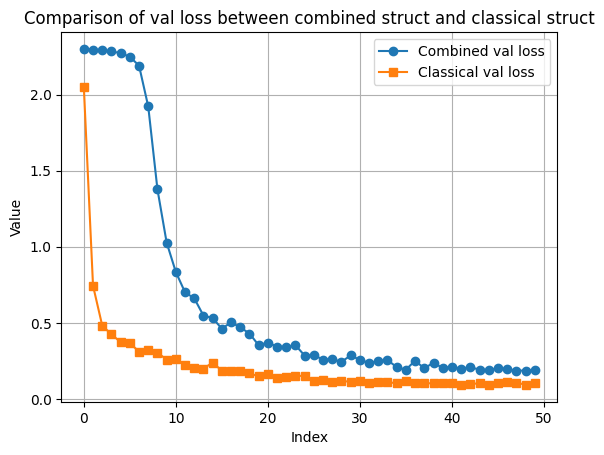

In [38]:
# Plot the arrays
plt.plot(experiment_comined_PQK_CNN_val_loss_values, label='Combined val loss', marker='o')  # Plot Array 1
plt.plot(experiment_classical_val_loss_values, label='Classical val loss', marker='s')  # Plot Array 2

# Add title and labels
plt.title('Comparison of val loss between combined struct and classical struct')
plt.xlabel('Index')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show grid
plt.grid()

# Show the plot
plt.show()

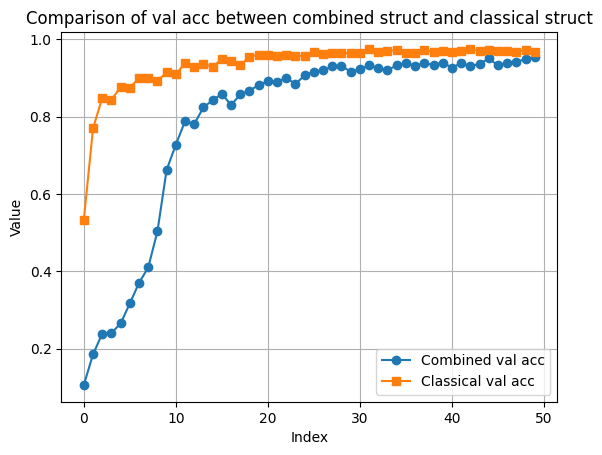

In [39]:
# Plot the arrays
plt.plot(experiment_comined_PQK_CNN_val_acc_values, label='Combined val acc', marker='o')  # Plot Array 1
plt.plot(experiment_classical_val_acc_values, label='Classical val acc', marker='s')  # Plot Array 2

# Add title and labels
plt.title('Comparison of val acc between combined struct and classical struct')
plt.xlabel('Index')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show grid
plt.grid()

# Show the plot
plt.show()